In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from datetime import datetime

from math import sqrt
from sklearn.metrics import mean_squared_error
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import itertools
import warnings
warnings.filterwarnings("ignore")

import math

import statsmodels.formula.api as smf

import scipy.optimize as sco

Inizializziamo anzitutto l'array comprendente le 6 azioni del mercato americano e le date di inizio e fine da analizzare

In [2]:
assets = ['TSLA', 'F', 'KO', 'PEP', 'MSFT', 'ADBE']
start_date = '2012-11-30'
end_date = '2022-11-30'

In [3]:
TSLA =  yf.download('TSLA', start_date, end_date)
F = yf.download('F', start_date, end_date)
KO = yf.download('KO', start_date, end_date)
PEP = yf.download('PEP', start_date, end_date)
MSFT = yf.download('MSFT', start_date, end_date)
ADBE = yf.download('ADBE', start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


2. Statistiche descrittive
    a. Calcolare il rendimento cumulato e composto annuo di ciascun titolo nel periodo;

np.cumprod() ritorna il prodotto cumulato degli elementi passati input secondo l'axis che viene passato

In [4]:
df = pd.concat([TSLA['Adj Close'], F['Adj Close'], KO['Adj Close'], PEP['Adj Close'], MSFT['Adj Close'], ADBE['Adj Close']], axis = 1)
df.columns = ["TSLA", "F", "KO", "PEP", "MSFT", "ADBE"] #rinominiamo le colonne

In [5]:
df.head()

TSLA         F         KO        PEP       MSFT       ADBE
Date                                                                      
2012-11-30  2.254667  7.618592  27.682364  52.271538  21.950113  34.610001
2012-12-03  2.308000  7.591981  27.288158  52.018410  21.793446  34.700001
2012-12-04  2.260000  7.525438  27.120260  52.010941  21.743967  35.299999
2012-12-05  2.247333  7.525438  27.237059  52.301319  21.991337  35.400002
2012-12-06  2.260000  7.478865  27.288158  52.533890  22.040817  35.139999

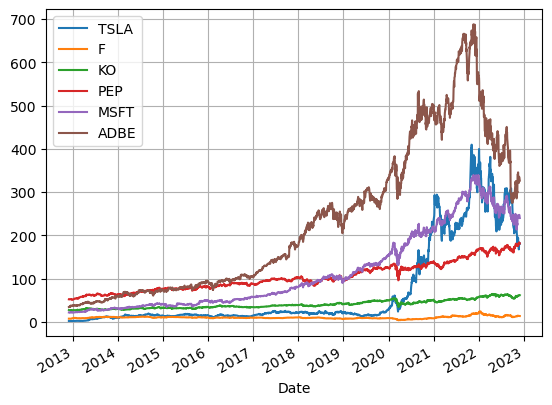

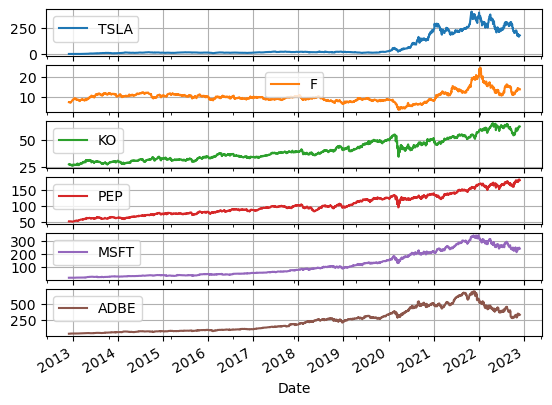

In [6]:
df.plot(grid = True); #costruzione grafico complessivo
df.plot(subplots = True, grid = True); #costruzione dei singoli sotto-grafi

## 2.a Calcoliamo i rendimenti cumulati e composti annui

### Cumulati

In [7]:
for i in ['TSLA', 'F', 'KO', 'PEP', 'MSFT', 'ADBE']:
    print(i)
    print((df[i].tail(1)[0] / df[i][0])-1) #Prezzo dopo 10 anni fratto prezzo odierno

TSLA
79.20253027490708
F
0.8047954775965593
KO
1.2411381489452844
PEP
2.471451330288185
MSFT
9.948918512838823
ADBE
8.4417796306412


### Composto

In [8]:
for i in ['TSLA', 'F', 'KO', 'PEP', 'MSFT', 'ADBE']:
    print(i)
    x = (df[i].tail(1)[0] / df[i][0])
    x = x**(1/10)-1 #Radice decima
    print(x)

TSLA
0.5503109231477139
F
0.06082268779068878
KO
0.08404388216860181
PEP
0.13253363275611973
MSFT
0.27039016337238597
ADBE
0.2517147963162871


### Calcoliamo i rendimenti semplici di ciascun titolo.

In [9]:
df_rtn =  (df / df.shift(1))-1

df_rtn.dropna(inplace = True)

In [10]:
df_rtn.head()

TSLA         F        KO       PEP      MSFT      ADBE
Date                                                                  
2012-12-03  0.023655 -0.003493 -0.014240 -0.004843 -0.007137  0.002600
2012-12-04 -0.020797 -0.008765 -0.006153 -0.000144 -0.002270  0.017291
2012-12-05 -0.005605  0.000000  0.004307  0.005583  0.011376  0.002833
2012-12-06  0.005636 -0.006189  0.001876  0.004447  0.002250 -0.007345
2012-12-07  0.007965  0.021352  0.008828  0.003428 -0.010101  0.009676

### Calcoliamo i rendimenti logaritmici di ciascun titolo.

In [11]:
df_log =  np.log(df / df.shift(1))

df_log.dropna(inplace = True)

In [12]:
df_log.head()

TSLA         F        KO       PEP      MSFT      ADBE
Date                                                                  
2012-12-03  0.023379 -0.003499 -0.014343 -0.004854 -0.007163  0.002597
2012-12-04 -0.021017 -0.008804 -0.006172 -0.000144 -0.002273  0.017143
2012-12-05 -0.005621  0.000000  0.004297  0.005568  0.011312  0.002829
2012-12-06  0.005621 -0.006208  0.001874  0.004437  0.002247 -0.007372
2012-12-07  0.007933  0.021128  0.008789  0.003422 -0.010152  0.009629

In [13]:
df_log.head()

TSLA         F        KO       PEP      MSFT      ADBE
Date                                                                  
2012-12-03  0.023379 -0.003499 -0.014343 -0.004854 -0.007163  0.002597
2012-12-04 -0.021017 -0.008804 -0.006172 -0.000144 -0.002273  0.017143
2012-12-05 -0.005621  0.000000  0.004297  0.005568  0.011312  0.002829
2012-12-06  0.005621 -0.006208  0.001874  0.004437  0.002247 -0.007372
2012-12-07  0.007933  0.021128  0.008789  0.003422 -0.010152  0.009629

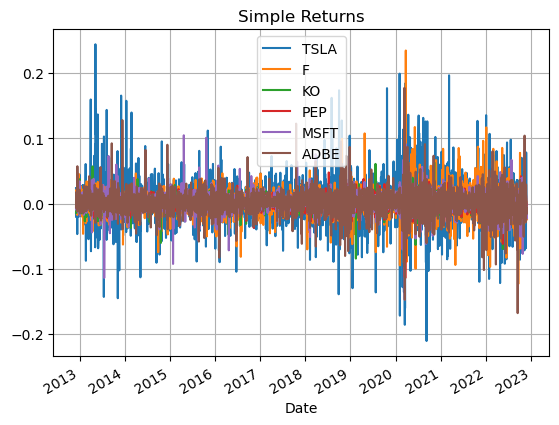

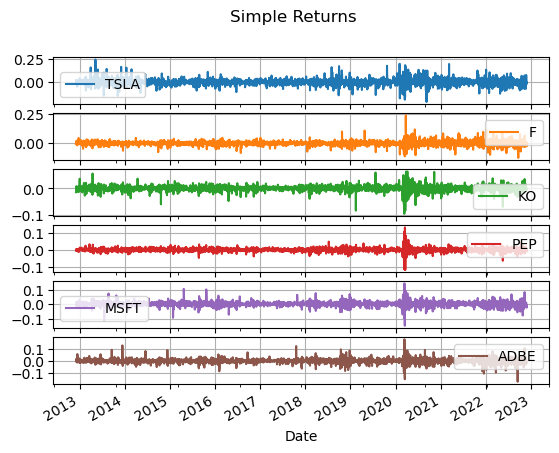

In [14]:
df_rtn.plot(grid = True, title = "Simple Returns")
df_rtn.plot(grid = True, subplots = True, title = "Simple Returns");

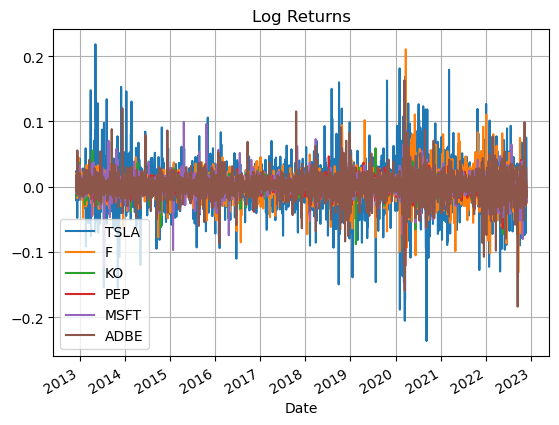

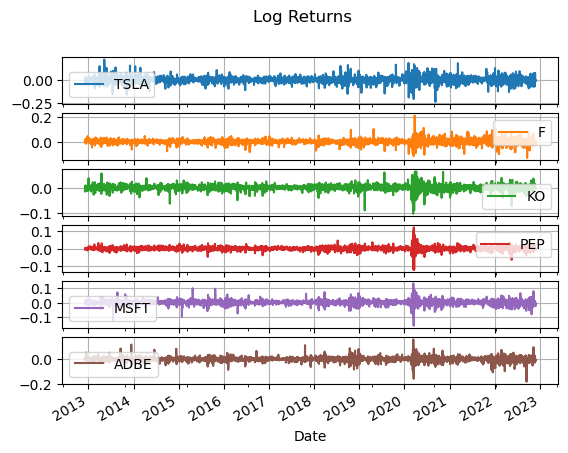

In [15]:
df_log.plot(grid = True, title = "Log Returns")
df_log.plot(grid = True, subplots = True, title = "Log Returns");

Correlazione tra i vari titoli dello stesso settore

In [16]:
np.corrcoef(df_log['TSLA'], df_log['F'])

array([[1.        , 0.30256982],
       [0.30256982, 1.        ]])

In [17]:
np.corrcoef(df_log['KO'], df_log['PEP'])

array([[1.        , 0.72869441],
       [0.72869441, 1.        ]])

In [18]:
np.corrcoef(df_log['MSFT'], df_log['ADBE'])

array([[1.       , 0.6850972],
       [0.6850972, 1.       ]])

Istogrammi

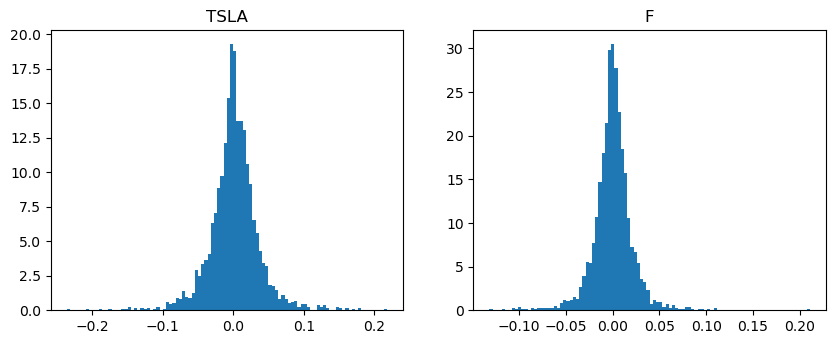

In [19]:
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.title('TSLA')
plt.hist(df_log['TSLA'], density = True, bins = 100);
plt.subplot(222)
plt.title('F')
plt.hist(df_log['F'], density = True, bins = 100);

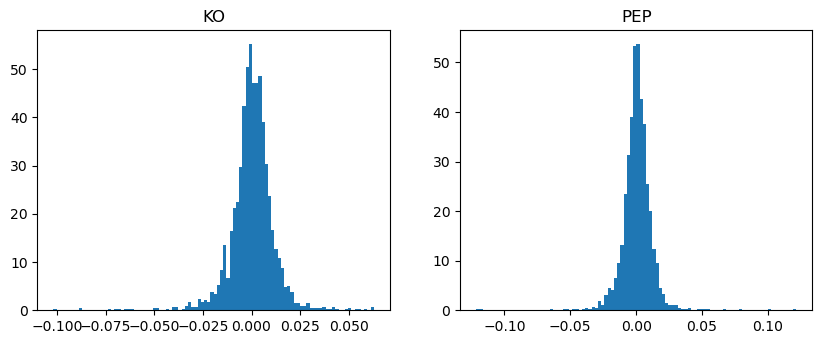

In [20]:
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.title('KO')
plt.hist(df_log['KO'], density = True, bins = 100);
plt.subplot(222)
plt.title('PEP')
plt.hist(df_log['PEP'], density = True, bins = 100);

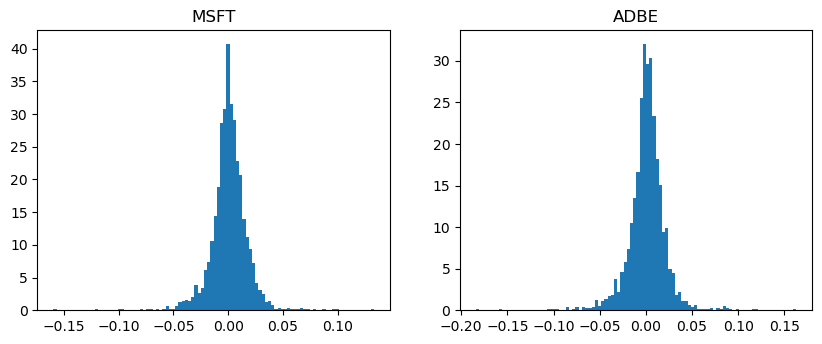

In [21]:
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.title('MSFT')
plt.hist(df_log['MSFT'], density = True, bins = 100);
plt.subplot(222)
plt.title('ADBE')
plt.hist(df_log['ADBE'], density = True, bins = 100);

Creare grafici diagnostici a 4 sezioni (istogramma, kernel density, boxplot, qq-plot) per
ciascuna serie di rendimenti e commentare (i rendimenti sono distribuiti normalmente?
Ci sono outliers?)

Rendimenti composti

Molti outliers

In [22]:
#Media
print(round(df_log.mean(), 4))

#Varianza
print(round(df_log.var(), 4))

#Deviazione standard
print(round(df_log.std(), 4))

#Asimmetria (skew)
print(round(df_log.skew(), 4))

#Kurtosi 
print(round(df_log.kurtosis(), 4))

#Max
print(round(df_log.max(), 4))

#Min
print(round(df_log.min(), 4))

TSLA    0.0017
F       0.0002
KO      0.0003
PEP     0.0005
MSFT    0.0010
ADBE    0.0009
dtype: float64
TSLA    0.0013
F       0.0004
KO      0.0001
PEP     0.0001
MSFT    0.0003
ADBE    0.0004
dtype: float64
TSLA    0.0356
F       0.0211
KO      0.0115
PEP     0.0115
MSFT    0.0170
ADBE    0.0198
dtype: float64
TSLA    0.0206
F       0.1400
KO     -0.8931
PEP    -0.5870
MSFT   -0.2927
ADBE   -0.3923
dtype: float64
TSLA     5.1817
F        8.5657
KO      10.6779
PEP     23.7350
MSFT     9.3039
ADBE    10.3080
dtype: float64
TSLA    0.2183
F       0.2106
KO      0.0628
PEP     0.1217
MSFT    0.1329
ADBE    0.1631
dtype: float64
TSLA   -0.2365
F      -0.1315
KO     -0.1017
PEP    -0.1214
MSFT   -0.1595
ADBE   -0.1838
dtype: float64


In [23]:
df

TSLA          F         KO         PEP        MSFT  \
Date                                                                   
2012-11-30    2.254667   7.618592  27.682364   52.271538   21.950113   
2012-12-03    2.308000   7.591981  27.288158   52.018410   21.793446   
2012-12-04    2.260000   7.525438  27.120260   52.010941   21.743967   
2012-12-05    2.247333   7.525438  27.237059   52.301319   21.991337   
2012-12-06    2.260000   7.478865  27.288158   52.533890   22.040817   
...                ...        ...        ...         ...         ...   
2022-11-22  169.910004  14.070000  61.910915  183.694153  245.029999   
2022-11-23  183.199997  14.030000  62.188946  183.932663  247.580002   
2022-11-25  182.860001  14.080000  62.248520  182.968674  247.490005   
2022-11-28  182.919998  13.730000  62.258453  182.750046  241.759995   
2022-11-29  180.830002  13.750000  62.040001  181.458099  240.330002   

                  ADBE  
Date                    
2012-11-30   34.610001  
2012-12-03   34.700001  
2012-12-04   35.299999  
2012-12-05   35.400002  
2012-12-06   35.139999  
...                ...  
2022-11-22  330.880005  
2022-11-23  335.779999  
2022-11-25  334.299988  
2022-11-28  328.970001  
2022-11-29  326.779999  

[2517 rows x 6 columns]

Andamento rendimento e volatilità nel tempo

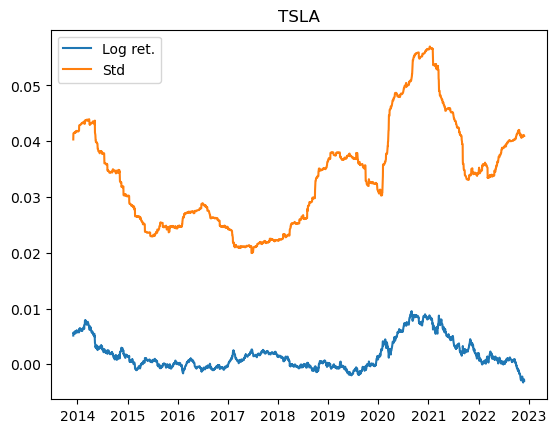

In [24]:
plt.title('TSLA')
plt.plot(df_log['TSLA'].rolling(252).mean())# Rolling sui 252 giorni lavorativi annui sulla media dei rendimenti
plt.plot(df_log['TSLA'].rolling(252).std())
plt.legend(['Log ret.', 'Std'])

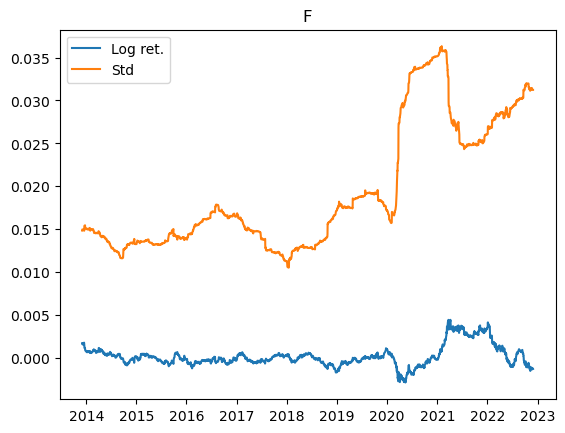

In [25]:
plt.title('F')
plt.plot(df_log['F'].rolling(252).mean())# Rolling sui 252 giorni lavorativi annui sulla media dei rendimenti
plt.plot(df_log['F'].rolling(252).std())
plt.legend(['Log ret.', 'Std'])

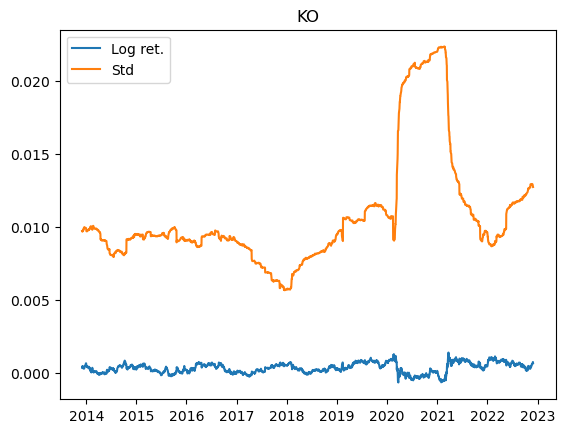

In [26]:
plt.title('KO')
plt.plot(df_log['KO'].rolling(252).mean())# Rolling sui 252 giorni lavorativi annui sulla media dei rendimenti
plt.plot(df_log['KO'].rolling(252).std())
plt.legend(['Log ret.', 'Std'])

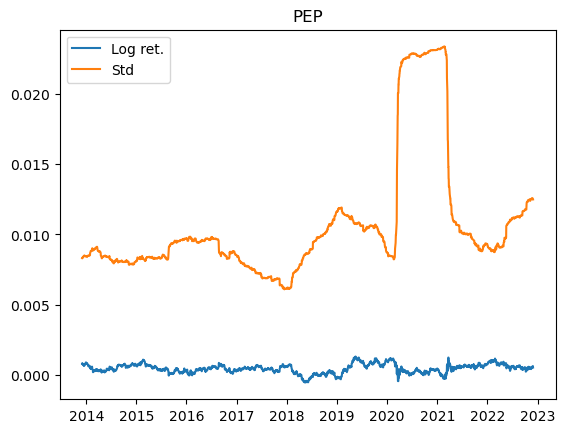

In [27]:
plt.title('PEP')
plt.plot(df_log['PEP'].rolling(252).mean())# Rolling sui 252 giorni lavorativi annui sulla media dei rendimenti
plt.plot(df_log['PEP'].rolling(252).std())
plt.legend(['Log ret.', 'Std'])

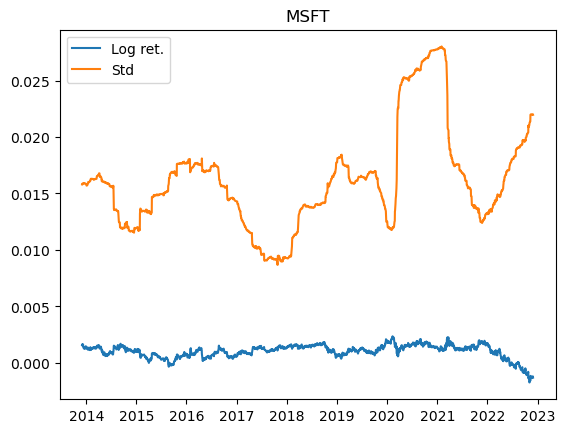

In [28]:
plt.title('MSFT')
plt.plot(df_log['MSFT'].rolling(252).mean())# Rolling sui 252 giorni lavorativi annui sulla media dei rendimenti
plt.plot(df_log['MSFT'].rolling(252).std())
plt.legend(['Log ret.', 'Std'])

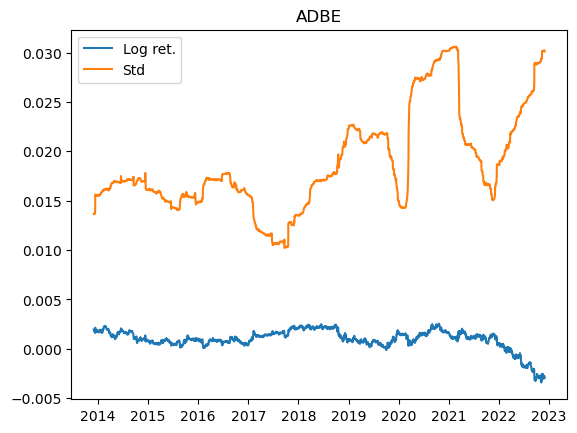

In [29]:
plt.title('ADBE')
plt.plot(df_log['ADBE'].rolling(252).mean())# Rolling sui 252 giorni lavorativi annui sulla media dei rendimenti
plt.plot(df_log['ADBE'].rolling(252).std())
plt.legend(['Log ret.', 'Std'])

Matrice di varianze/covarianze

In [30]:
df_log.cov() # Matrice di varianza/covarianza

TSLA         F        KO       PEP      MSFT      ADBE
TSLA  0.001265  0.000227  0.000077  0.000079  0.000231  0.000278
F     0.000227  0.000443  0.000089  0.000075  0.000130  0.000127
KO    0.000077  0.000089  0.000131  0.000096  0.000080  0.000078
PEP   0.000079  0.000075  0.000096  0.000132  0.000096  0.000094
MSFT  0.000231  0.000130  0.000080  0.000096  0.000288  0.000231
ADBE  0.000278  0.000127  0.000078  0.000094  0.000231  0.000394

Matrice di correlazione

In [31]:
df_log.corr() # Matrice di correlazione

TSLA         F        KO       PEP      MSFT      ADBE
TSLA  1.000000  0.302570  0.189014  0.192742  0.382594  0.393806
F     0.302570  1.000000  0.368755  0.308633  0.363708  0.303686
KO    0.189014  0.368755  1.000000  0.728694  0.412138  0.343167
PEP   0.192742  0.308633  0.728694  1.000000  0.492353  0.411956
MSFT  0.382594  0.363708  0.412138  0.492353  1.000000  0.685097
ADBE  0.393806  0.303686  0.343167  0.411956  0.685097  1.000000

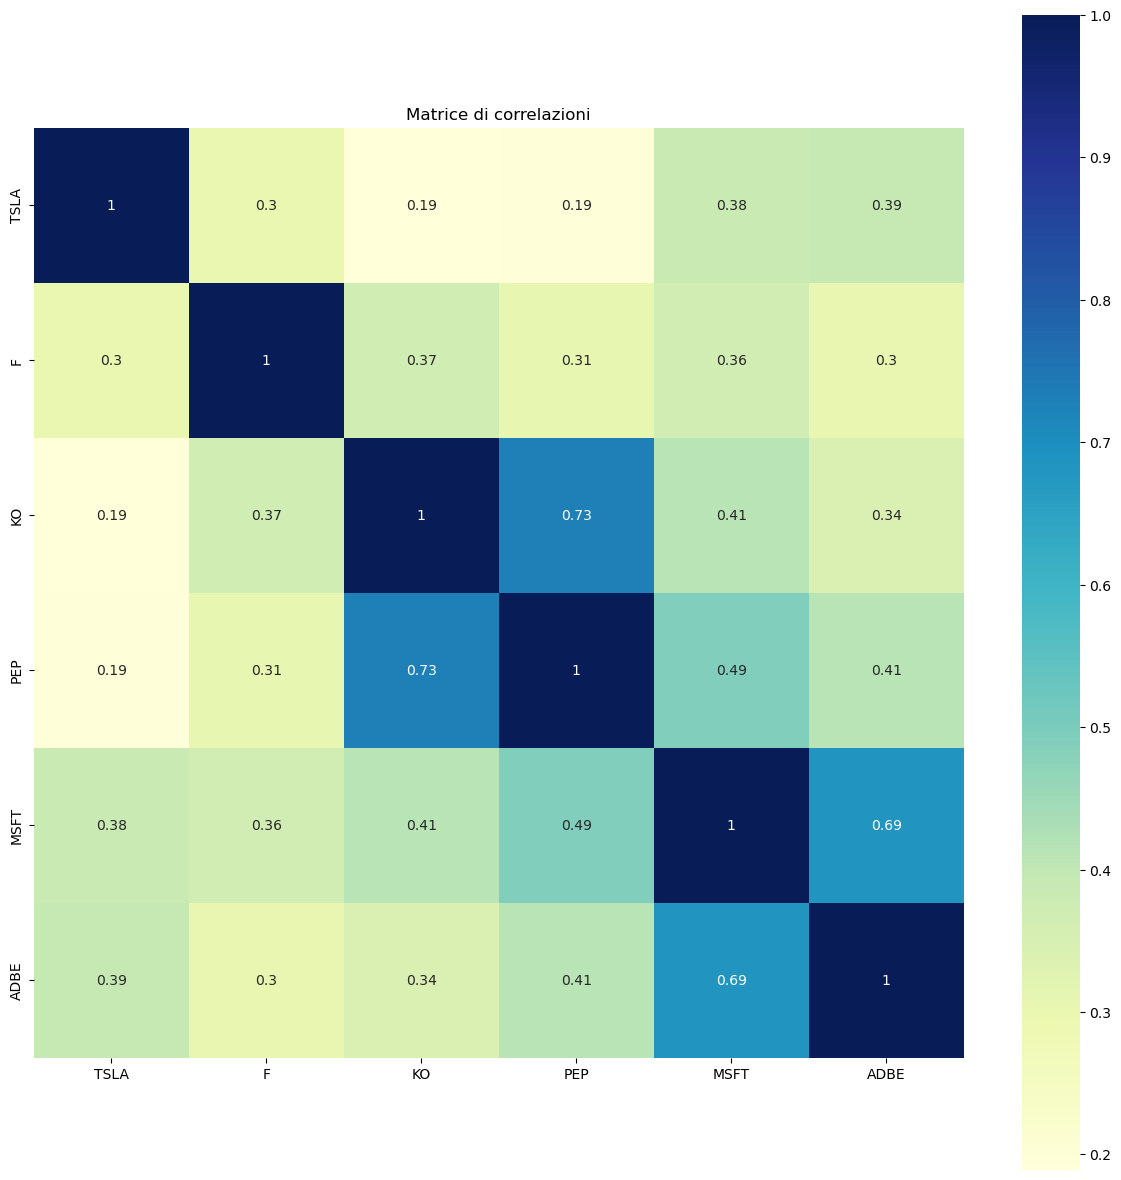

In [32]:
correlation = df_log.corr()
plt.figure(figsize=(15,15))
plt.title('Matrice di correlazioni')
sns.heatmap(correlation, vmax=1, square=True,annot=True, cmap="YlGnBu");

TSLA

<AxesSubplot:title={'center':'Boxplot TSLA'}>

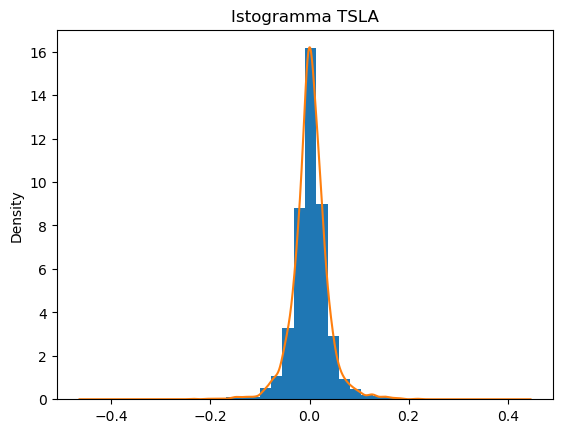

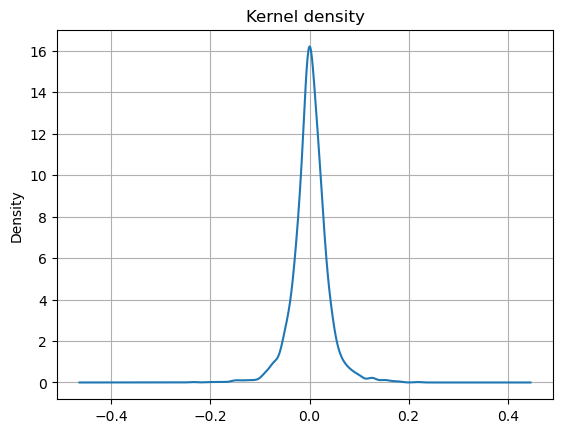

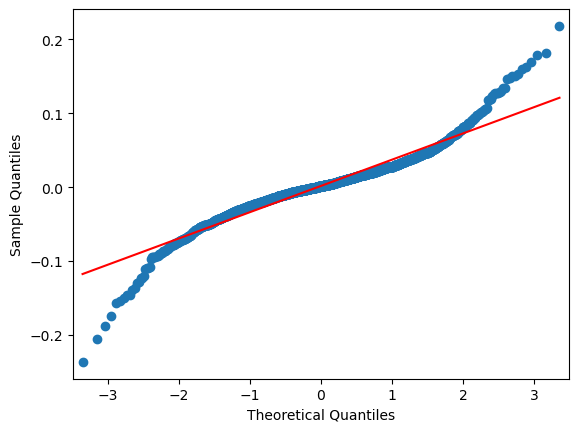

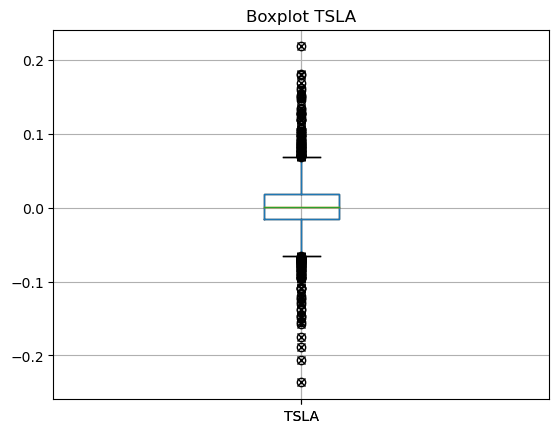

In [33]:
plt.figure()
plt.hist(df_log['TSLA'], density = True, bins=20)
plt.title('Istogramma TSLA')
df_log['TSLA'].plot.density()

plt.figure()
plt.title("Kernel density")
df_log['TSLA'].plot.kde()
plt.grid()

import statsmodels.api as sm
sm.qqplot(df_log['TSLA'], line = 's')

plt.figure()

plt.boxplot(df_log['TSLA'], sym = 'x')
plt.title('Boxplot TSLA')
df_log['TSLA'].to_frame().boxplot()

F

<AxesSubplot:title={'center':'Rendimenti di F'}>

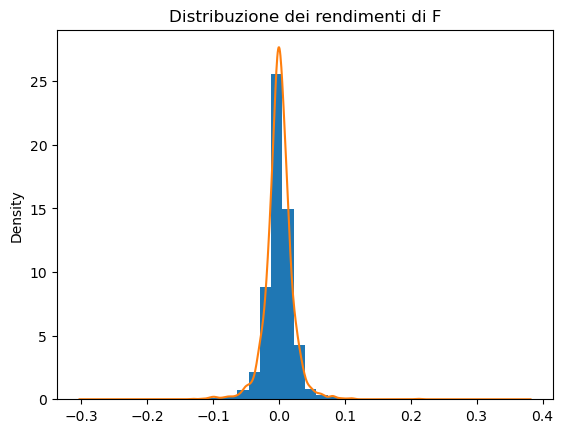

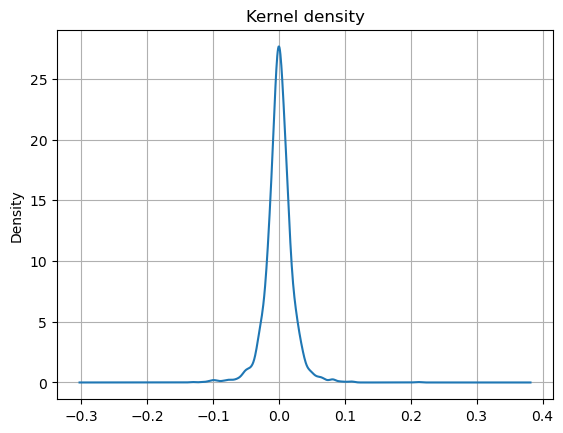

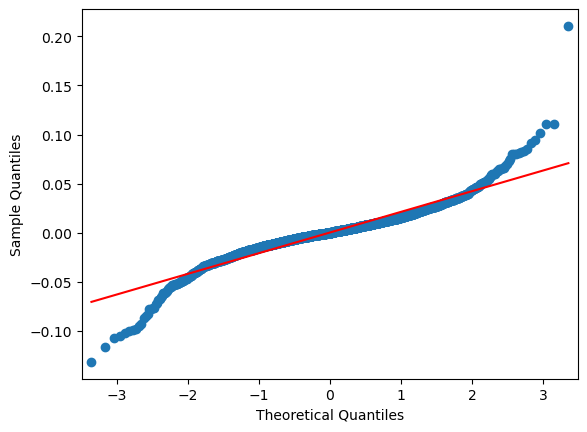

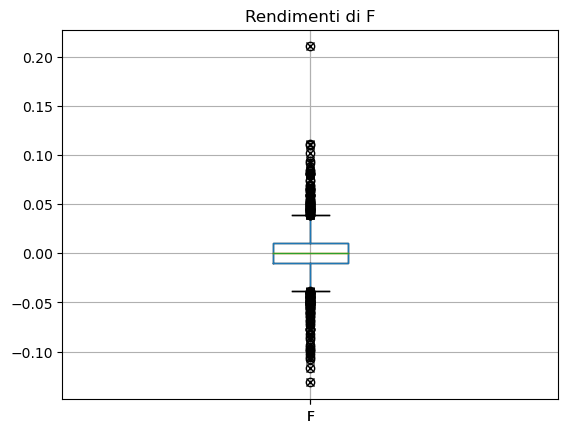

In [34]:
plt.figure()
plt.hist(df_log['F'], density = True, bins=20)
plt.title('Distribuzione dei rendimenti di F')
df_log['F'].plot.density()

plt.figure()
plt.title("Kernel density")
df_log['F'].plot.kde()
plt.grid()

import statsmodels.api as sm
sm.qqplot(df_log['F'], line = 's')

plt.figure()

plt.boxplot(df_log['F'], sym = 'x')
plt.title('Rendimenti di F')
df_log['F'].to_frame().boxplot()

KO

<AxesSubplot:title={'center':'Rendimenti di KO'}>

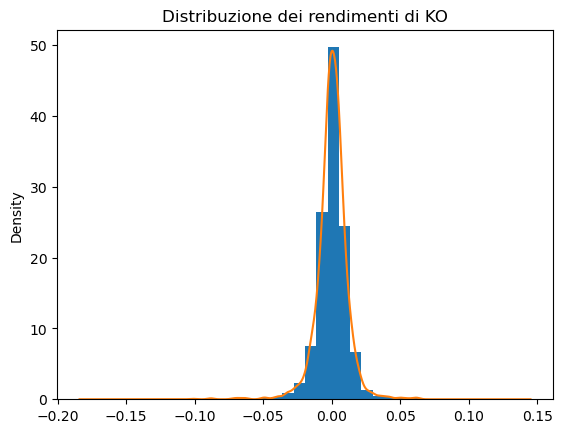

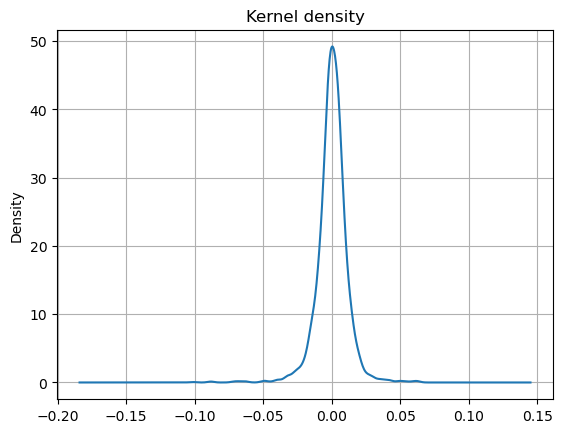

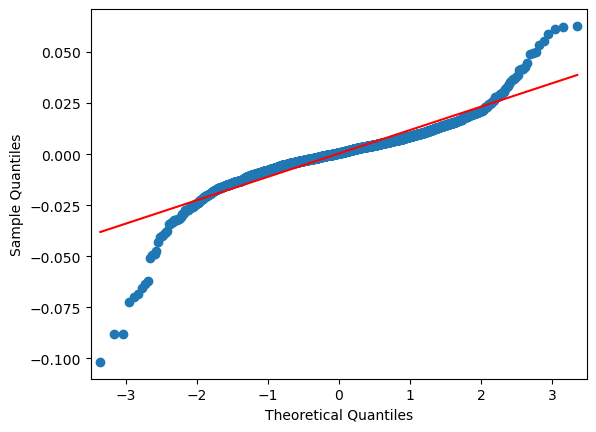

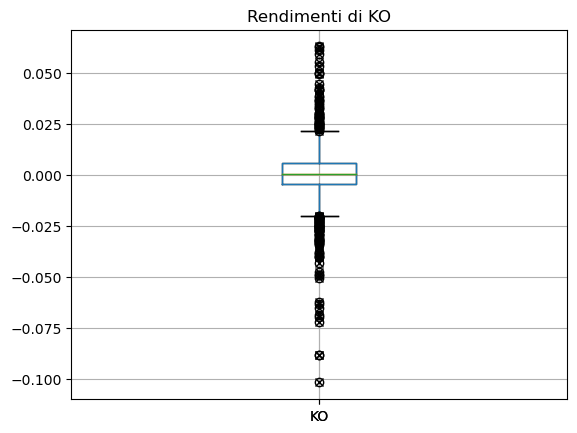

In [35]:
plt.figure()
plt.hist(df_log['KO'], density = True, bins=20)
plt.title('Distribuzione dei rendimenti di KO')
df_log['KO'].plot.density()

plt.figure()
plt.title("Kernel density")
df_log['KO'].plot.kde()
plt.grid()

import statsmodels.api as sm
sm.qqplot(df_log['KO'], line = 's')

plt.figure()

plt.boxplot(df_log['KO'], sym = 'x')
plt.title('Rendimenti di KO')
df_log['KO'].to_frame().boxplot()

PEP

<AxesSubplot:title={'center':'Rendimenti di PEP'}>

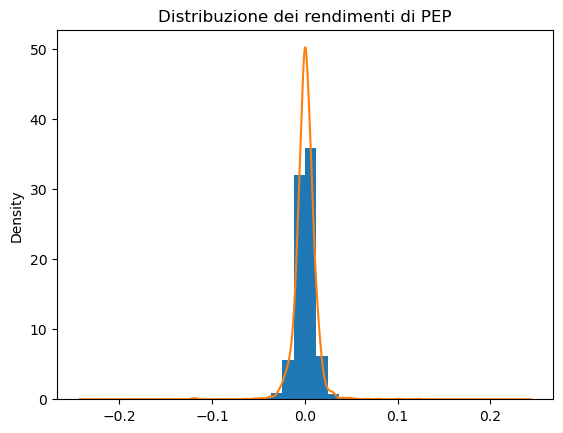

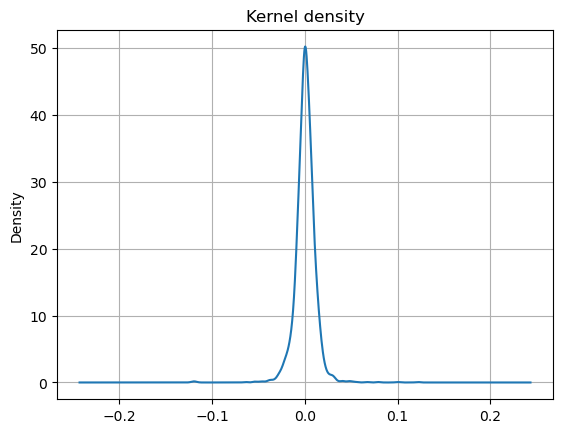

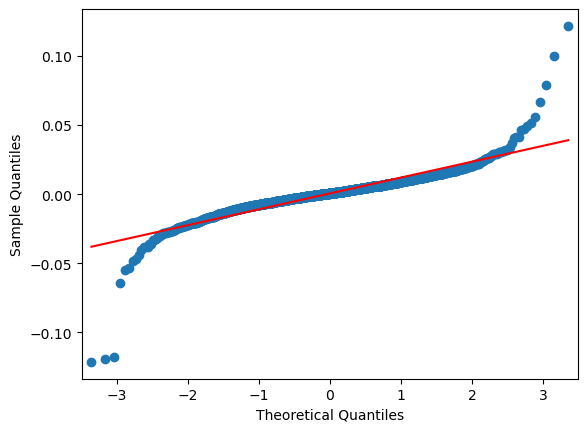

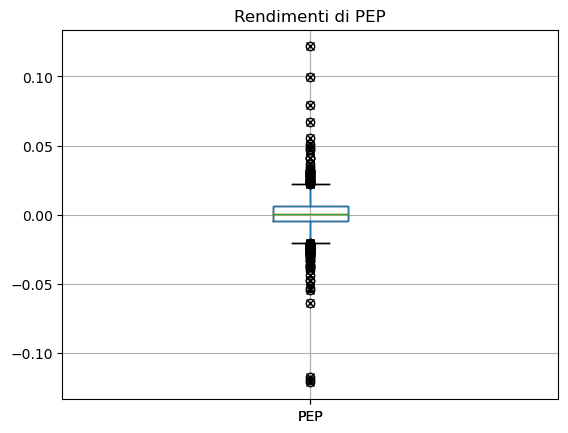

In [36]:
plt.figure()
plt.hist(df_log['PEP'], density = True, bins=20)
plt.title('Distribuzione dei rendimenti di PEP')
df_log['PEP'].plot.density()

plt.figure()
plt.title("Kernel density")
df_log['PEP'].plot.kde()
plt.grid()

import statsmodels.api as sm
sm.qqplot(df_log['PEP'], line = 's')

plt.figure()

plt.boxplot(df_log['PEP'], sym = 'x')
plt.title('Rendimenti di PEP')
df_log['PEP'].to_frame().boxplot()

MSFT

<AxesSubplot:title={'center':'Rendimenti di MSFT'}>

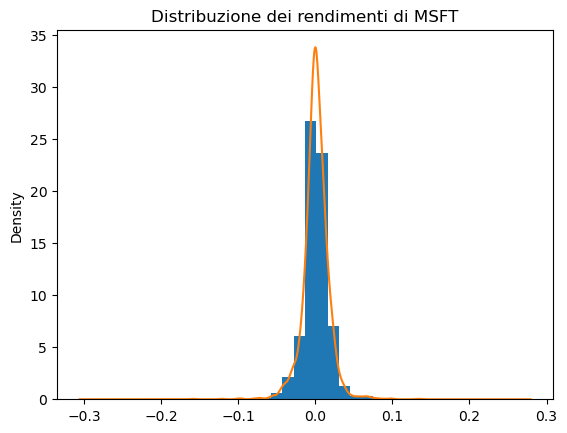

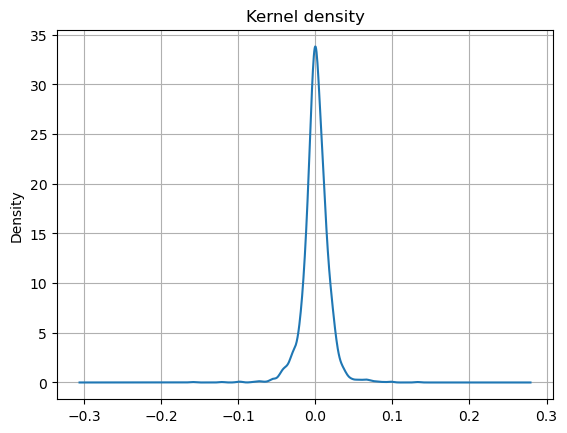

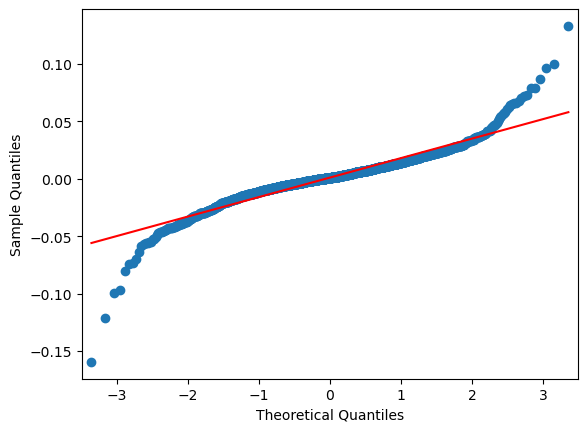

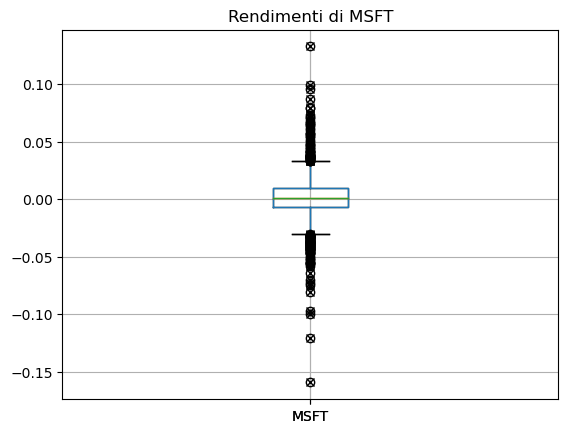

In [37]:
plt.figure()
plt.hist(df_log['MSFT'], density = True, bins=20)
plt.title('Distribuzione dei rendimenti di MSFT')
df_log['MSFT'].plot.density()

plt.figure()
plt.title("Kernel density")
df_log['MSFT'].plot.kde()
plt.grid()

import statsmodels.api as sm
sm.qqplot(df_log['MSFT'], line = 's')

plt.figure()

plt.boxplot(df_log['MSFT'], sym = 'x')
plt.title('Rendimenti di MSFT')
df_log['MSFT'].to_frame().boxplot()

ADBE

<AxesSubplot:title={'center':'Rendimenti di ADBE'}>

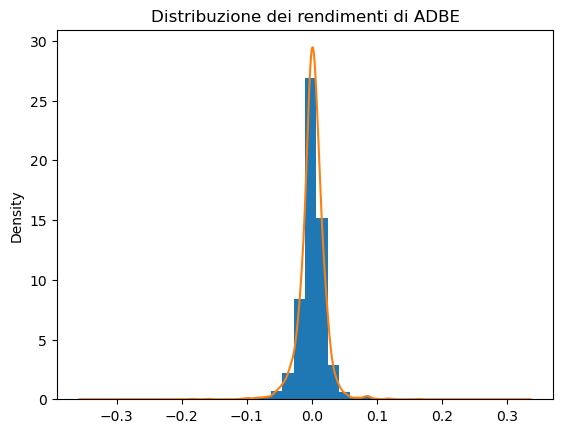

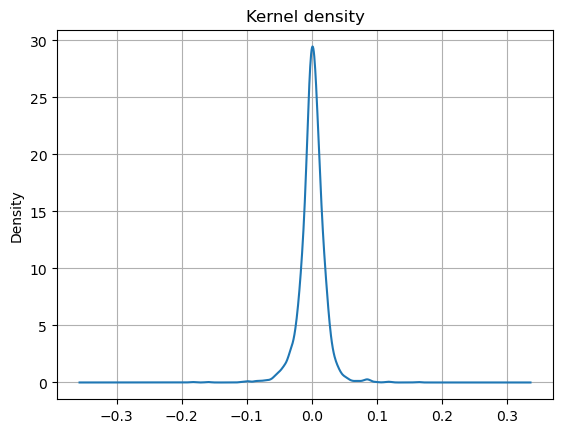

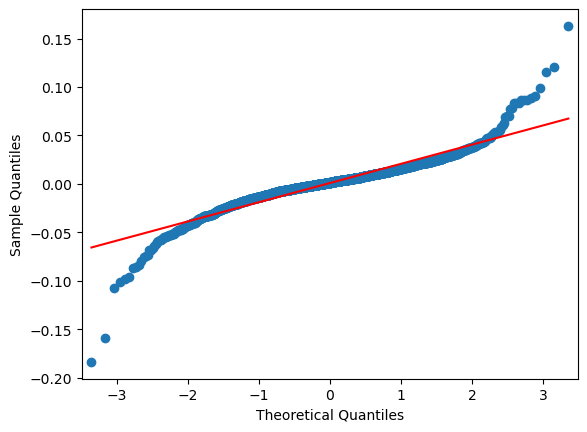

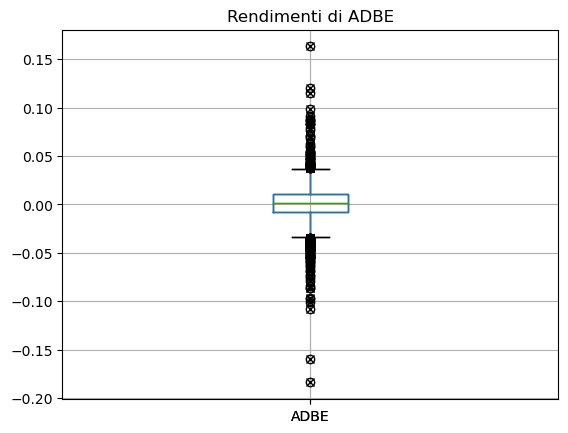

In [38]:
plt.figure()
plt.hist(df_log['ADBE'], density = True, bins=20)
plt.title('Distribuzione dei rendimenti di ADBE')
df_log['ADBE'].plot.density()

plt.figure()
plt.title("Kernel density")
df_log['ADBE'].plot.kde()
plt.grid()

import statsmodels.api as sm
sm.qqplot(df_log['ADBE'], line = 's')

plt.figure()

plt.boxplot(df_log['ADBE'], sym = 'x')
plt.title('Rendimenti di ADBE')
df_log['ADBE'].to_frame().boxplot()

# 2h Fare il grafico dell’andamento nel tempo delle correlazioni fra i titoli

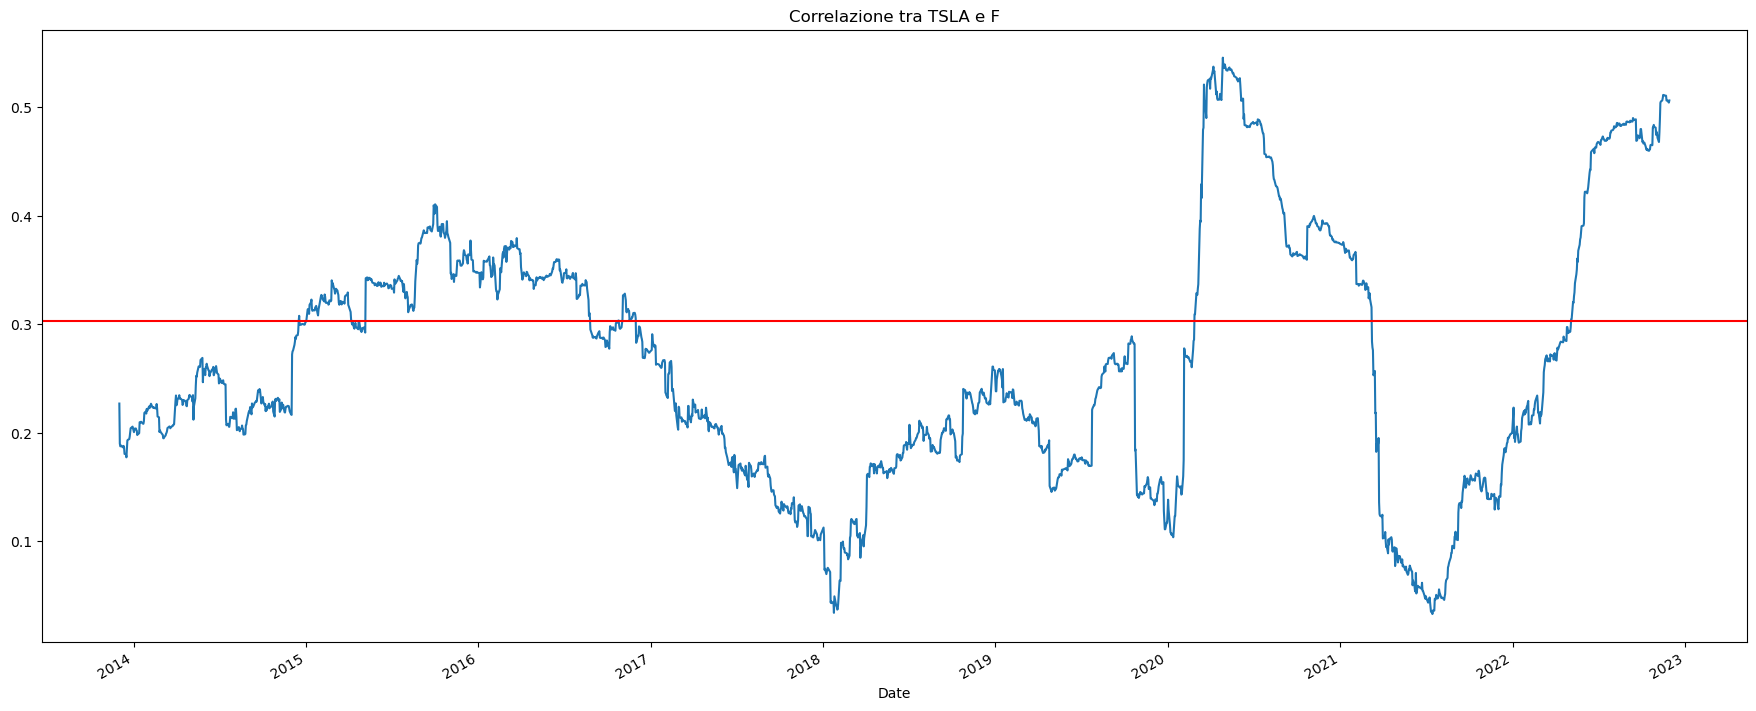

In [39]:
# correlazione tra Tesla e F
ax = df_log["TSLA"].rolling(window=252).corr(df_log["F"]).plot (figsize=(22,9), title = "Correlazione tra TSLA e F")
ax.axhline(df_log.corr().iloc[0,1], c='r');

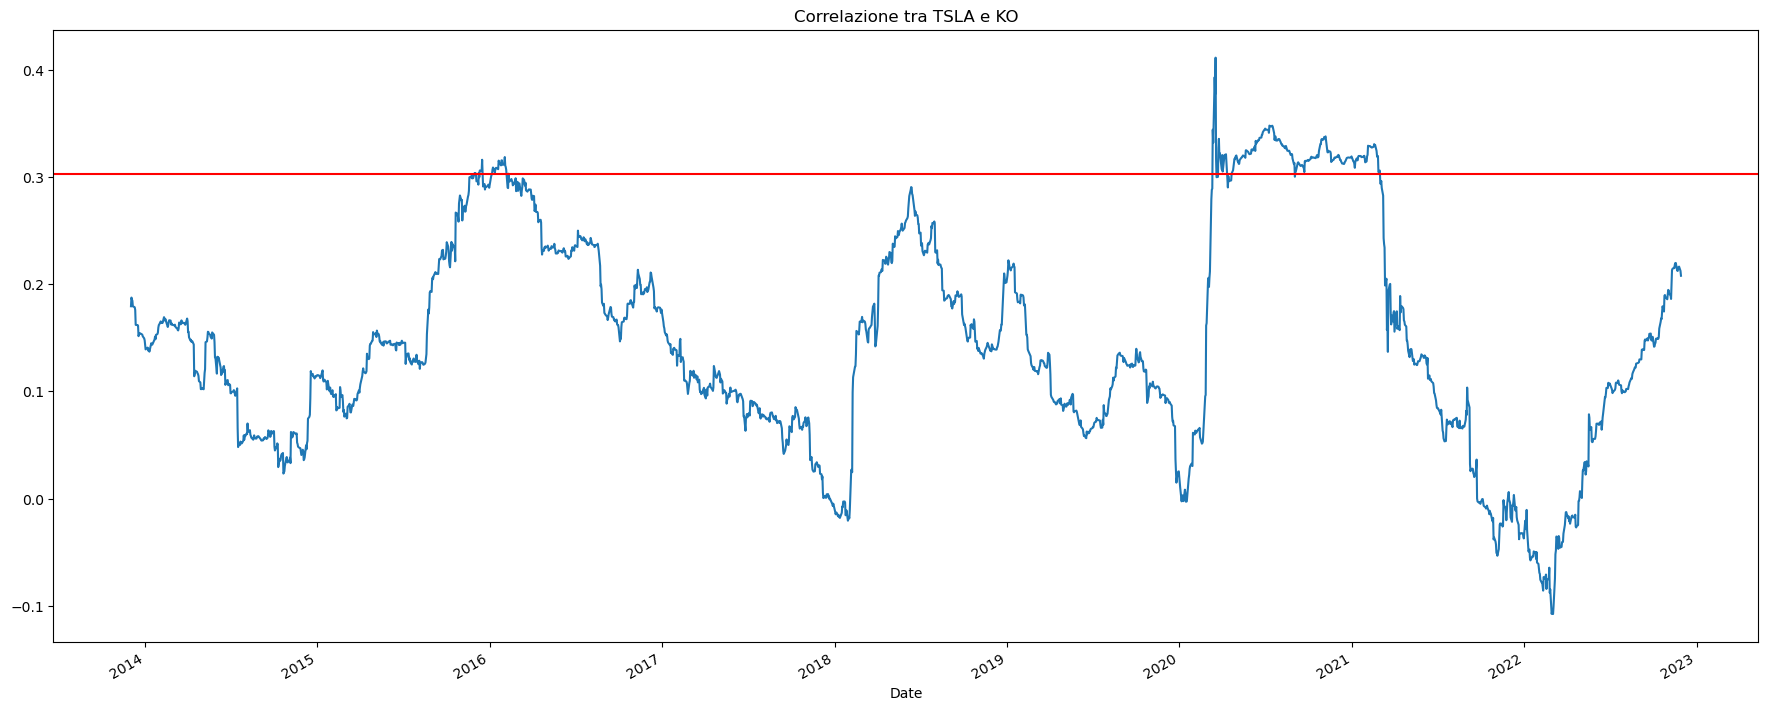

In [40]:
# correlazione tra Tesla e KO
ax = df_log["TSLA"].rolling(window=252).corr(df_log["KO"]).plot (figsize=(22,9), title = "Correlazione tra TSLA e KO")
ax.axhline(df_log.corr().iloc[0,1], c='r');

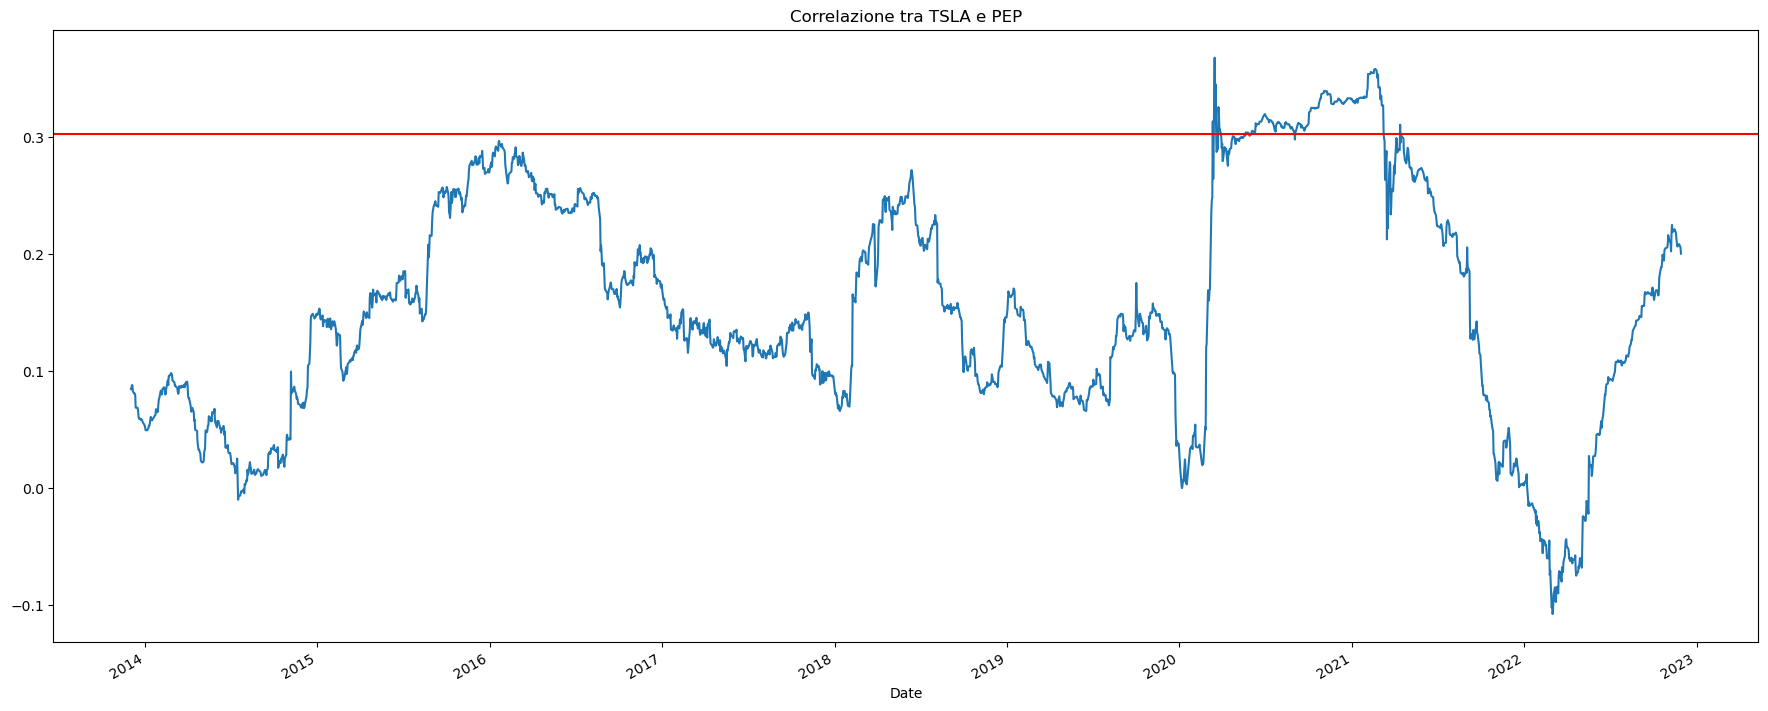

In [41]:
# correlazione tra Tesla e PEP
ax = df_log["TSLA"].rolling(window=252).corr(df_log["PEP"]).plot (figsize=(22,9), title = "Correlazione tra TSLA e PEP")
ax.axhline(df_log.corr().iloc[0,1], c='r');

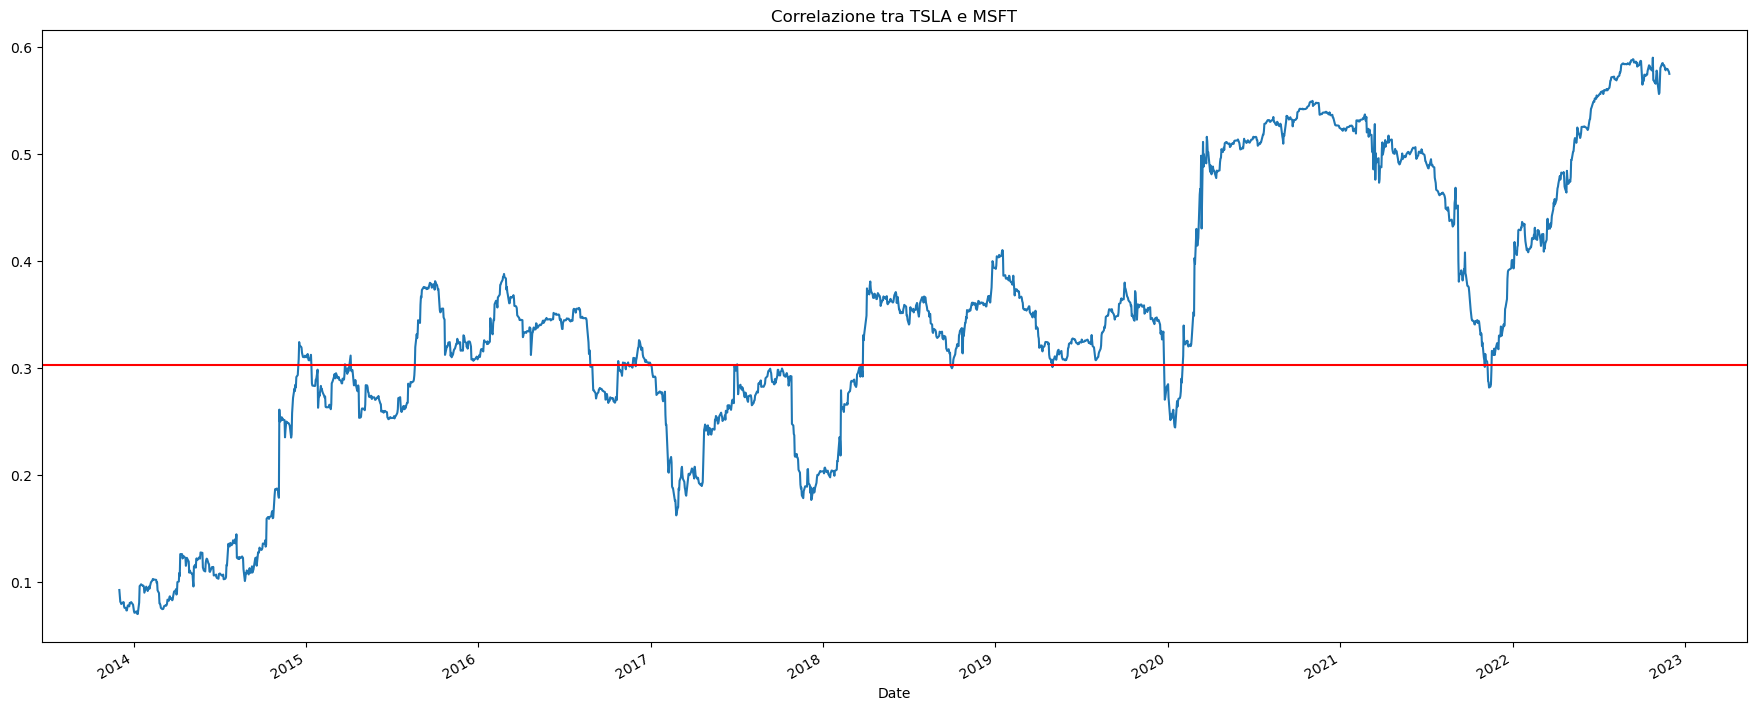

In [42]:
# correlazione tra Tesla e MSFT
ax = df_log["TSLA"].rolling(window=252).corr(df_log["MSFT"]).plot (figsize=(22,9), title = "Correlazione tra TSLA e MSFT")
ax.axhline(df_log.corr().iloc[0,1], c='r');

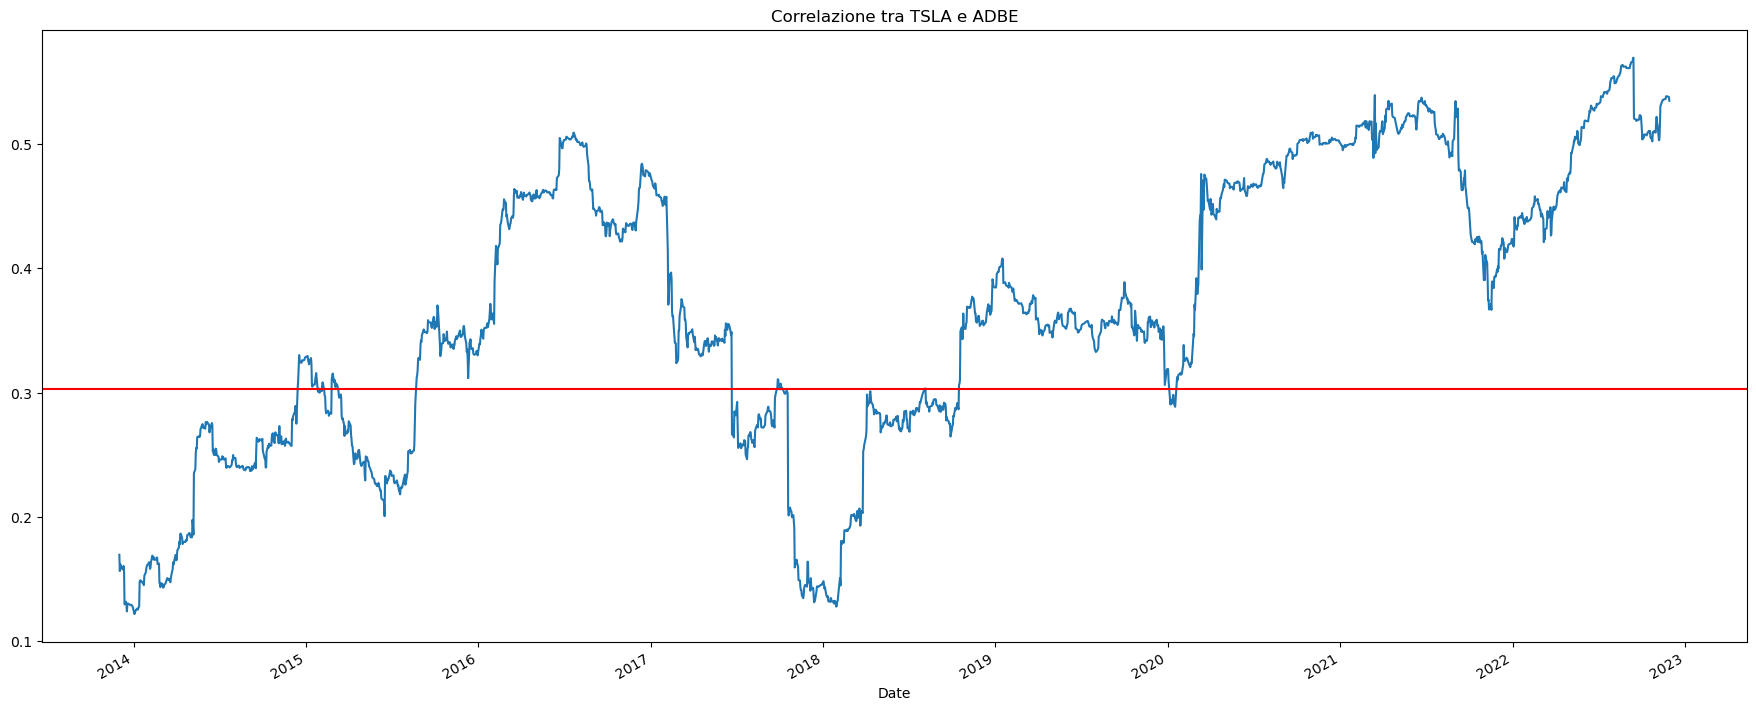

In [43]:
# correlazione tra Tesla e ADBE
ax = df_log["TSLA"].rolling(window=252).corr(df_log["ADBE"]).plot (figsize=(22,9), title = "Correlazione tra TSLA e ADBE")
ax.axhline(df_log.corr().iloc[0,1], c='r');

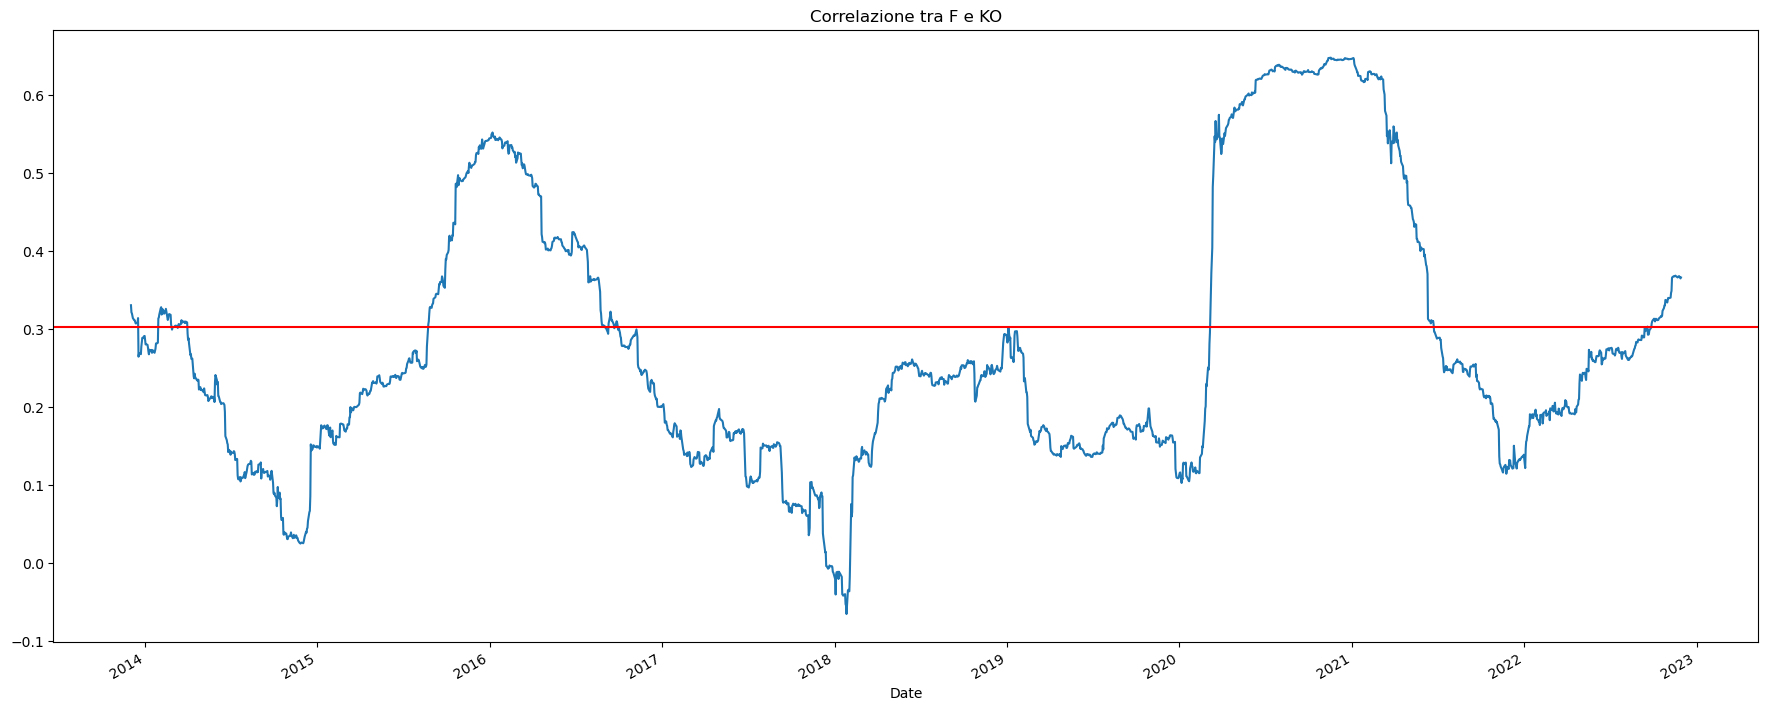

In [44]:
# correlazione tra F e KO
ax = df_log["F"].rolling(window=252).corr(df_log["KO"]).plot (figsize=(22,9), title = "Correlazione tra F e KO")
ax.axhline(df_log.corr().iloc[0,1], c='r');

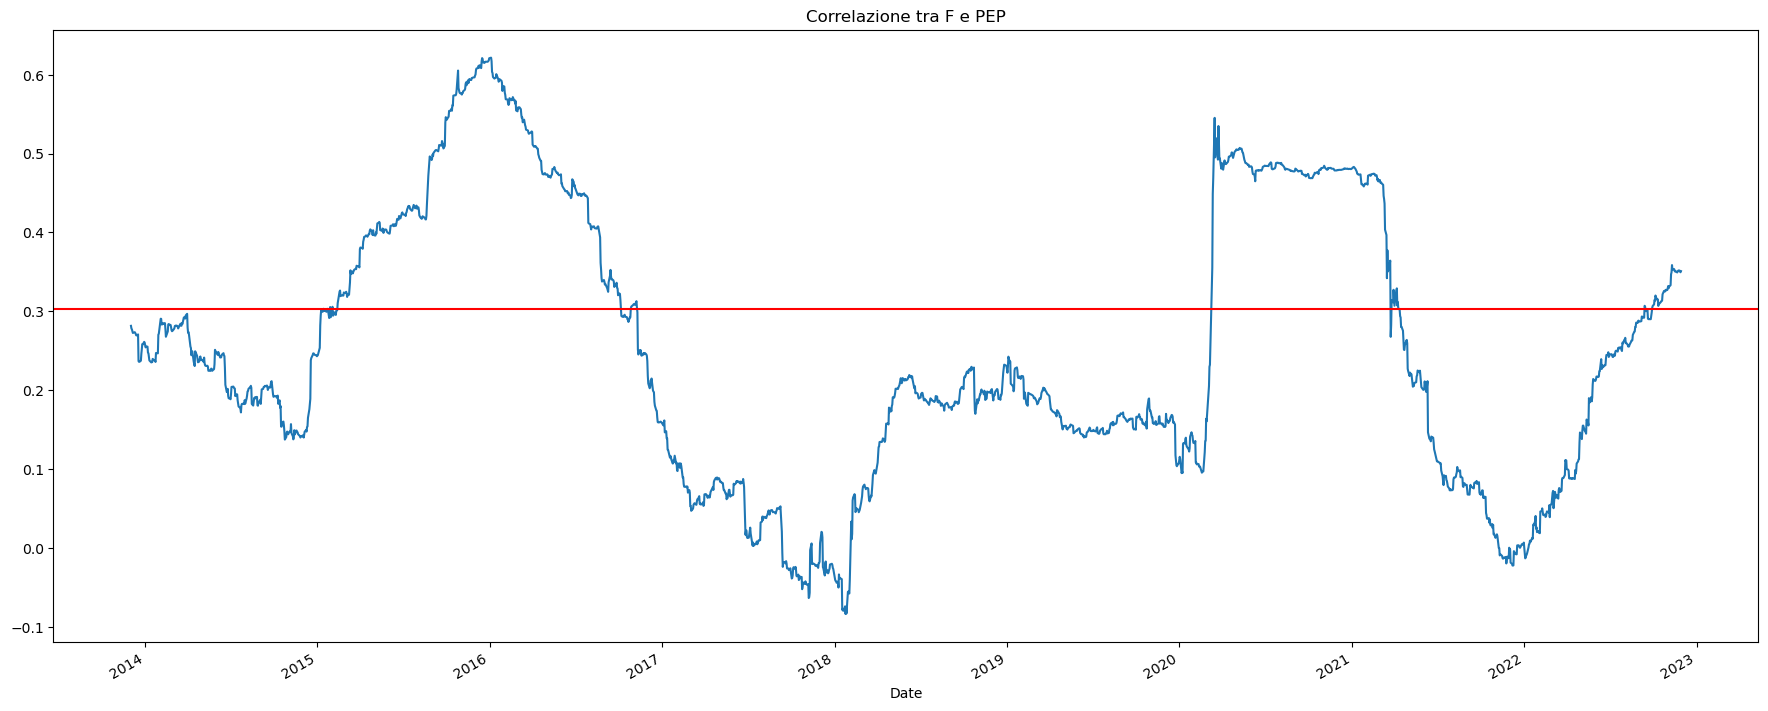

In [45]:
# correlazione tra F e PEP
ax = df_log["F"].rolling(window=252).corr(df_log["PEP"]).plot (figsize=(22,9), title = "Correlazione tra F e PEP")
ax.axhline(df_log.corr().iloc[0,1], c='r');

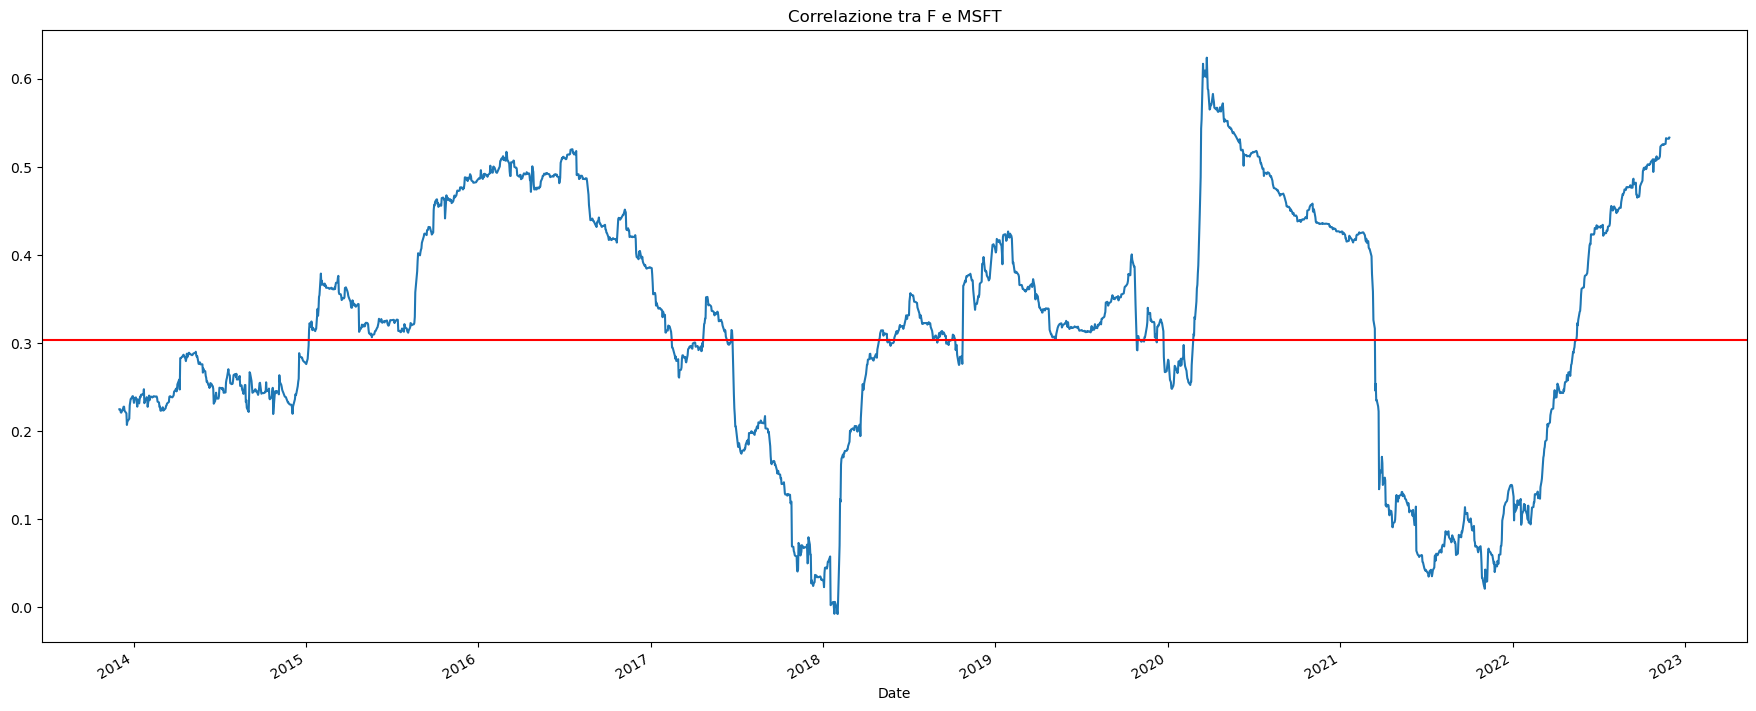

In [46]:
# correlazione tra F e MSFT
ax = df_log["F"].rolling(window=252).corr(df_log["MSFT"]).plot (figsize=(22,9), title = "Correlazione tra F e MSFT")
ax.axhline(df_log.corr().iloc[0,1], c='r');

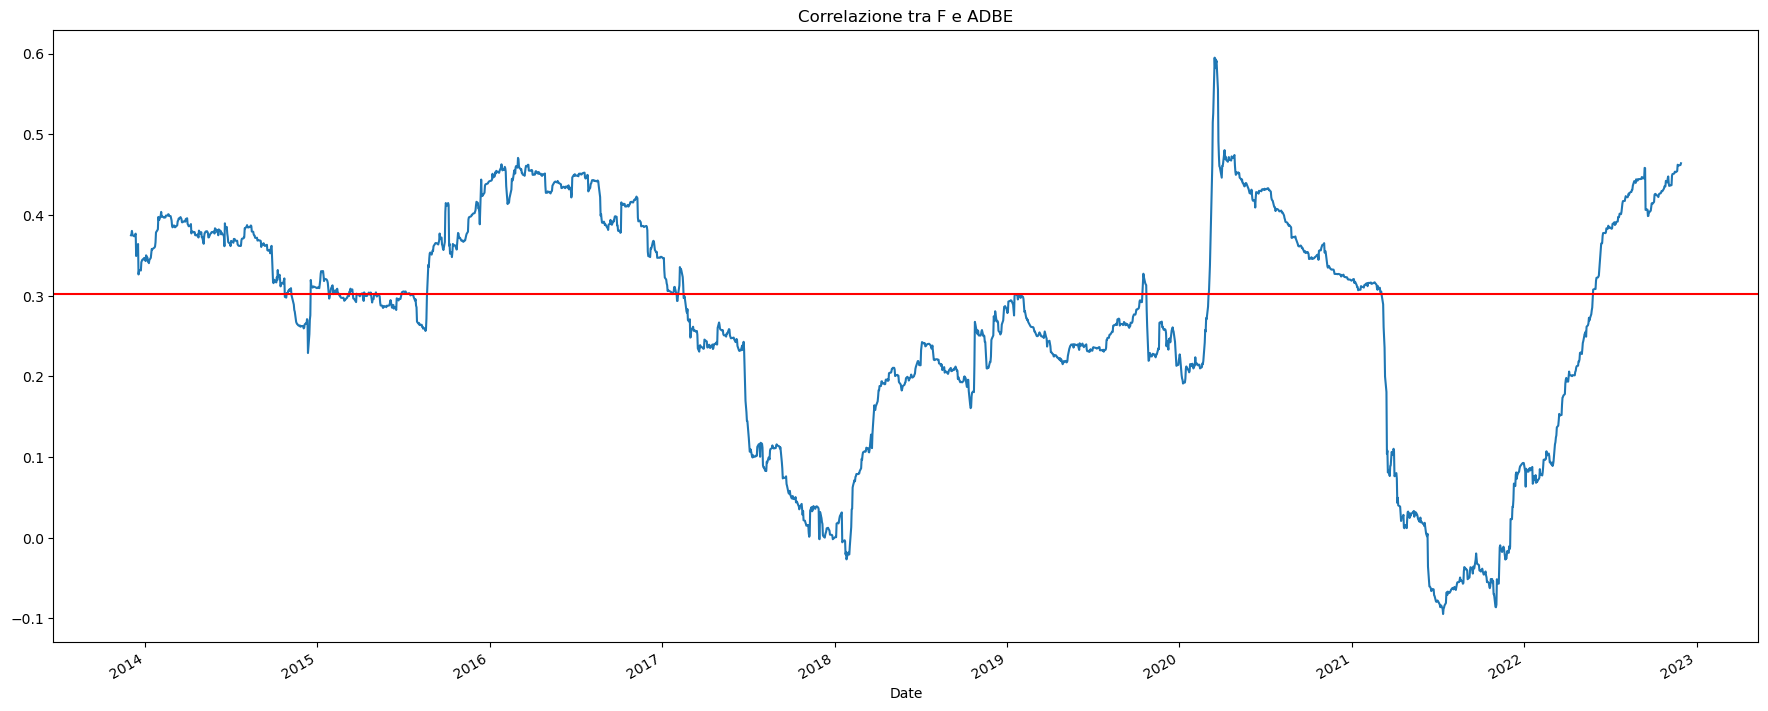

In [47]:
# correlazione tra F e ADBE
ax = df_log["F"].rolling(window=252).corr(df_log["ADBE"]).plot (figsize=(22,9), title = "Correlazione tra F e ADBE")
ax.axhline(df_log.corr().iloc[0,1], c='r');

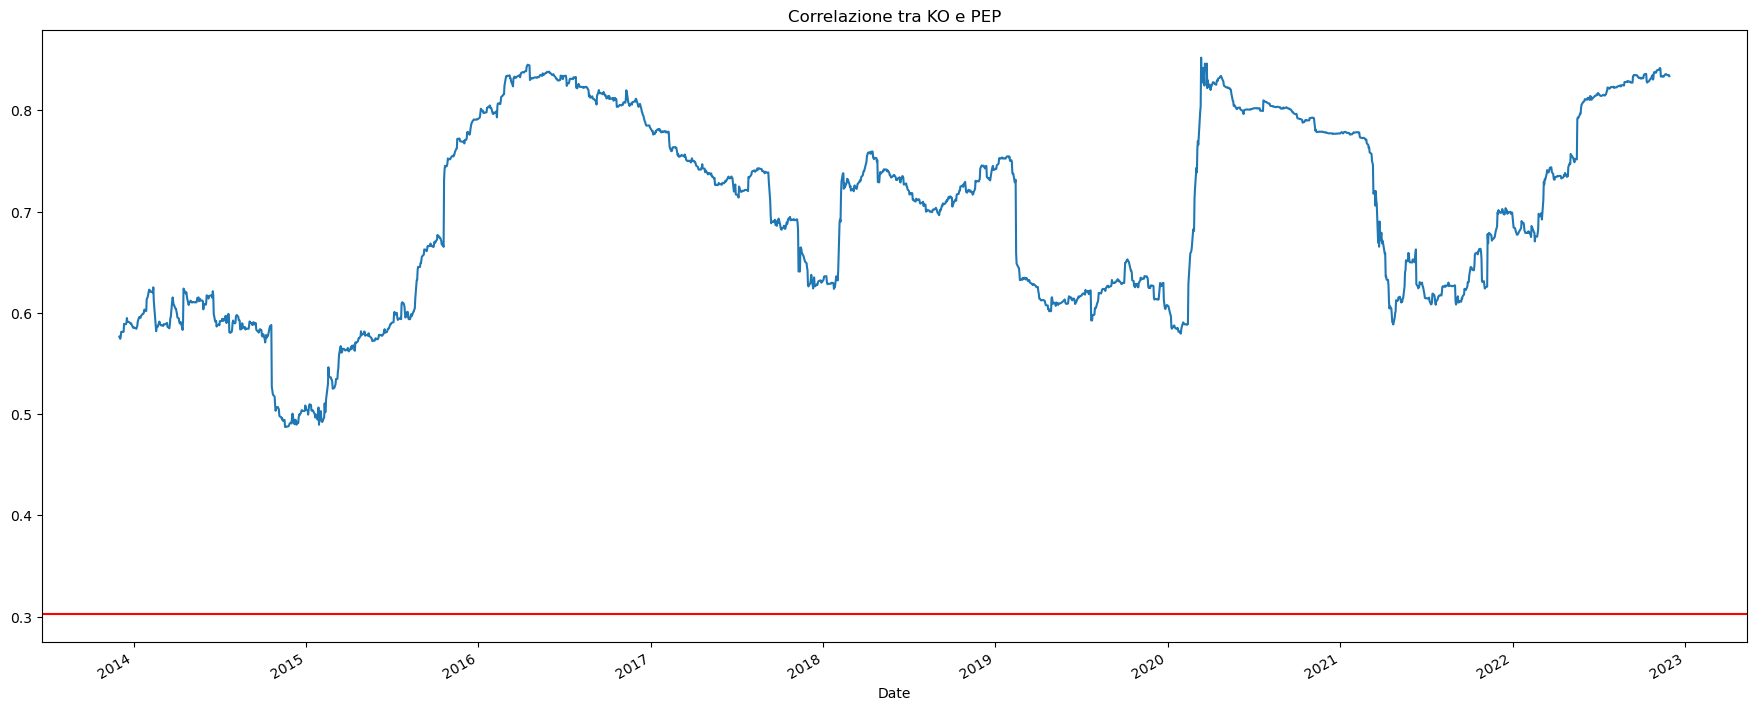

In [48]:
# correlazione tra KO e PEP
ax = df_log["KO"].rolling(window=252).corr(df_log["PEP"]).plot (figsize=(22,9), title = "Correlazione tra KO e PEP")
ax.axhline(df_log.corr().iloc[0,1], c='r');

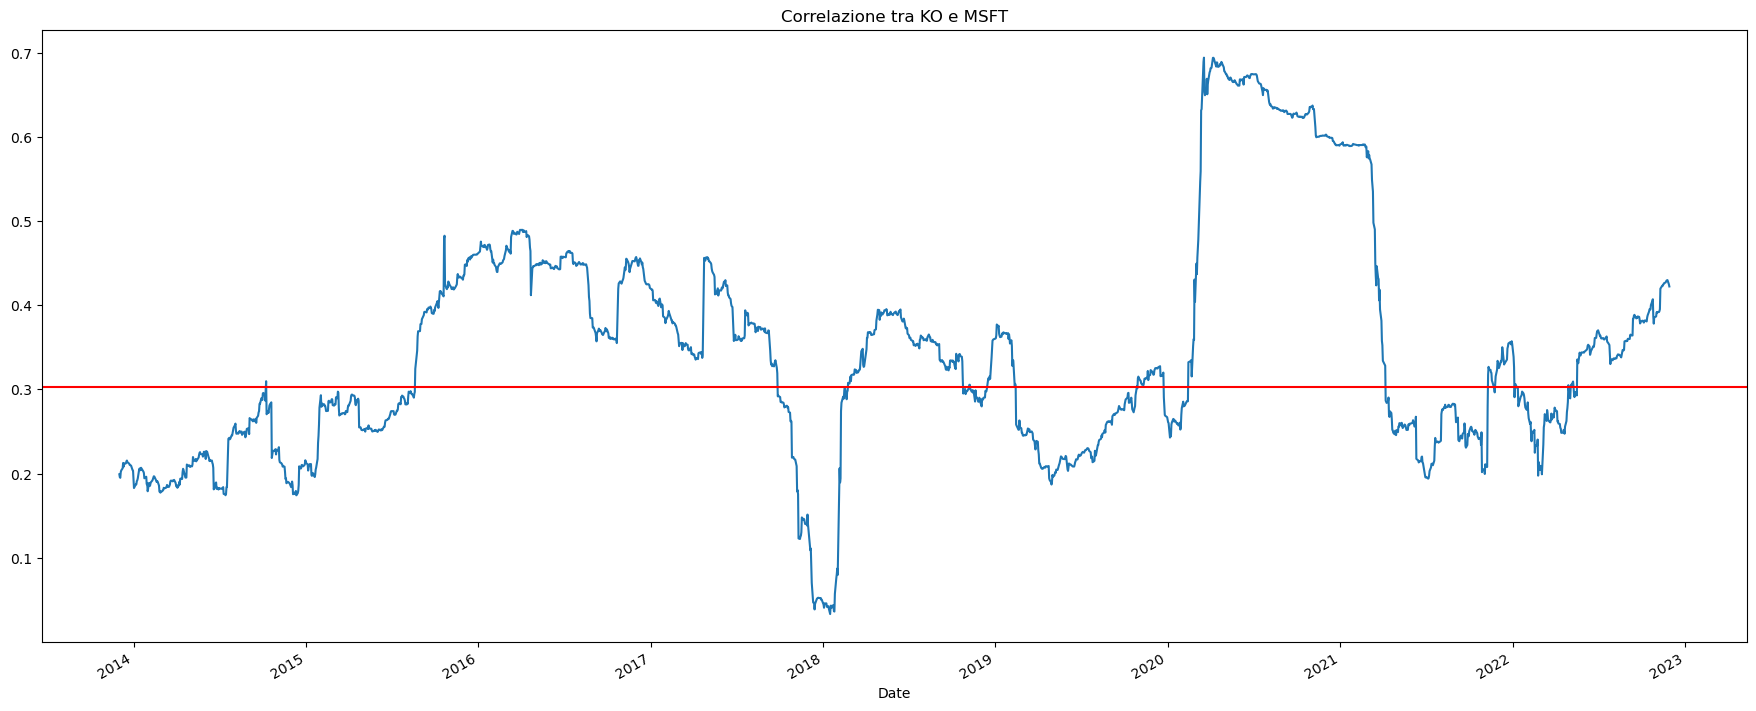

In [49]:
# correlazione tra KO e MSFT
ax = df_log["KO"].rolling(window=252).corr(df_log["MSFT"]).plot (figsize=(22,9), title = "Correlazione tra KO e MSFT")
ax.axhline(df_log.corr().iloc[0,1], c='r');

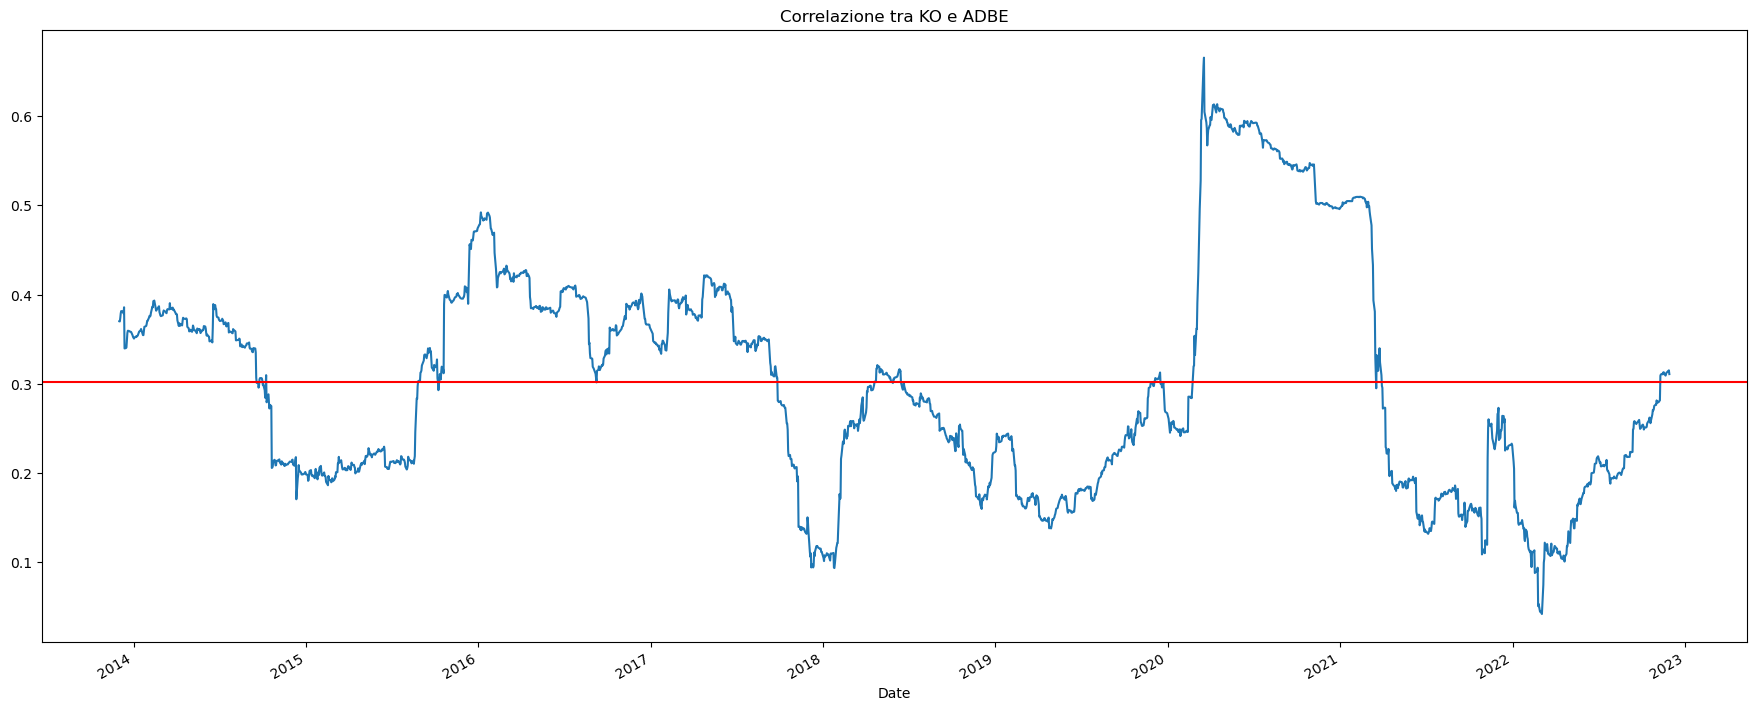

In [50]:
# correlazione tra KO e ADBE
ax = df_log["KO"].rolling(window=252).corr(df_log["ADBE"]).plot (figsize=(22,9), title = "Correlazione tra KO e ADBE")
ax.axhline(df_log.corr().iloc[0,1], c='r');

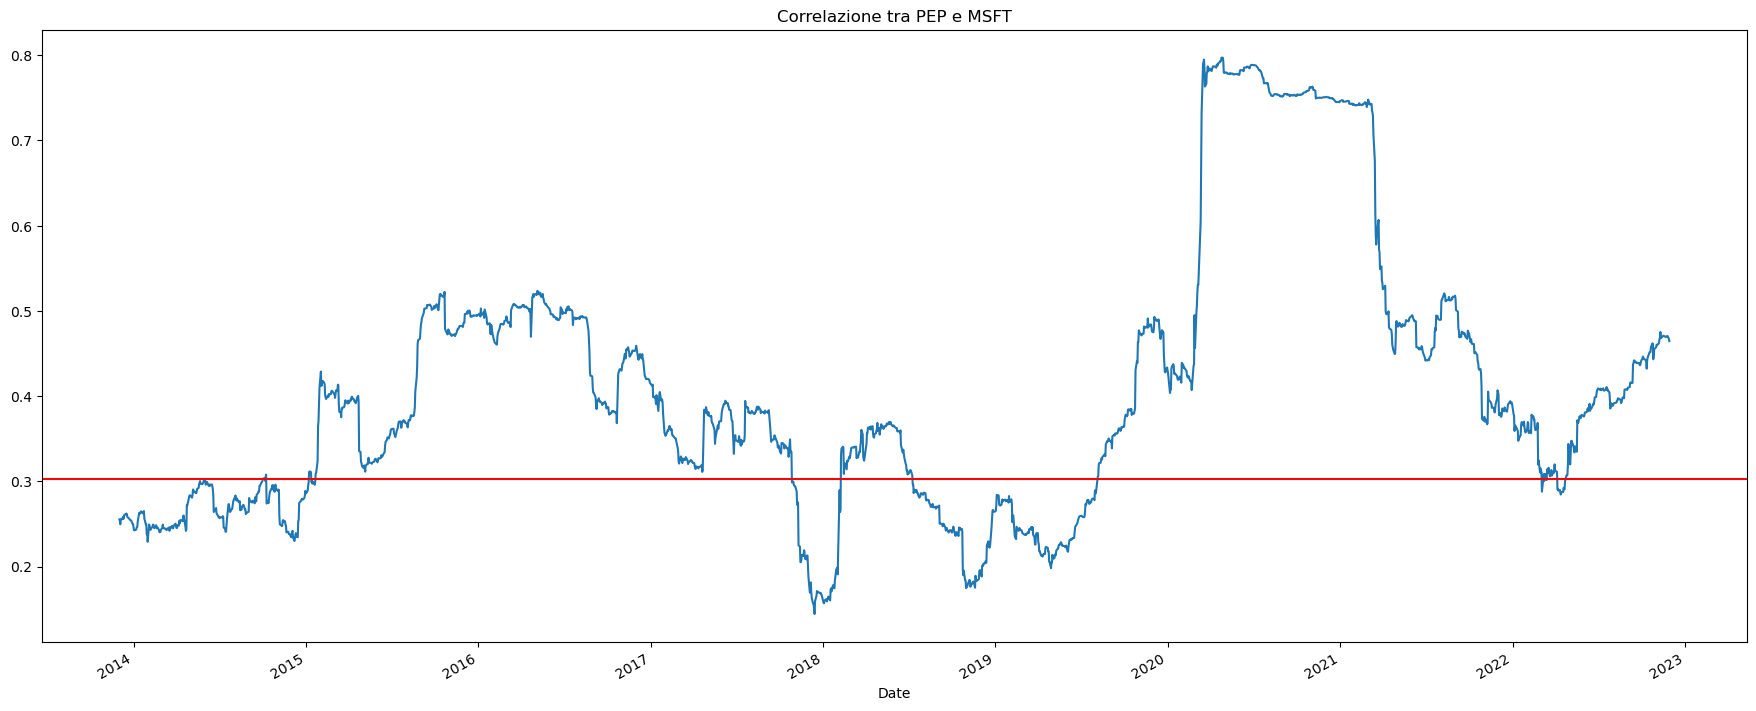

In [51]:
# correlazione tra PEP e MSFT
ax = df_log["PEP"].rolling(window=252).corr(df_log["MSFT"]).plot (figsize=(22,9), title = "Correlazione tra PEP e MSFT")
ax.axhline(df_log.corr().iloc[0,1], c='r');

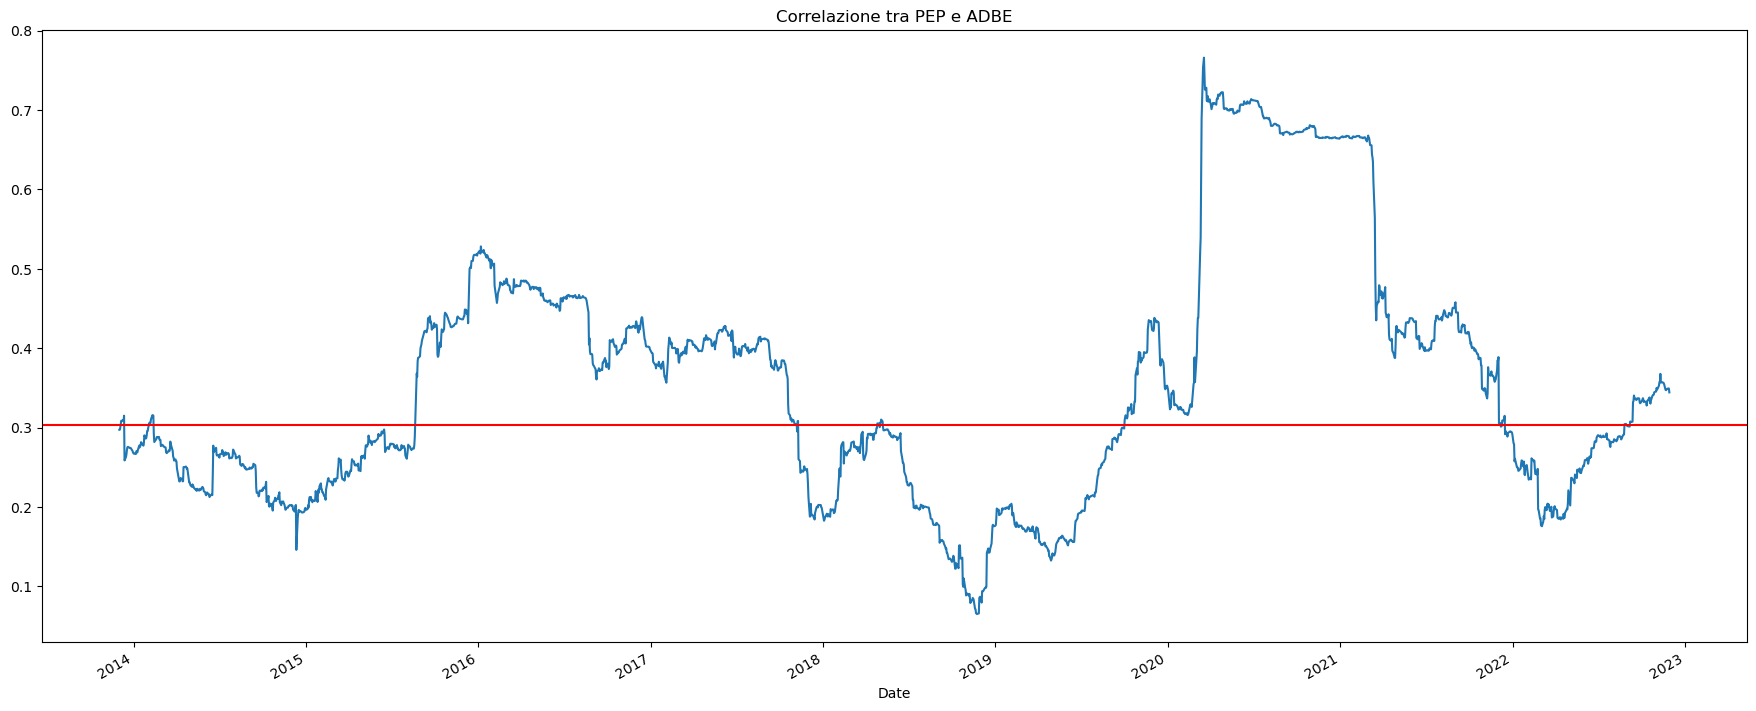

In [52]:
# correlazione tra PEP e ADBE
ax = df_log["PEP"].rolling(window=252).corr(df_log["ADBE"]).plot (figsize=(22,9), title = "Correlazione tra PEP e ADBE")
ax.axhline(df_log.corr().iloc[0,1], c='r');

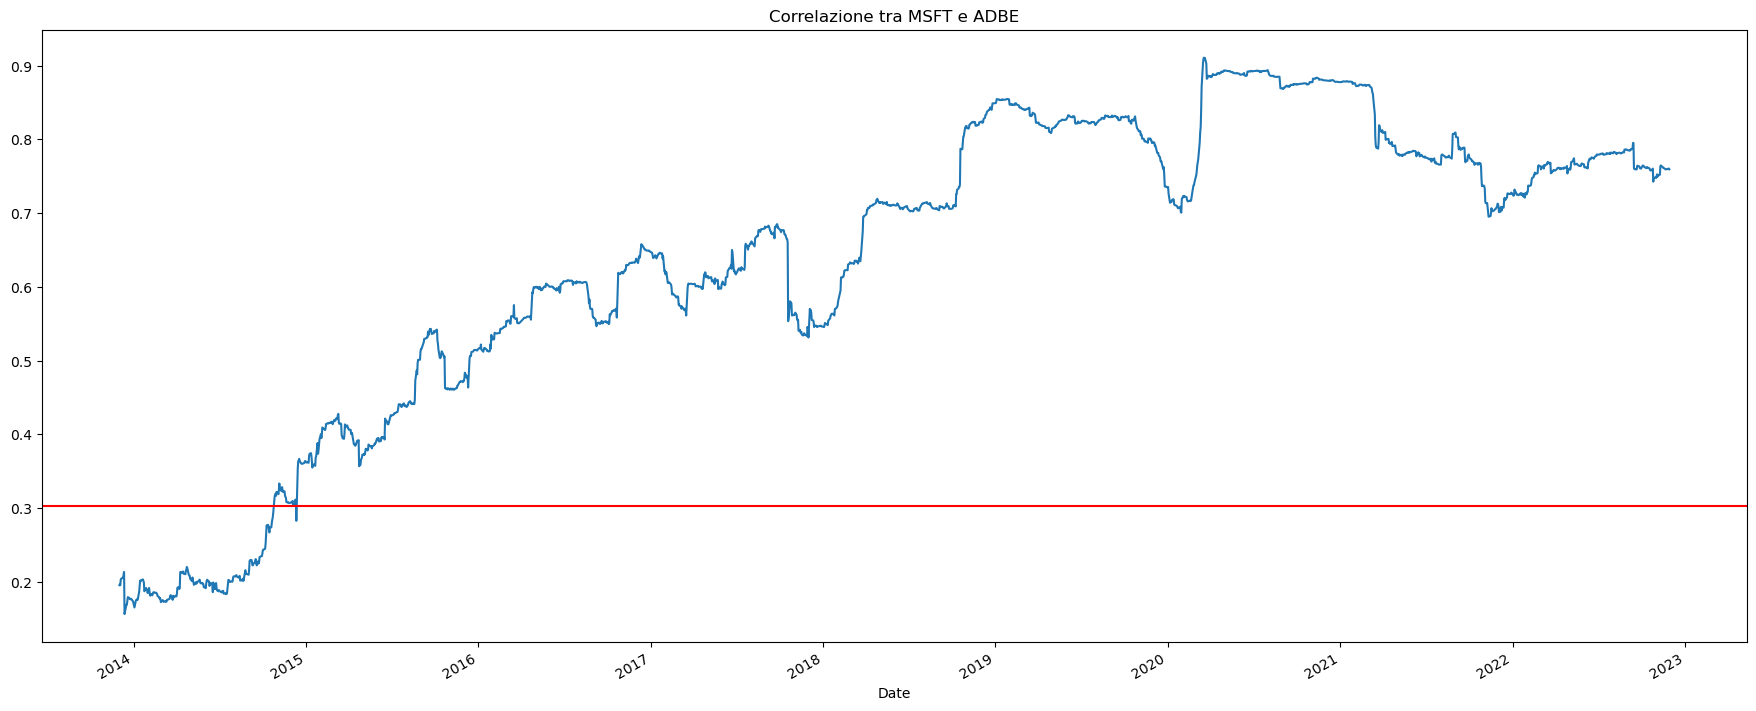

In [53]:
# correlazione tra MSFT e ADBE
ax = df_log["MSFT"].rolling(window=252).corr(df_log["ADBE"]).plot (figsize=(22,9), title = "Correlazione tra MSFT e ADBE")
ax.axhline(df_log.corr().iloc[0,1], c='r');

In [54]:
reg = np.polyfit(df_log['TSLA'], df_log['F'], deg=1)

Text(0.5, 1.0, 'TSLA - F')

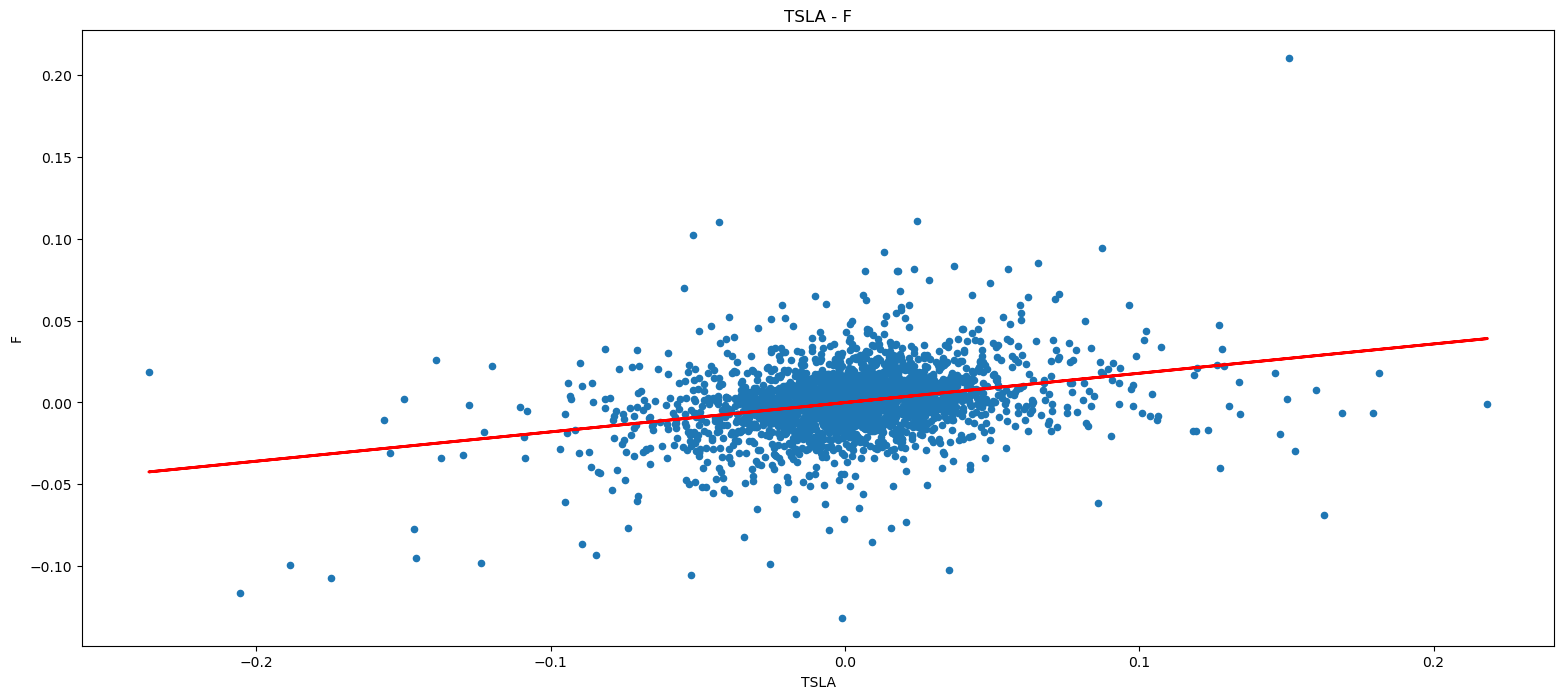

In [55]:
ax = df_log.plot(kind = 'scatter', x = 'TSLA', y= 'F', figsize=(19,8))
ax.plot(df_log['TSLA'], np.polyval(reg, df_log['TSLA']), 'r', lw=2);
ax.set_title("TSLA - F")

In [56]:
reg = np.polyfit(df_log['TSLA'], df_log['KO'], deg=1)

Text(0.5, 1.0, 'TSLA - KO')

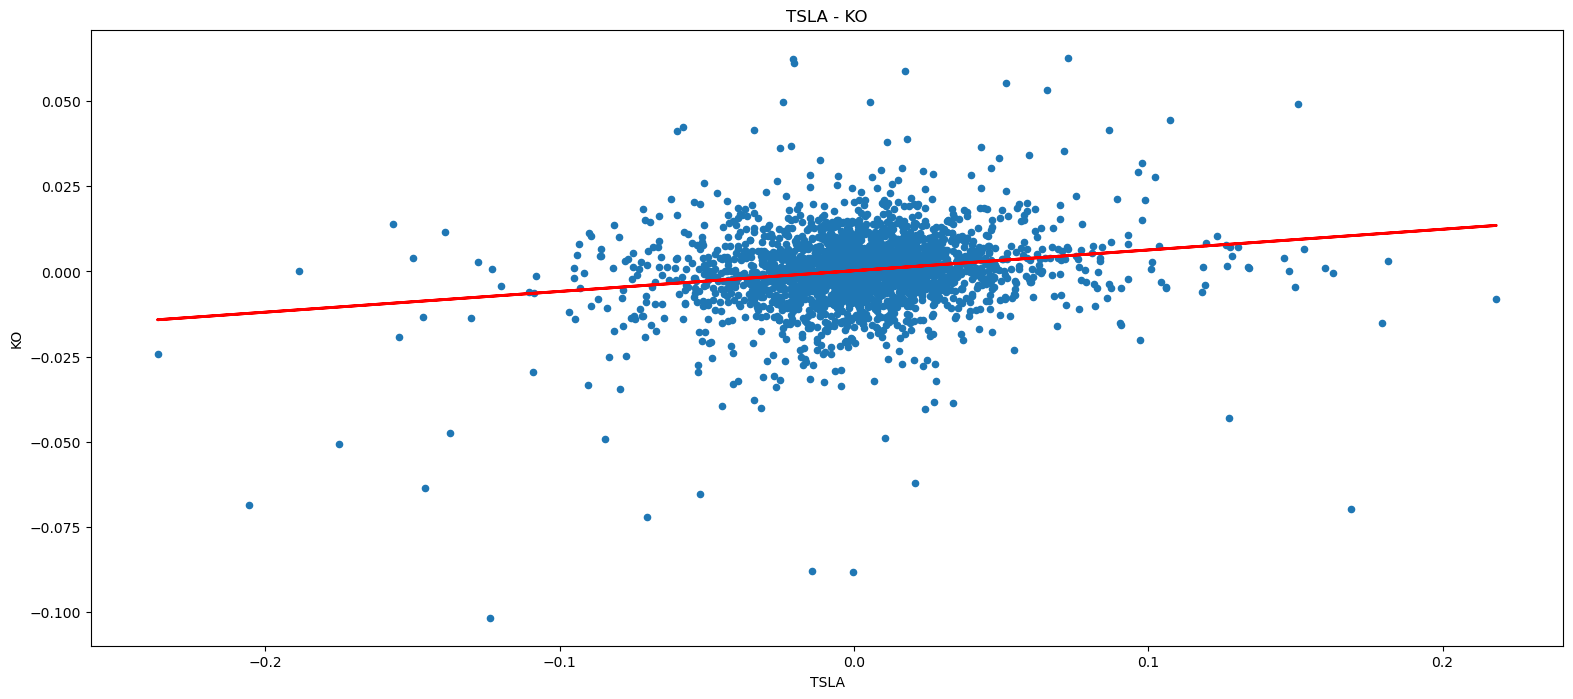

In [57]:
ax = df_log.plot(kind = 'scatter', x = 'TSLA', y= 'KO', figsize=(19,8))
ax.plot(df_log['TSLA'], np.polyval(reg, df_log['TSLA']), 'r', lw=2);
ax.set_title("TSLA - KO")

In [58]:
reg = np.polyfit(df_log['TSLA'], df_log['PEP'], deg=1)

Text(0.5, 1.0, 'TSLA - PEP')

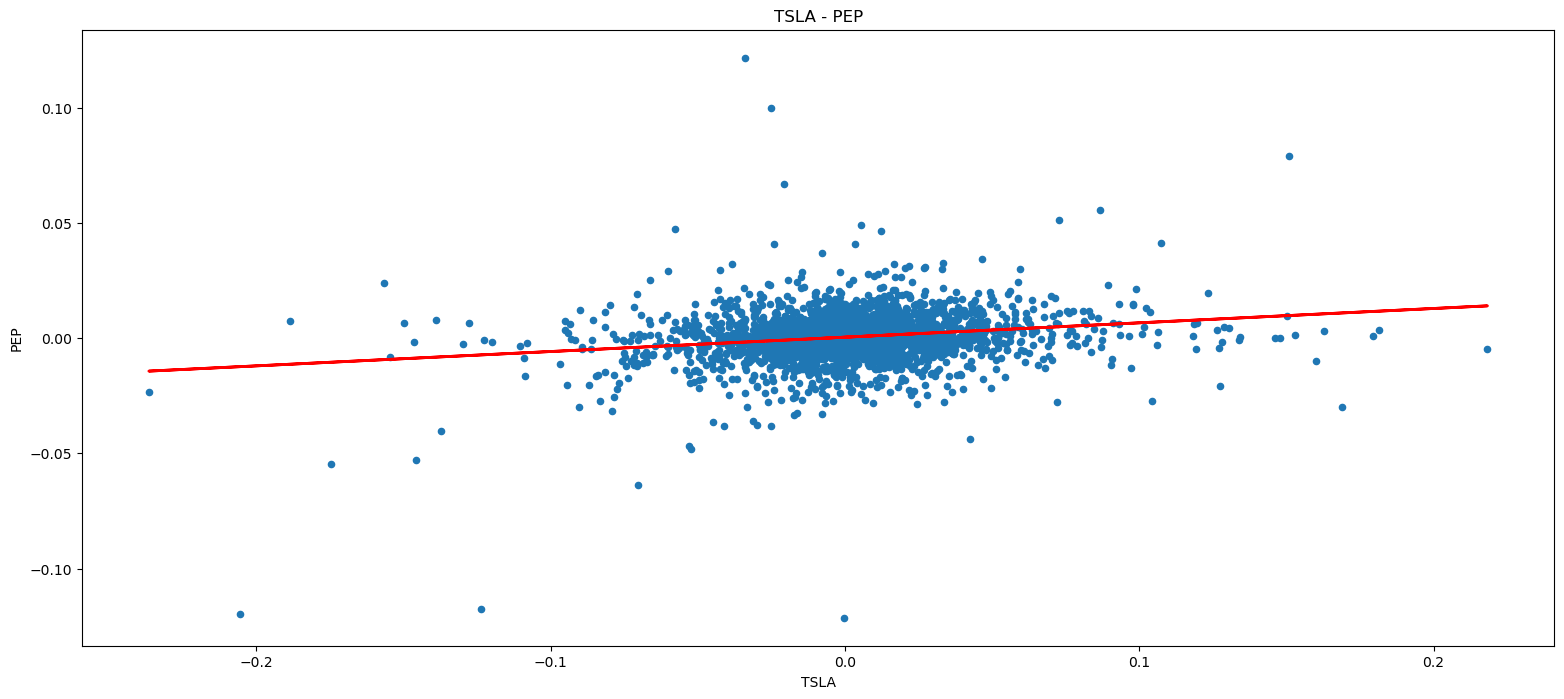

In [59]:
ax = df_log.plot(kind = 'scatter', x = 'TSLA', y= 'PEP', figsize=(19,8))
ax.plot(df_log['TSLA'], np.polyval(reg, df_log['TSLA']), 'r', lw=2);
ax.set_title("TSLA - PEP")

In [60]:
reg = np.polyfit(df_log['TSLA'], df_log['MSFT'], deg=1)

Text(0.5, 1.0, 'TSLA - MSFT')

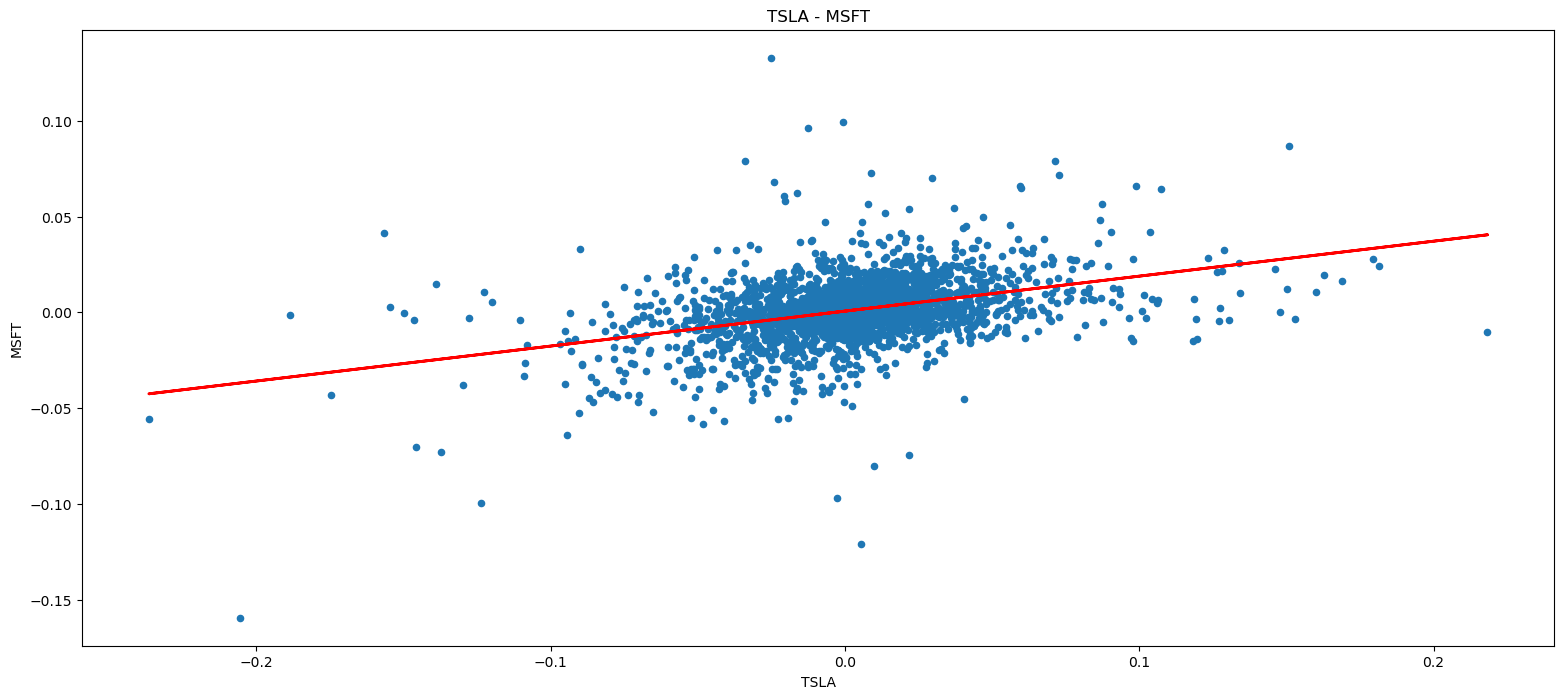

In [61]:
ax = df_log.plot(kind = 'scatter', x = 'TSLA', y= 'MSFT', figsize=(19,8))
ax.plot(df_log['TSLA'], np.polyval(reg, df_log['TSLA']), 'r', lw=2);
ax.set_title("TSLA - MSFT")

In [62]:
reg = np.polyfit(df_log['TSLA'], df_log['ADBE'], deg=1)

Text(0.5, 1.0, 'TSLA - ADBE')

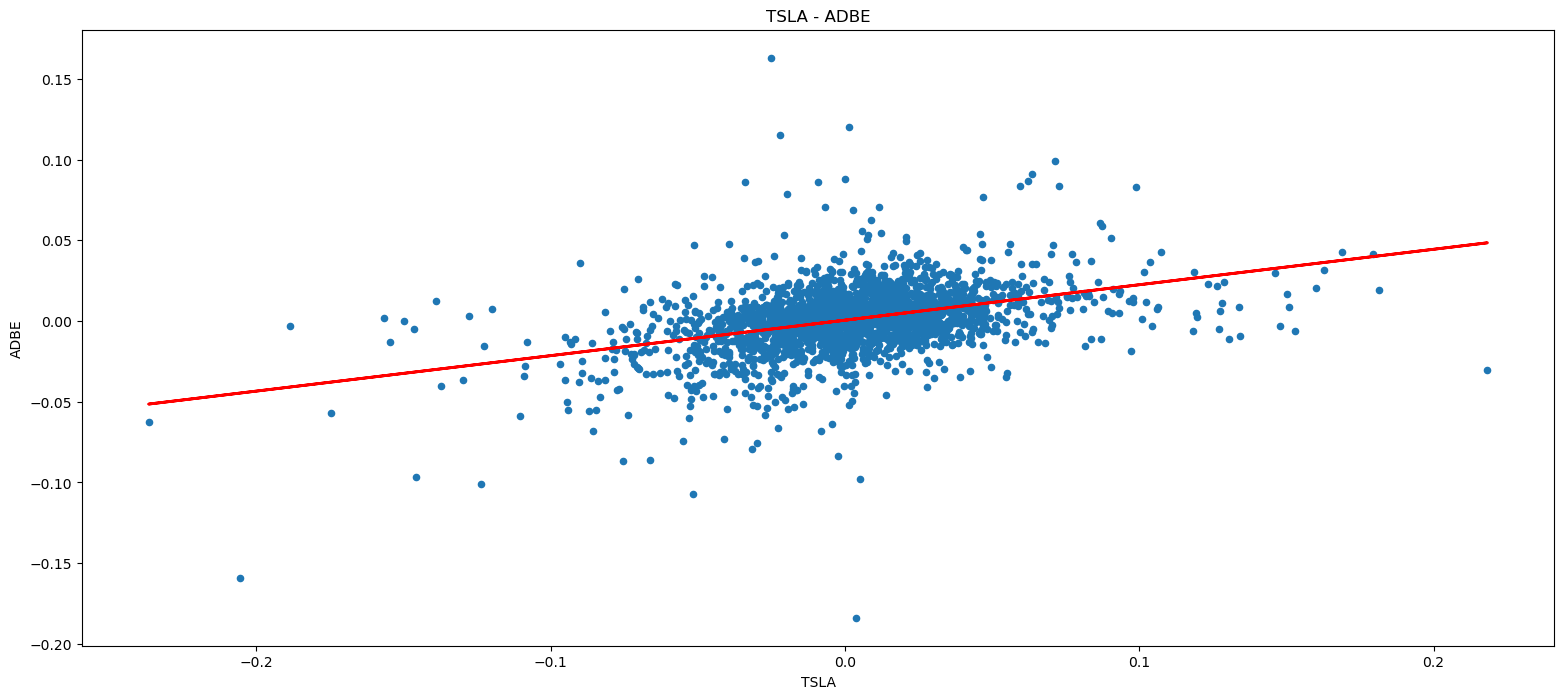

In [63]:
ax = df_log.plot(kind = 'scatter', x = 'TSLA', y= 'ADBE', figsize=(19,8))
ax.plot(df_log['TSLA'], np.polyval(reg, df_log['TSLA']), 'r', lw=2);
ax.set_title("TSLA - ADBE")

In [64]:
reg = np.polyfit(df_log['F'], df_log['KO'], deg=1)

Text(0.5, 1.0, 'F - KO')

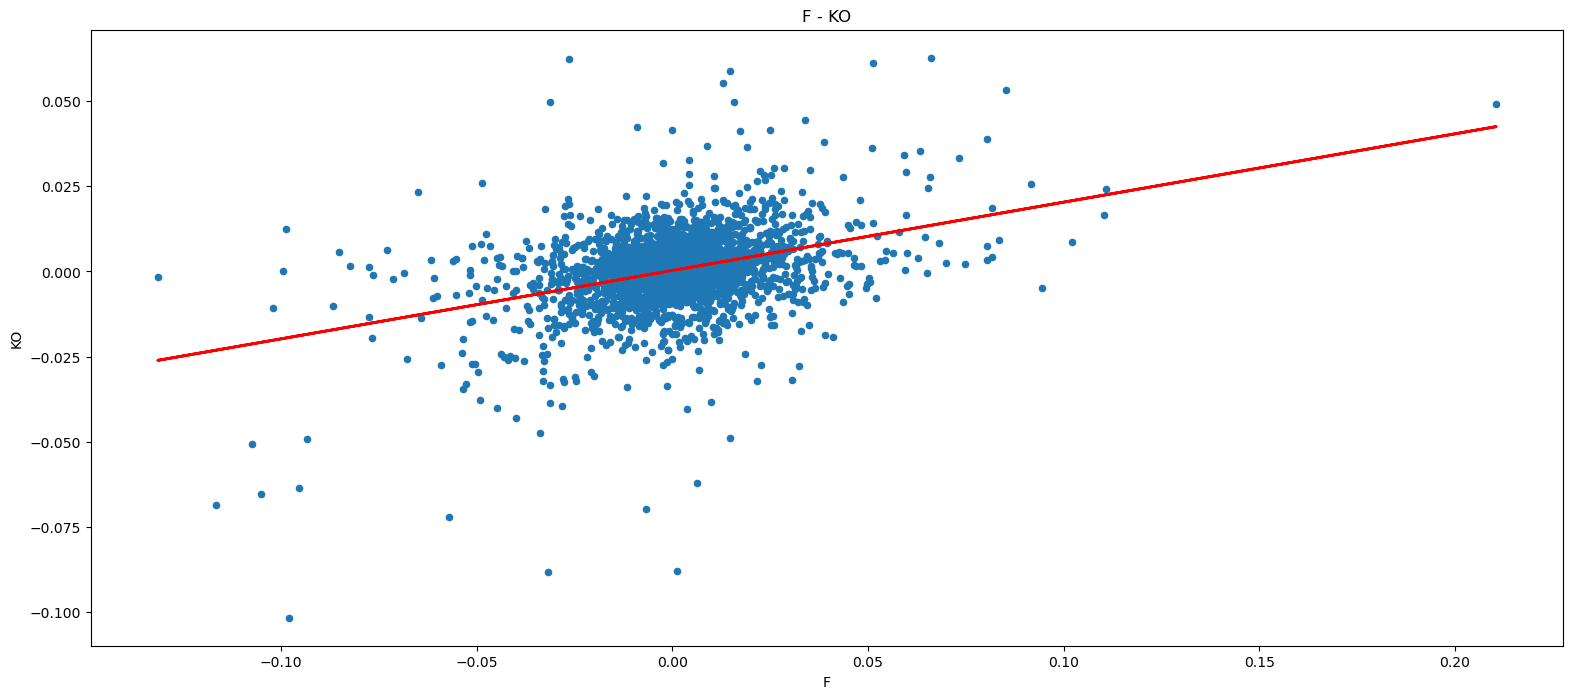

In [65]:
ax = df_log.plot(kind = 'scatter', x = 'F', y= 'KO', figsize=(19,8))
ax.plot(df_log['F'], np.polyval(reg, df_log['F']), 'r', lw=2);
ax.set_title("F - KO")

In [66]:
reg = np.polyfit(df_log['F'], df_log['PEP'], deg=1)

Text(0.5, 1.0, 'F - PEP')

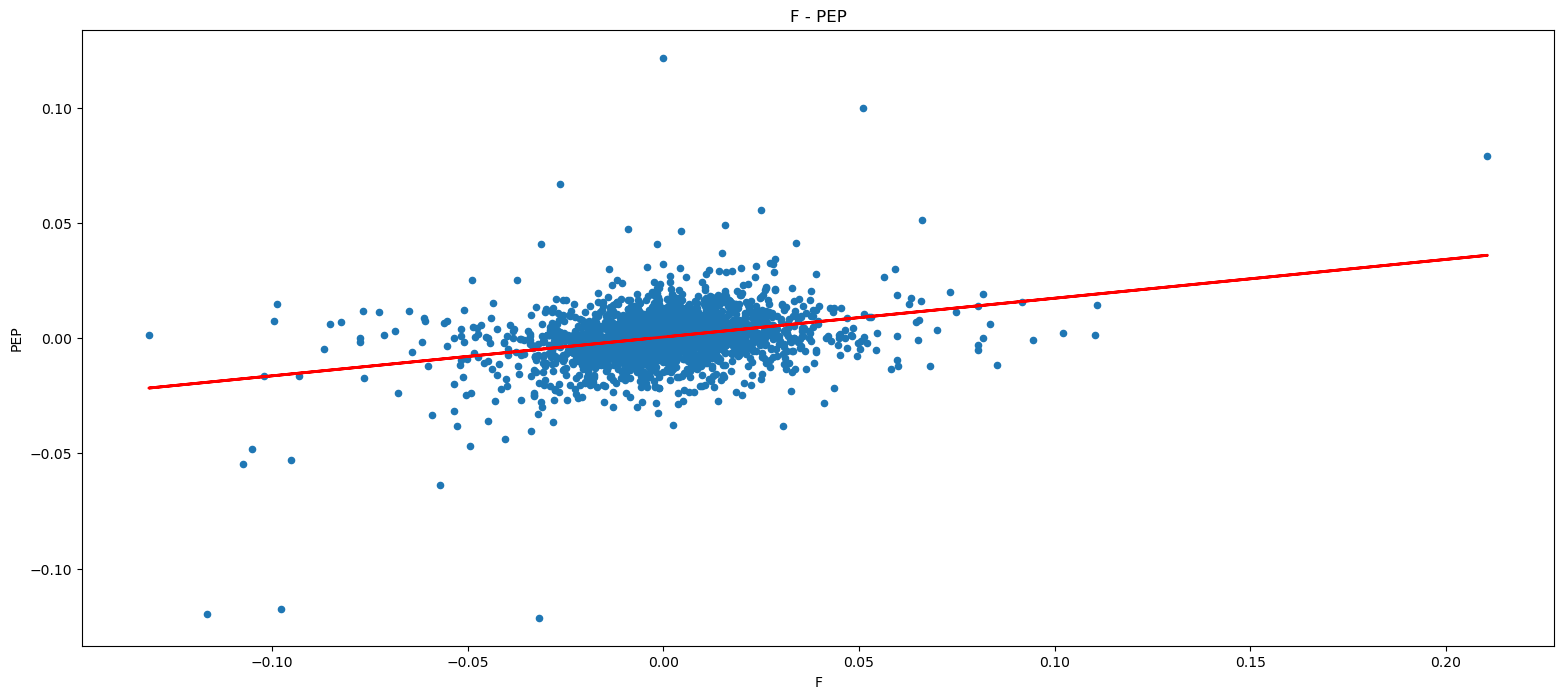

In [67]:
ax = df_log.plot(kind = 'scatter', x = 'F', y= 'PEP', figsize=(19,8))
ax.plot(df_log['F'], np.polyval(reg, df_log['F']), 'r', lw=2);
ax.set_title("F - PEP")

In [68]:
reg = np.polyfit(df_log['F'], df_log['MSFT'], deg=1)

Text(0.5, 1.0, 'F - MSFT')

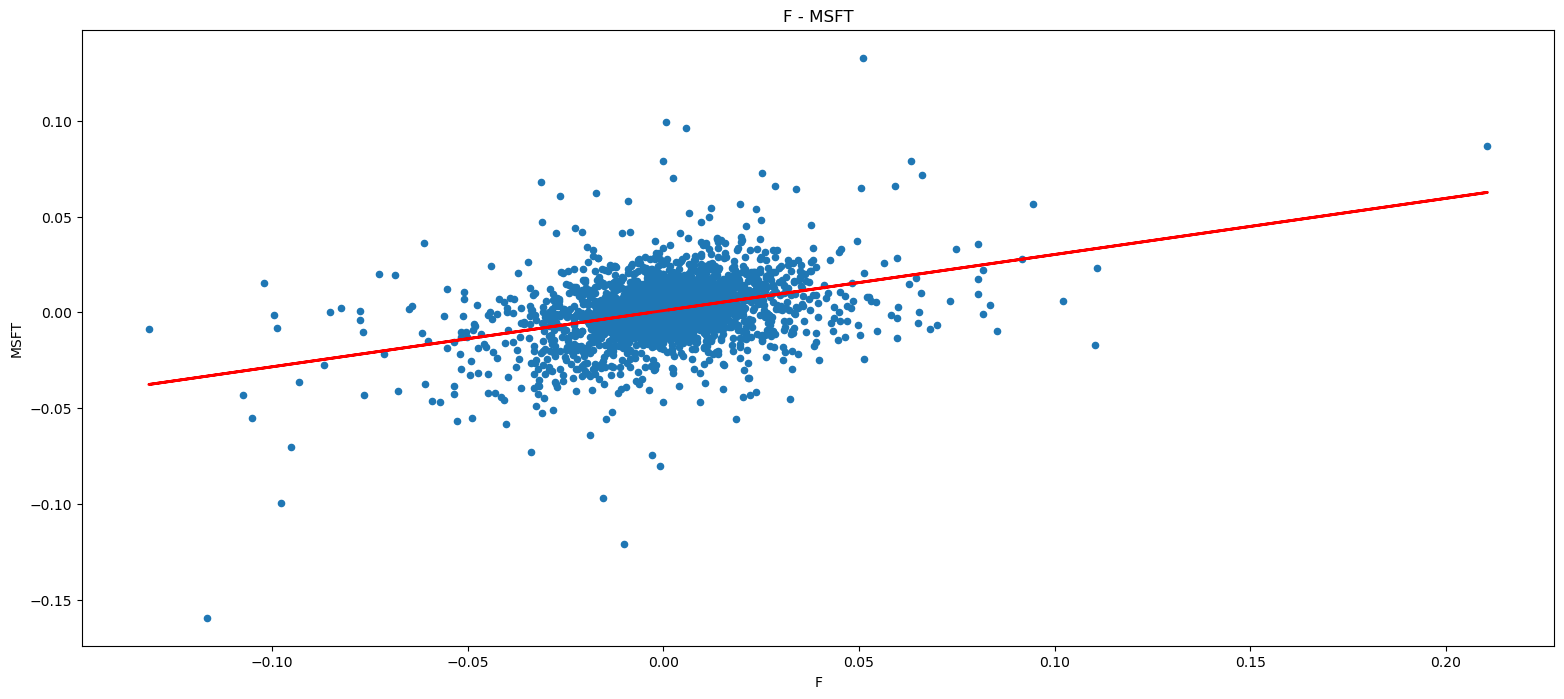

In [69]:
ax = df_log.plot(kind = 'scatter', x = 'F', y= 'MSFT', figsize=(19,8))
ax.plot(df_log['F'], np.polyval(reg, df_log['F']), 'r', lw=2);
ax.set_title("F - MSFT")

In [70]:
reg = np.polyfit(df_log['F'], df_log['ADBE'], deg=1)

Text(0.5, 1.0, 'F - ADBE')

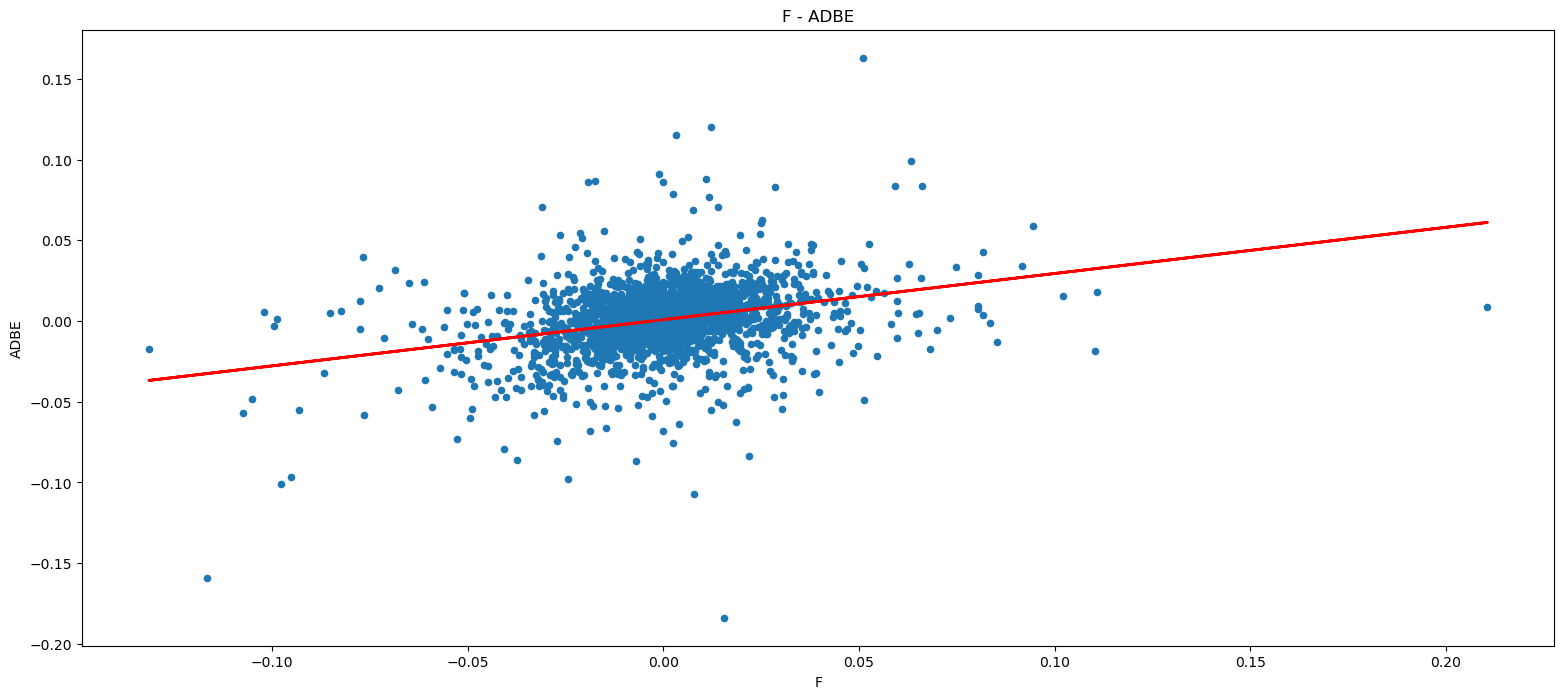

In [71]:
ax = df_log.plot(kind = 'scatter', x = 'F', y= 'ADBE', figsize=(19,8))
ax.plot(df_log['F'], np.polyval(reg, df_log['F']), 'r', lw=2);
ax.set_title("F - ADBE")

In [72]:
reg = np.polyfit(df_log['KO'], df_log['PEP'], deg=1)

Text(0.5, 1.0, 'KO - PEP')

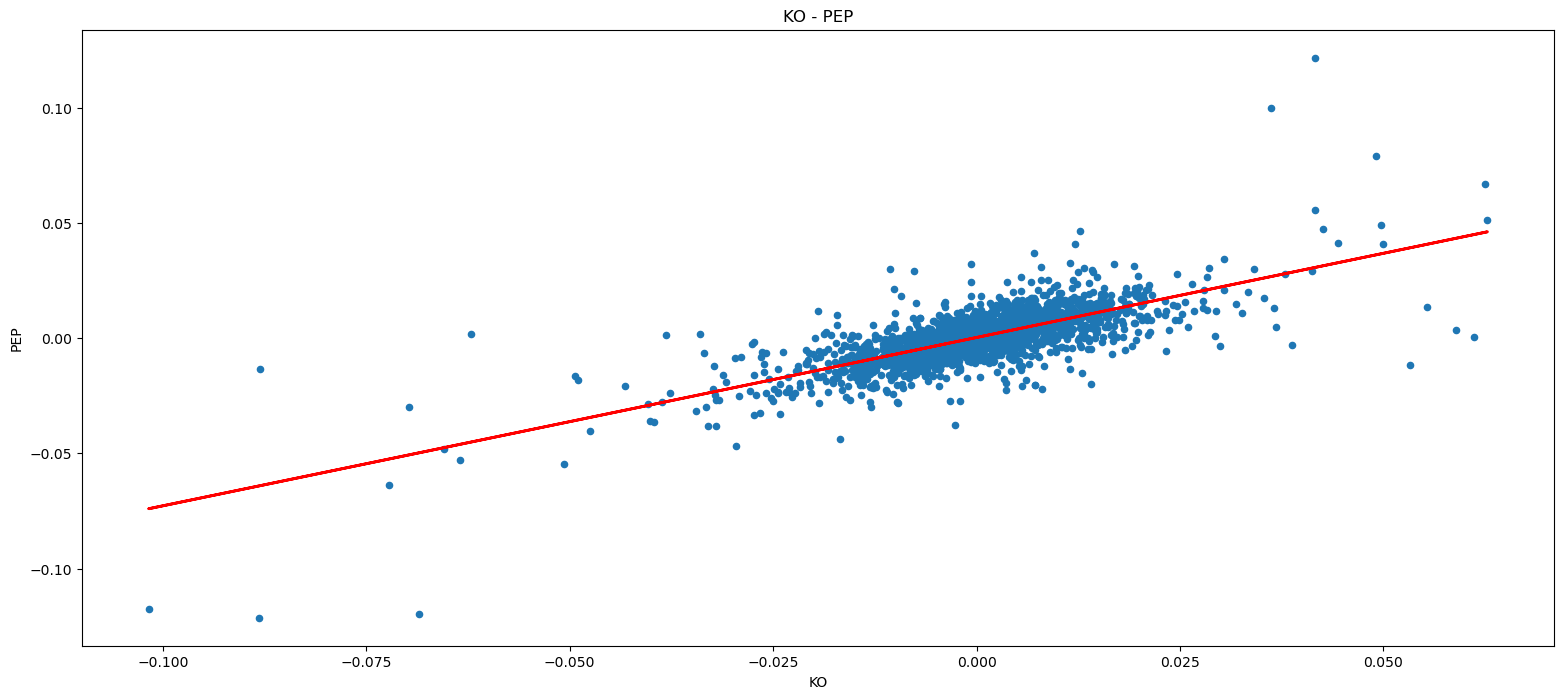

In [73]:
ax = df_log.plot(kind = 'scatter', x = 'KO', y= 'PEP', figsize=(19,8))
ax.plot(df_log['KO'], np.polyval(reg, df_log['KO']), 'r', lw=2);
ax.set_title("KO - PEP")

In [74]:
reg = np.polyfit(df_log['KO'], df_log['MSFT'], deg=1)

Text(0.5, 1.0, 'KO - MSFT')

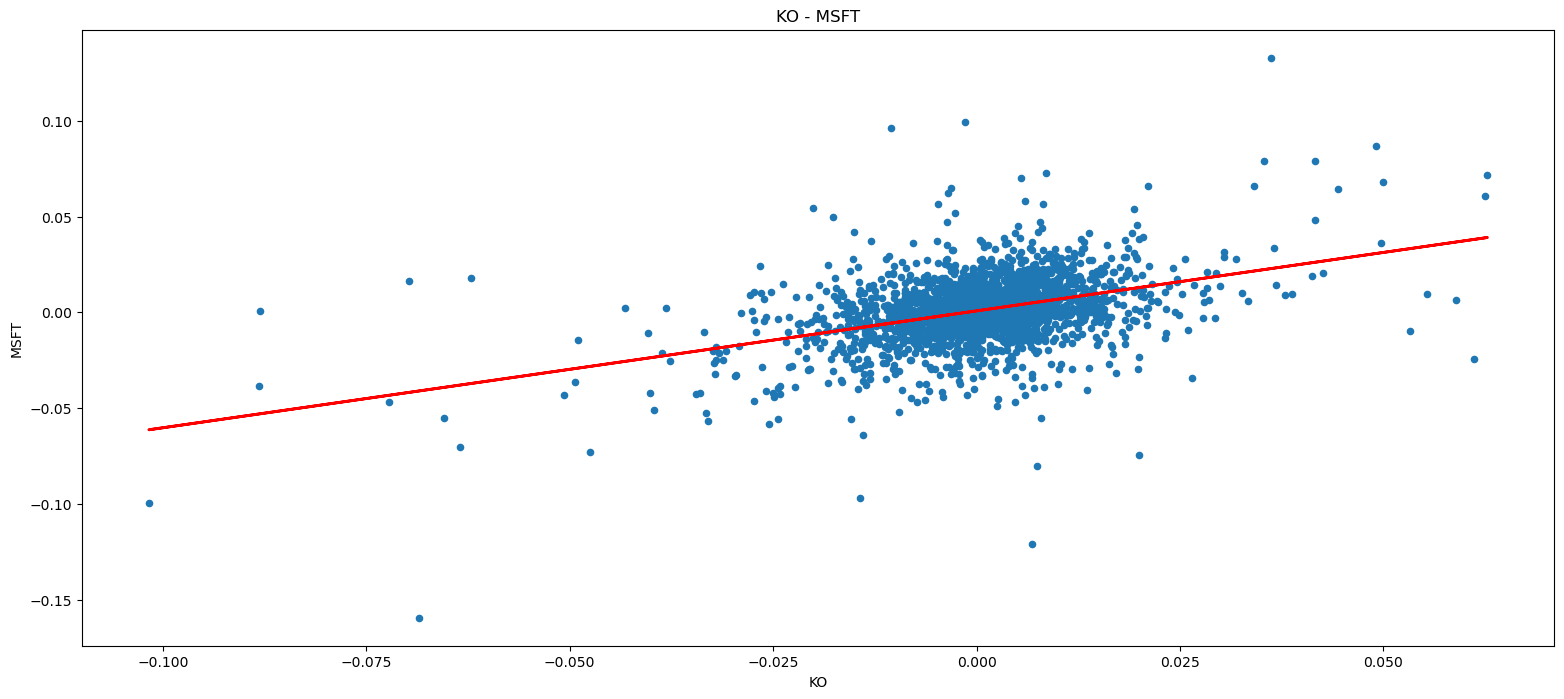

In [75]:
ax = df_log.plot(kind = 'scatter', x = 'KO', y= 'MSFT', figsize=(19,8))
ax.plot(df_log['KO'], np.polyval(reg, df_log['KO']), 'r', lw=2);
ax.set_title("KO - MSFT")

In [76]:
reg = np.polyfit(df_log['KO'], df_log['ADBE'], deg=1)

Text(0.5, 1.0, 'KO - ADBE')

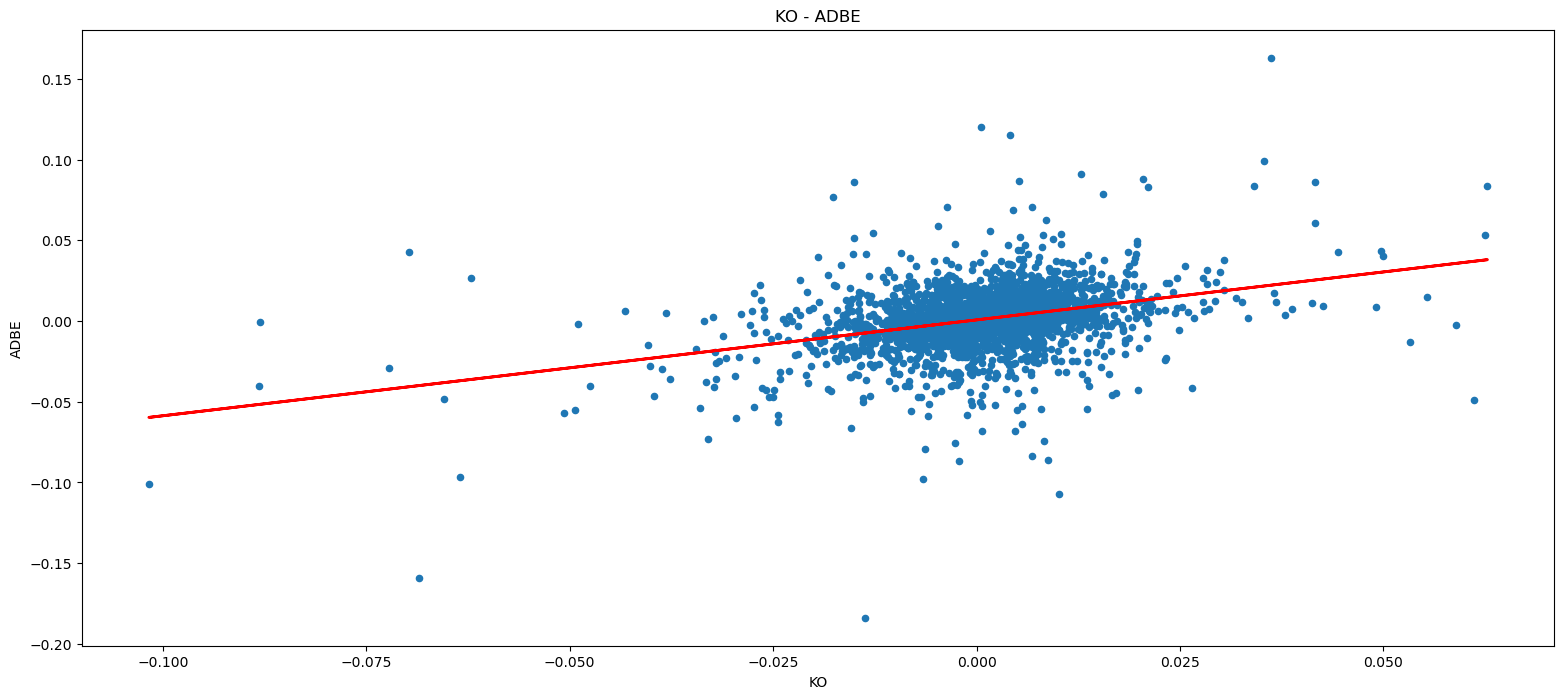

In [77]:
ax = df_log.plot(kind = 'scatter', x = 'KO', y= 'ADBE', figsize=(19,8))
ax.plot(df_log['KO'], np.polyval(reg, df_log['KO']), 'r', lw=2);
ax.set_title("KO - ADBE")

In [78]:
reg = np.polyfit(df_log['PEP'], df_log['MSFT'], deg=1)

Text(0.5, 1.0, 'PEP - MSFT')

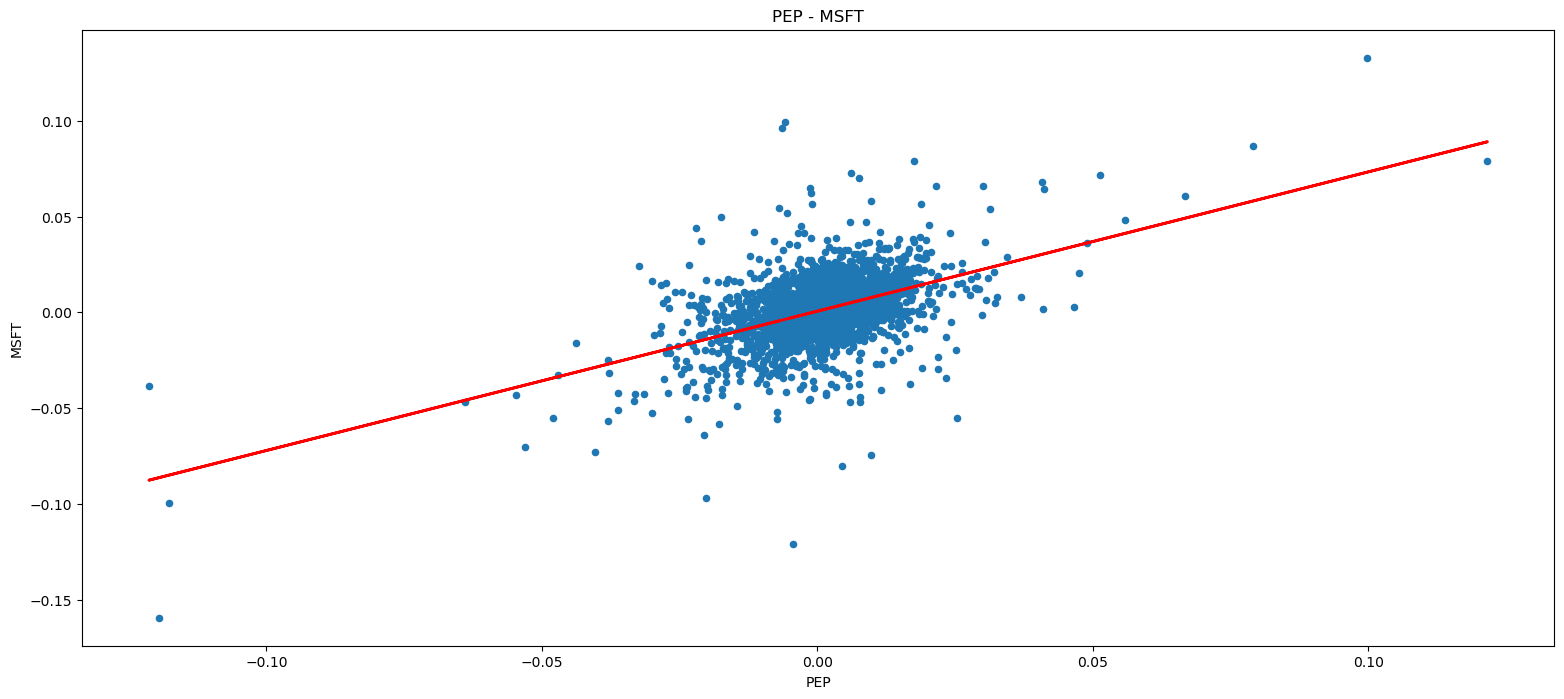

In [79]:
ax = df_log.plot(kind = 'scatter', x = 'PEP', y= 'MSFT', figsize=(19,8))
ax.plot(df_log['PEP'], np.polyval(reg, df_log['PEP']), 'r', lw=2);
ax.set_title("PEP - MSFT")

In [80]:
reg = np.polyfit(df_log['PEP'], df_log['ADBE'], deg=1)

Text(0.5, 1.0, 'PEP - ADBE')

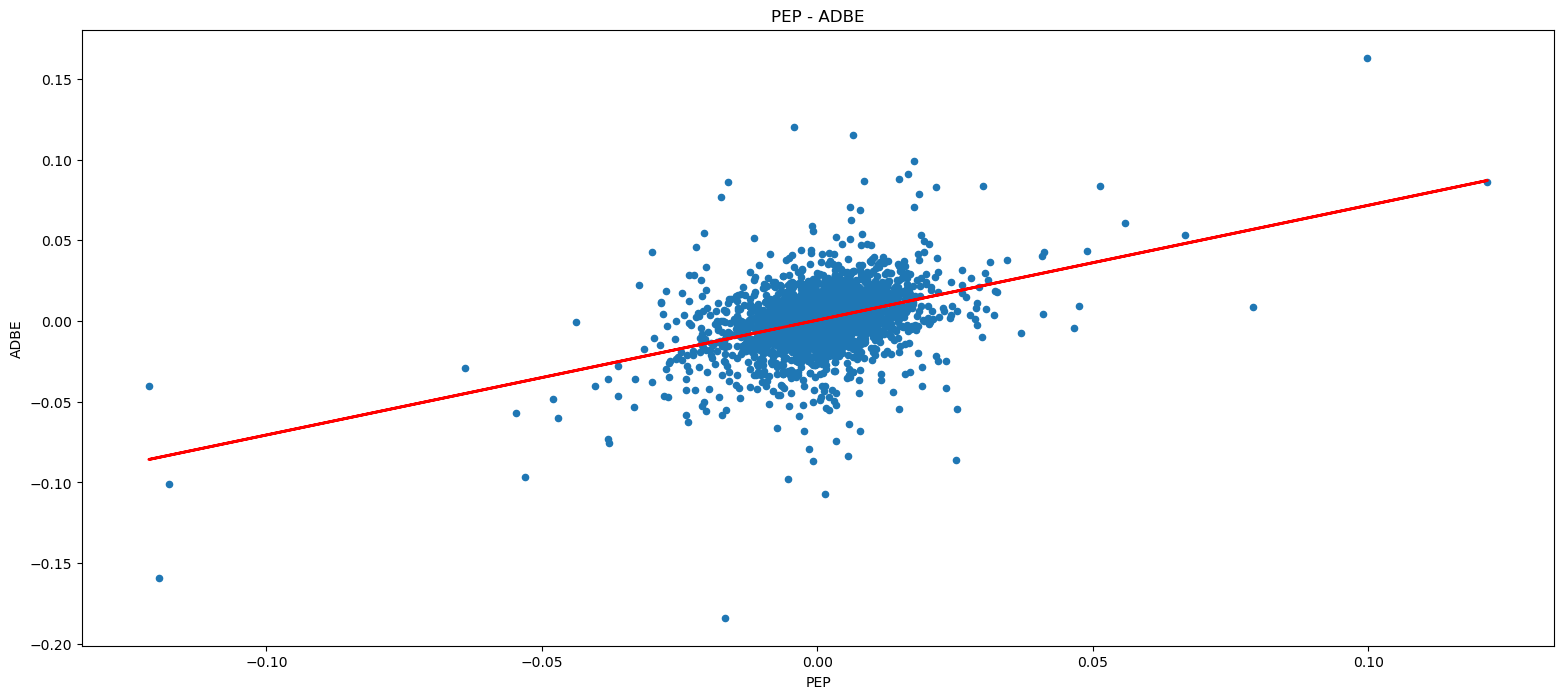

In [81]:
ax = df_log.plot(kind = 'scatter', x = 'PEP', y= 'ADBE', figsize=(19,8))
ax.plot(df_log['PEP'], np.polyval(reg, df_log['PEP']), 'r', lw=2);
ax.set_title("PEP - ADBE")

In [82]:
reg = np.polyfit(df_log['MSFT'], df_log['ADBE'], deg=1)

Text(0.5, 1.0, 'MSFT - ADBE')

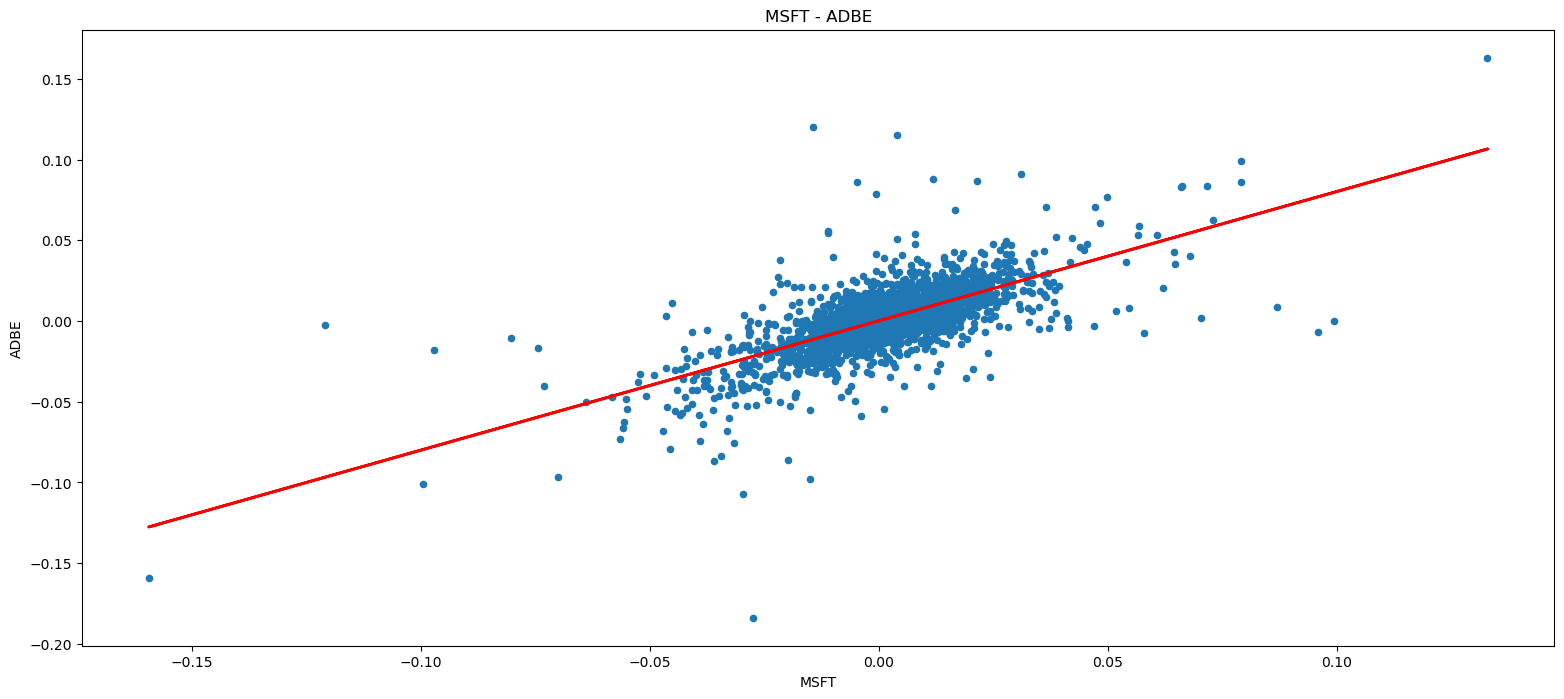

In [83]:
ax = df_log.plot(kind = 'scatter', x = 'MSFT', y= 'ADBE', figsize=(19,8))
ax.plot(df_log['MSFT'], np.polyval(reg, df_log['MSFT']), 'r', lw=2);
ax.set_title("MSFT - ADBE")

# Analisi di Previsione

## ARIMA

In [84]:
df_m = df.resample('M').last()
df_m.head()

TSLA         F         KO        PEP       MSFT       ADBE
Date                                                                      
2012-11-30  2.254667  7.618592  27.682364  52.271538  21.950113  34.610001
2012-12-31  2.258000  8.616661  26.463234  51.340958  22.024323  37.680000
2013-01-31  2.500667  8.680113  27.185955  54.657143  22.634508  37.830002
2013-02-28  2.322000  8.452218  28.266384  57.254528  23.112896  39.310001
2013-03-31  2.526000  8.814170  29.735712  59.778347  23.786329  43.520000

In [85]:
# grid_search

def arima_grid_search(dataframe, s):
    p = d = q = range(2)
    param_combinations = list(itertools.product(p, d, q))
    lowest_aic, pdq, pdqs = None, None, None
    total_iterations = 0
    for order in param_combinations:
        for (p, q, d) in param_combinations:
            seasonal_order = (p, q, d, s)
            total_iterations += 1
            try:
                model = SARIMAX(dataframe, order = order,
                               seasonal_order=seasonal_order
                               )
                model_result = model.fit()
                
                if lowest_aic is None or model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    pdq, pdqs = order, seasonal_order
            
            except Exception as ex:
                continue
                
    return lowest_aic, pdq, pdqs

In [86]:
assets

['TSLA', 'F', 'KO', 'PEP', 'MSFT', 'ADBE']

In [87]:
def print_adf(name):
    rst = adfuller(name)
    print("Statistica del test: " + str(rst[0]))
    print("p-value: " + str(rst[1]))
    print("Numero di lag utilizzati: " + str(rst[2]))
    print("Numero di osservazioni: " + str(rst[3]))
    print("Valori critici per la statistica: ", rst[4])
    
    if (rst[1] <= 0.05) & (rst[0] <= rst[4]['5%']): #p-value <= 0.05
        print("Risultato: stazionaria")
    else:
        print("Risultato: non-stazionaria")

In [88]:
for asset in assets:
    print(asset)
    print_adf(df_m[asset])
    print("\n\n")

TSLA
Statistica del test: -4.154236521472517
p-value: 0.000786813500934677
Numero di lag utilizzati: 11
Numero di osservazioni: 109
Valori critici per la statistica:  {'1%': -3.49181775886872, '5%': -2.8884437992971588, '10%': -2.5811201893779985}
Risultato: stazionaria



F
Statistica del test: -2.1013132728584
p-value: 0.2439868558994095
Numero di lag utilizzati: 0
Numero di osservazioni: 120
Valori critici per la statistica:  {'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}
Risultato: non-stazionaria



KO
Statistica del test: -0.04840626198837478
p-value: 0.9543411025905046
Numero di lag utilizzati: 2
Numero di osservazioni: 118
Valori critici per la statistica:  {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
Risultato: non-stazionaria



PEP
Statistica del test: 1.0666406504407913
p-value: 0.9949216129452163
Numero di lag utilizzati: 2
Numero di osservazioni: 118
Valori critici per la statistica:  {'1%': -3.487021

Test ADF

* H0 (ipotesi nulla): serie non stazionaria
* H1 (ipotesi alternativa): serie stazionaria

Nel test ADfuller, se ho un p-value<=5.0 rifiuto H0, altrimenti non posso rifiutarla

### Trend, seasonal e resid

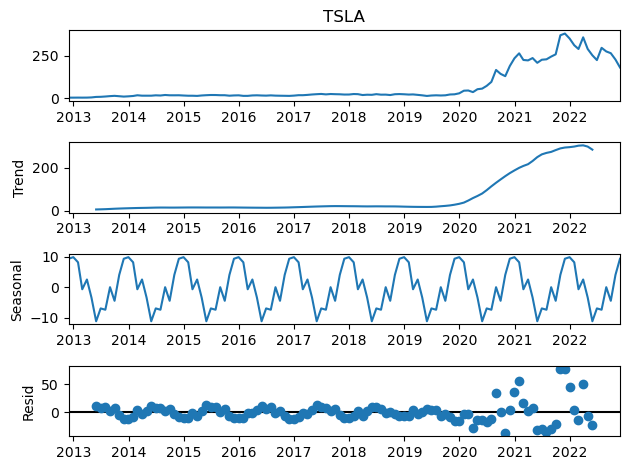

In [89]:
decompose = seasonal_decompose(df_m['TSLA'])
decompose.plot();

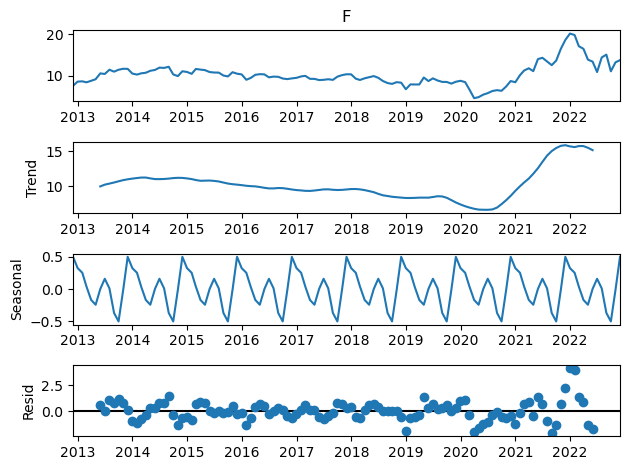

In [90]:
decompose = seasonal_decompose(df_m['F'])
decompose.plot();

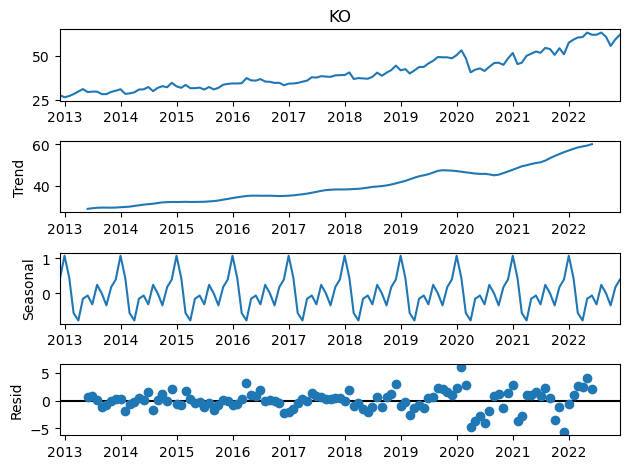

In [91]:
decompose = seasonal_decompose(df_m['KO'])
decompose.plot();

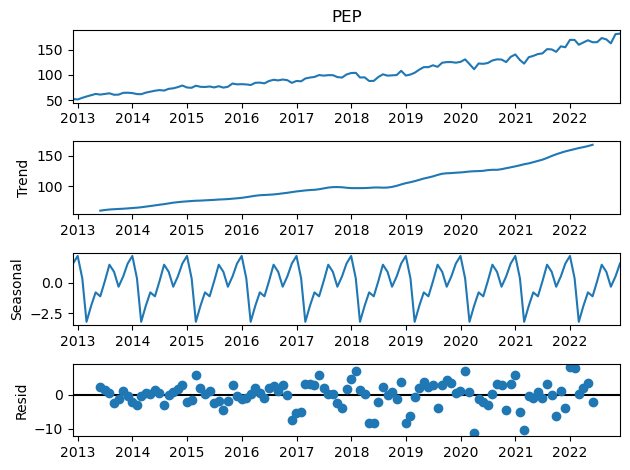

In [92]:
decompose = seasonal_decompose(df_m['PEP'])
decompose.plot();

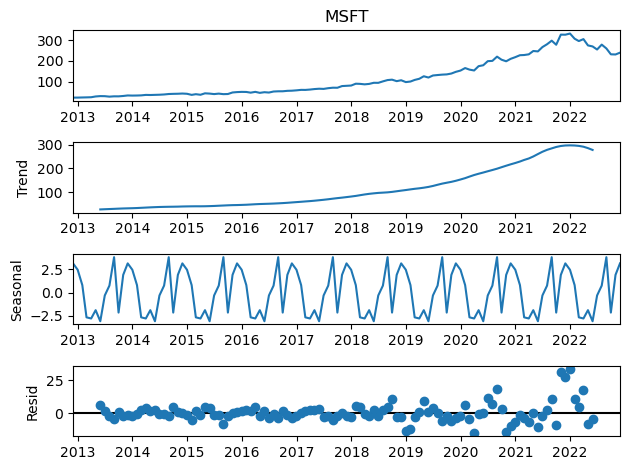

In [93]:
decompose = seasonal_decompose(df_m['MSFT'])
decompose.plot();

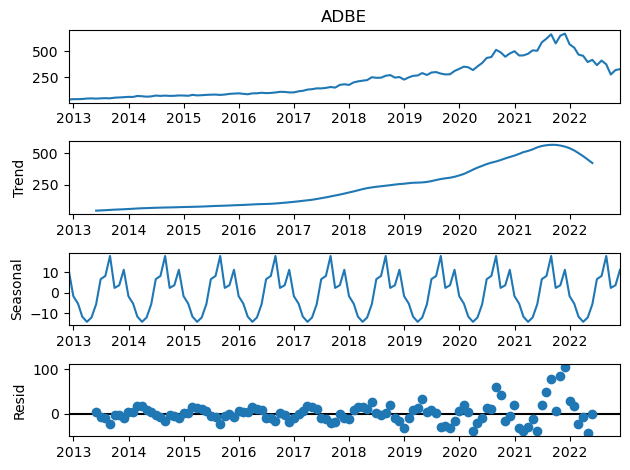

In [94]:
decompose = seasonal_decompose(df_m['ADBE'])
decompose.plot();

### SARIMAX

In [95]:
df_m

TSLA          F         KO         PEP        MSFT  \
Date                                                                   
2012-11-30    2.254667   7.618592  27.682364   52.271538   21.950113   
2012-12-31    2.258000   8.616661  26.463234   51.340958   22.024323   
2013-01-31    2.500667   8.680113  27.185955   54.657143   22.634508   
2013-02-28    2.322000   8.452218  28.266384   57.254528   23.112896   
2013-03-31    2.526000   8.814170  29.735712   59.778347   23.786329   
...                ...        ...        ...         ...         ...   
2022-07-31  297.149994  14.394472  63.256905  172.714706  279.358093   
2022-08-31  275.609985  15.082345  60.831909  170.059219  260.735199   
2022-09-30  265.250000  11.084138  55.625496  162.247925  232.245483   
2022-10-31  227.539993  13.231689  59.428520  180.454361  231.477661   
2022-11-30  180.830002  13.750000  62.040001  181.458099  240.330002   

                  ADBE  
Date                    
2012-11-30   34.610001  
2012-12-31   37.680000  
2013-01-31   37.830002  
2013-02-28   39.310001  
2013-03-31   43.520000  
...                ...  
2022-07-31  410.119995  
2022-08-31  373.440002  
2022-09-30  275.200012  
2022-10-31  318.500000  
2022-11-30  326.779999  

[121 rows x 6 columns]

TSLA

[*********************100%***********************]  1 of 1 completed


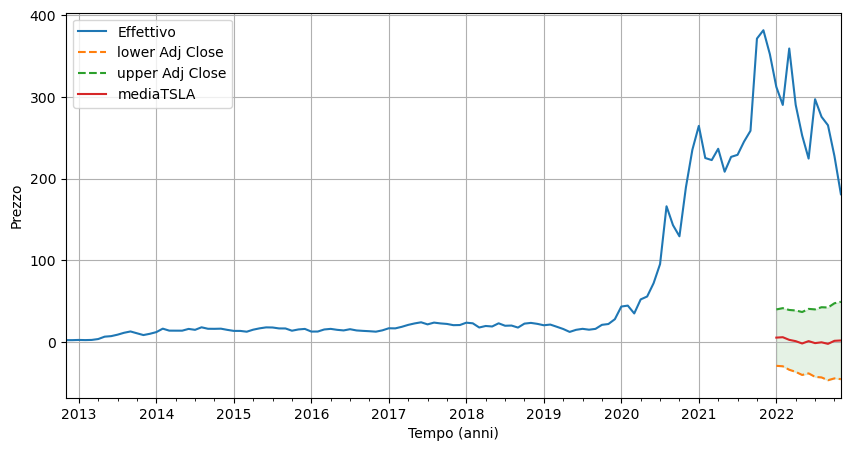

F

[*********************100%***********************]  1 of 1 completed


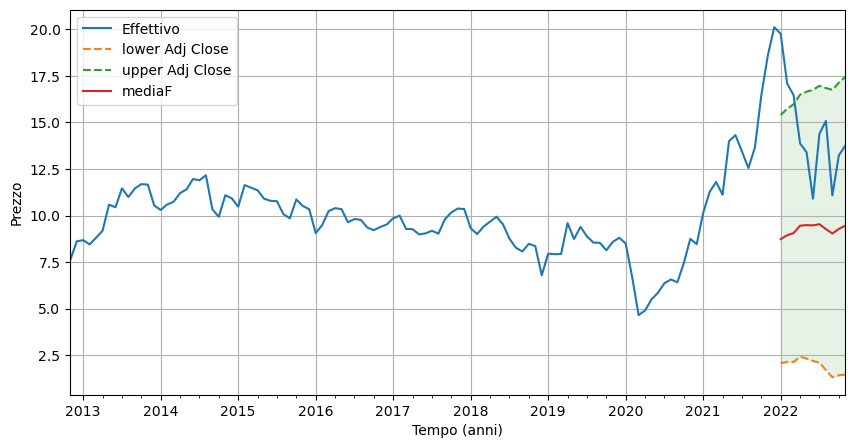

KO

[*********************100%***********************]  1 of 1 completed


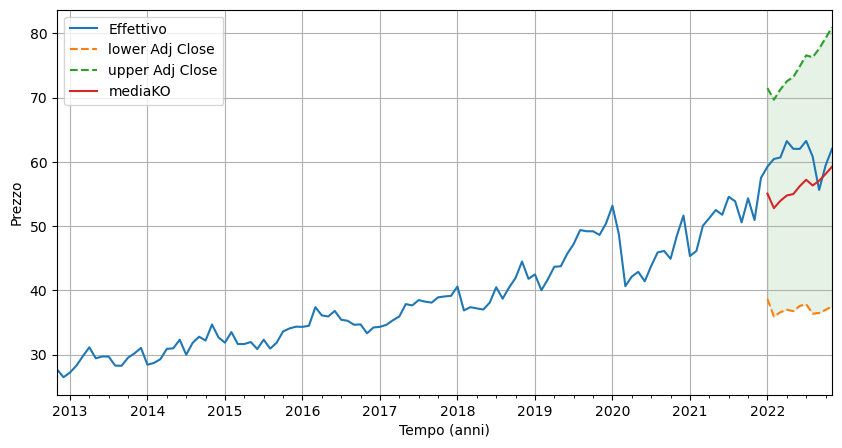

PEP

[*********************100%***********************]  1 of 1 completed


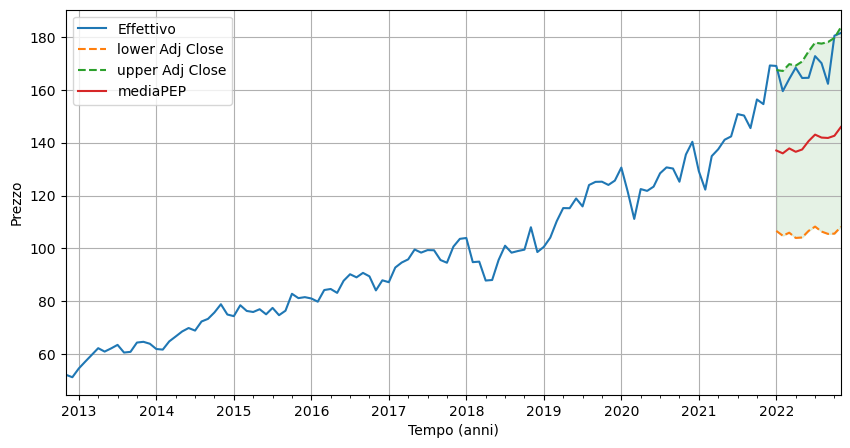

MSFT

[*********************100%***********************]  1 of 1 completed


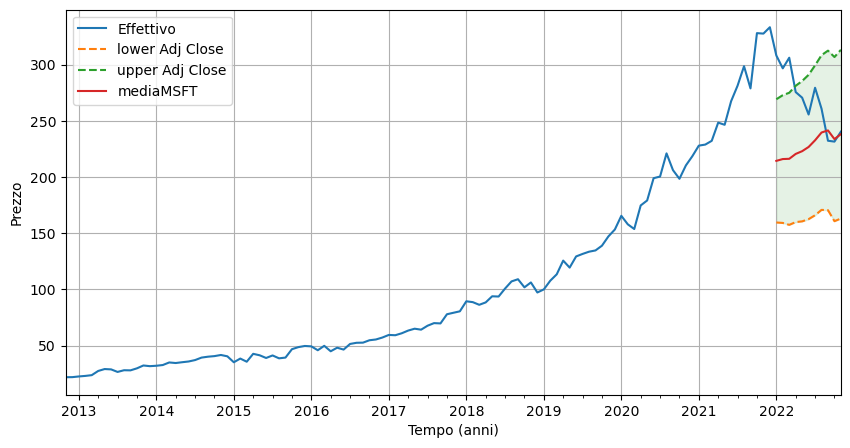

ADBE

[*********************100%***********************]  1 of 1 completed


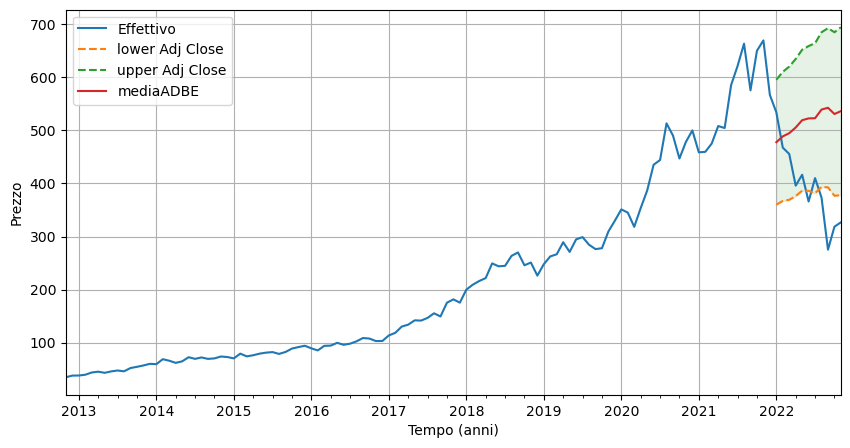

In [96]:
df_pred = pd.DataFrame()
for asset in assets:
    print(asset)
    print("")
    df1 = yf.download(asset, '2012-11-30', '2022-11-30')
    df1 = df1['Adj Close'].resample('M').last()
    train = df1[:80] # 80 mesi
    validation = df1[80:110] # 30 mesi
    test = df1[110:120] # 10 mesi
    lowest_aic, order, seasonal_order = arima_grid_search(df1[:110], 12) #Train + Validation
    model = SARIMAX(train, order = order, #Train
                          seasonal_order= seasonal_order,
                          enforce_stationarity=False,
                          enforce_invertibility=False,
                          disp = False)
    model_results = model.fit(maxiter=200, disp=False)
    prediction = model_results.get_prediction(start='30-01-2022', end = '30-11-2022') #Test
    prediction_ci = prediction.conf_int()
    prediction_ci['media'+asset] = prediction_ci.mean(axis=1)
    df_pred1 = pd.DataFrame(prediction_ci['media'+asset])
    df_pred = pd.concat([df_pred, df_pred1], axis=1)
    plt.figure(figsize=(10,5))
    ax = df1['2012':].plot(label = 'Effettivo')
    prediction_ci.plot(ax=ax, style = ['--', '--'], label = 'predicted/forecasted')
    ci_index = prediction_ci.index
    lower_ci = prediction_ci.iloc[:,0]
    upper_ci = prediction_ci.iloc[:,1]
    ax.fill_between(ci_index, lower_ci, upper_ci, color = 'g', alpha = 0.1)
    ax.set_xlabel('Tempo (anni)')
    ax.set_ylabel('Prezzo')
    plt.grid()
    plt.legend()
    plt.show()

## 4. Strategie di trading e backtesting

Come strategia di trading si è scelto il SMA

In [97]:
#Titolos scelto
ticker = 'KO'

data = yf.download(ticker, start_date, end_date)
data = data.drop(columns = ['High', 'Low', 'Open', 'Close'])

data['SMA20'] = data['Adj Close'].rolling(20).mean()
data['SMA120'] = data['Adj Close'].rolling(120).mean()

[*********************100%***********************]  1 of 1 completed


In [98]:
data

Adj Close      Volume      SMA20     SMA120
Date                                                   
2012-11-30  27.682364  13039500.0        NaN        NaN
2012-12-03  27.288160  12864900.0        NaN        NaN
2012-12-04  27.120253  11794200.0        NaN        NaN
2012-12-05  27.237047  14561400.0        NaN        NaN
2012-12-06  27.288160   8974700.0        NaN        NaN
...               ...         ...        ...        ...
2022-11-22  61.910915  12319600.0  59.787973  60.138804
2022-11-23  62.188946   8990400.0  59.948832  60.143473
2022-11-25  62.248520   5165500.0  60.105719  60.149453
2022-11-28  62.258453  12267500.0  60.202036  60.152417
2022-11-29  62.040001  10969600.0  60.332611  60.156497

[2517 rows x 4 columns]

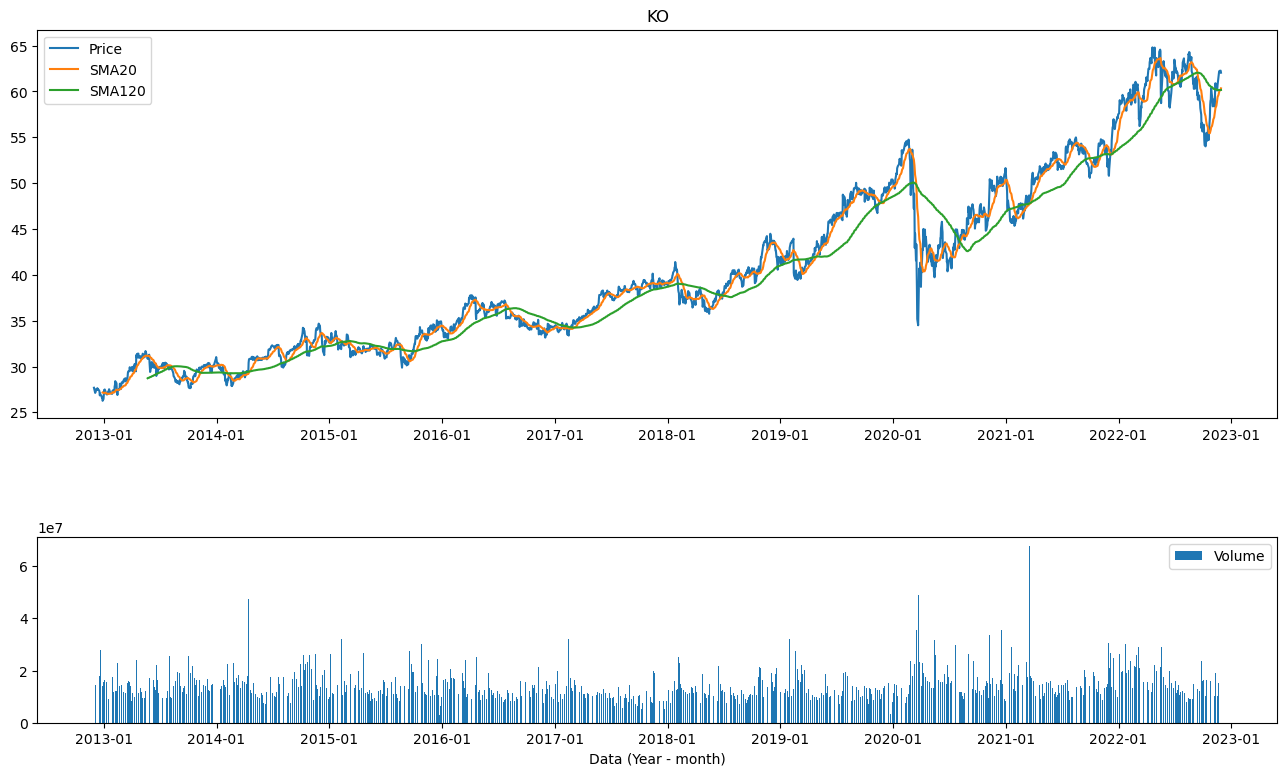

In [99]:
plt.figure(figsize=(16,9))
ax1 = plt.subplot2grid((7,1), (0,0), rowspan = 4, colspan = 1, title = ticker)
ax2 = plt.subplot2grid((7,1), (5,0), rowspan = 2, colspan = 1, sharex = ax1)
ax1.plot(data['Adj Close'], label = 'Price')
ax1.plot(data['SMA20'], label = 'SMA20')
ax1.plot(data['SMA120'], label = 'SMA120')

ax2.bar(data.index, data['Volume'], label = 'Volume')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) #Formattiamo le date secondo l'ordine Anno-Mese
ax2.set_xlabel('Data (Year - month)')
ax1.legend()
ax2.legend();


In [100]:
data['Price_yesterday'] = data['Adj Close'].shift(1)
data['Change'] = data['Adj Close'] / data['Price_yesterday']
data['Invested_SMA'] = [1 if data.loc[i, 'SMA20'] > data.loc[i, 'SMA120'] 
                        else 0 for i in data.index]

In [101]:
data

Adj Close      Volume      SMA20     SMA120  Price_yesterday  \
Date                                                                       
2012-11-30  27.682364  13039500.0        NaN        NaN              NaN   
2012-12-03  27.288160  12864900.0        NaN        NaN        27.682364   
2012-12-04  27.120253  11794200.0        NaN        NaN        27.288160   
2012-12-05  27.237047  14561400.0        NaN        NaN        27.120253   
2012-12-06  27.288160   8974700.0        NaN        NaN        27.237047   
...               ...         ...        ...        ...              ...   
2022-11-22  61.910915  12319600.0  59.787973  60.138804        61.642818   
2022-11-23  62.188946   8990400.0  59.948832  60.143473        61.910915   
2022-11-25  62.248520   5165500.0  60.105719  60.149453        62.188946   
2022-11-28  62.258453  12267500.0  60.202036  60.152417        62.248520   
2022-11-29  62.040001  10969600.0  60.332611  60.156497        62.258453   

              Change  Invested_SMA  
Date                                
2012-11-30       NaN             0  
2012-12-03  0.985760             0  
2012-12-04  0.993847             0  
2012-12-05  1.004307             0  
2012-12-06  1.001877             0  
...              ...           ...  
2022-11-22  1.004349             0  
2022-11-23  1.004491             0  
2022-11-25  1.000958             0  
2022-11-28  1.000160             1  
2022-11-29  0.996491             1  

[2517 rows x 7 columns]

Plottiamo i segnali generati

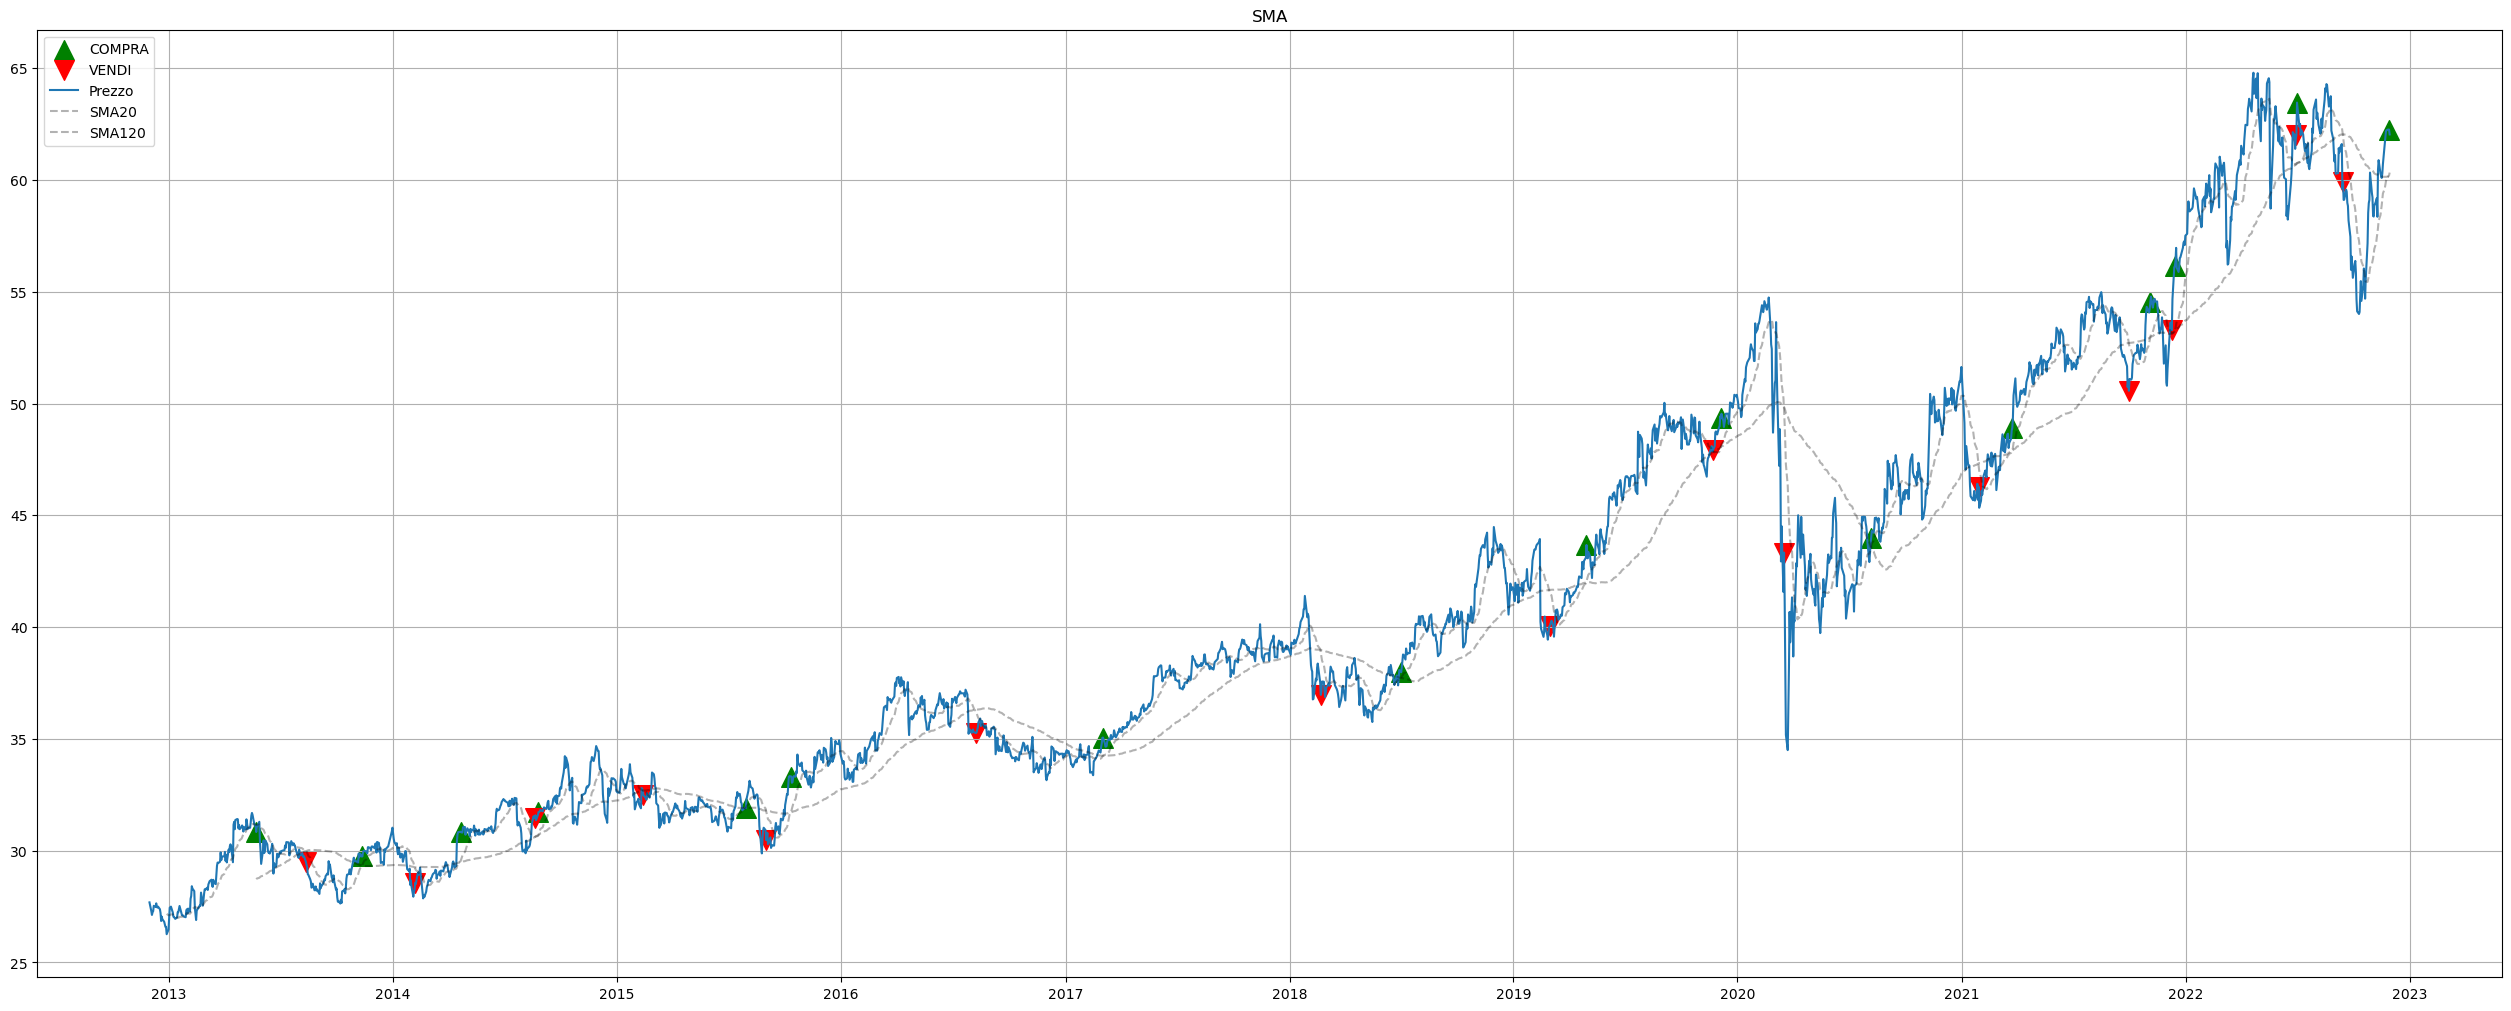

In [102]:
# plot segnali

data['compra'] = np.where((data['Invested_SMA'] == 1) & (data['Invested_SMA'].shift(1) == 0), data["Adj Close"], np.nan)
data['vendi'] = np.where((data['Invested_SMA'] == 0) & (data['Invested_SMA'].shift(1) == 1), data["Adj Close"], np.nan)


plt.figure(figsize=(25,10), constrained_layout = True)
plt.title("SMA")

plt.scatter(data.index, data['compra'], marker = '^', color = 'g', label = 'COMPRA', s = 200)
plt.scatter(data.index, data['vendi'], marker = 'v', color = 'r', label = 'VENDI', s = 200)


plt.plot(data["Adj Close"], label = 'Prezzo')
plt.plot(data['SMA20'], label = 'SMA20', color = 'k', linestyle = '--', alpha = 0.3)
plt.plot(data['SMA120'], label = 'SMA120', color = 'k', linestyle = '--', alpha = 0.3)


plt.grid()
plt.legend();

Calcoliamo i rendimenti della nostra strategia

In [103]:
sma = data[data['Invested_SMA'] == 1]

In [104]:
sma['Return'] = np.cumprod(sma['Change'])

In [105]:
sma['rtn'] =sma['Return'].pct_change()

In [106]:
sma['rtn'].std()*np.sqrt(252) #Volatilità

0.17376641789940908

Indice di Sharpe strategia

In [107]:
sma['rtn'].mean()*252 / (sma['rtn'].std()*np.sqrt(252))

0.23622494848690254

Calcolo il rendimento della Buy & Hold

In [108]:
data['Buy_and_hold'] = np.cumprod(data['Change'])
data['rtn'] = data['Buy_and_hold'].pct_change()
data['rtn'].std()

0.01141141934421847

Indice di Sharpe B&H

In [109]:
data['rtn'].mean()*252 / (data['rtn'].std()*np.sqrt(252))

0.5454259410263337

Confrontiamo la nostra strategia con la Buy & Hold

In [110]:
data

Adj Close      Volume      SMA20     SMA120  Price_yesterday  \
Date                                                                       
2012-11-30  27.682364  13039500.0        NaN        NaN              NaN   
2012-12-03  27.288160  12864900.0        NaN        NaN        27.682364   
2012-12-04  27.120253  11794200.0        NaN        NaN        27.288160   
2012-12-05  27.237047  14561400.0        NaN        NaN        27.120253   
2012-12-06  27.288160   8974700.0        NaN        NaN        27.237047   
...               ...         ...        ...        ...              ...   
2022-11-22  61.910915  12319600.0  59.787973  60.138804        61.642818   
2022-11-23  62.188946   8990400.0  59.948832  60.143473        61.910915   
2022-11-25  62.248520   5165500.0  60.105719  60.149453        62.188946   
2022-11-28  62.258453  12267500.0  60.202036  60.152417        62.248520   
2022-11-29  62.040001  10969600.0  60.332611  60.156497        62.258453   

              Change  Invested_SMA     compra  vendi  Buy_and_hold       rtn  
Date                                                                          
2012-11-30       NaN             0        NaN    NaN           NaN       NaN  
2012-12-03  0.985760             0        NaN    NaN      0.985760       NaN  
2012-12-04  0.993847             0        NaN    NaN      0.979694 -0.006153  
2012-12-05  1.004307             0        NaN    NaN      0.983913  0.004307  
2012-12-06  1.001877             0        NaN    NaN      0.985760  0.001877  
...              ...           ...        ...    ...           ...       ...  
2022-11-22  1.004349             0        NaN    NaN      2.236475  0.004349  
2022-11-23  1.004491             0        NaN    NaN      2.246519  0.004491  
2022-11-25  1.000958             0        NaN    NaN      2.248671  0.000958  
2022-11-28  1.000160             1  62.258453    NaN      2.249030  0.000160  
2022-11-29  0.996491             1        NaN    NaN      2.241138 -0.003509  

[2517 rows x 11 columns]

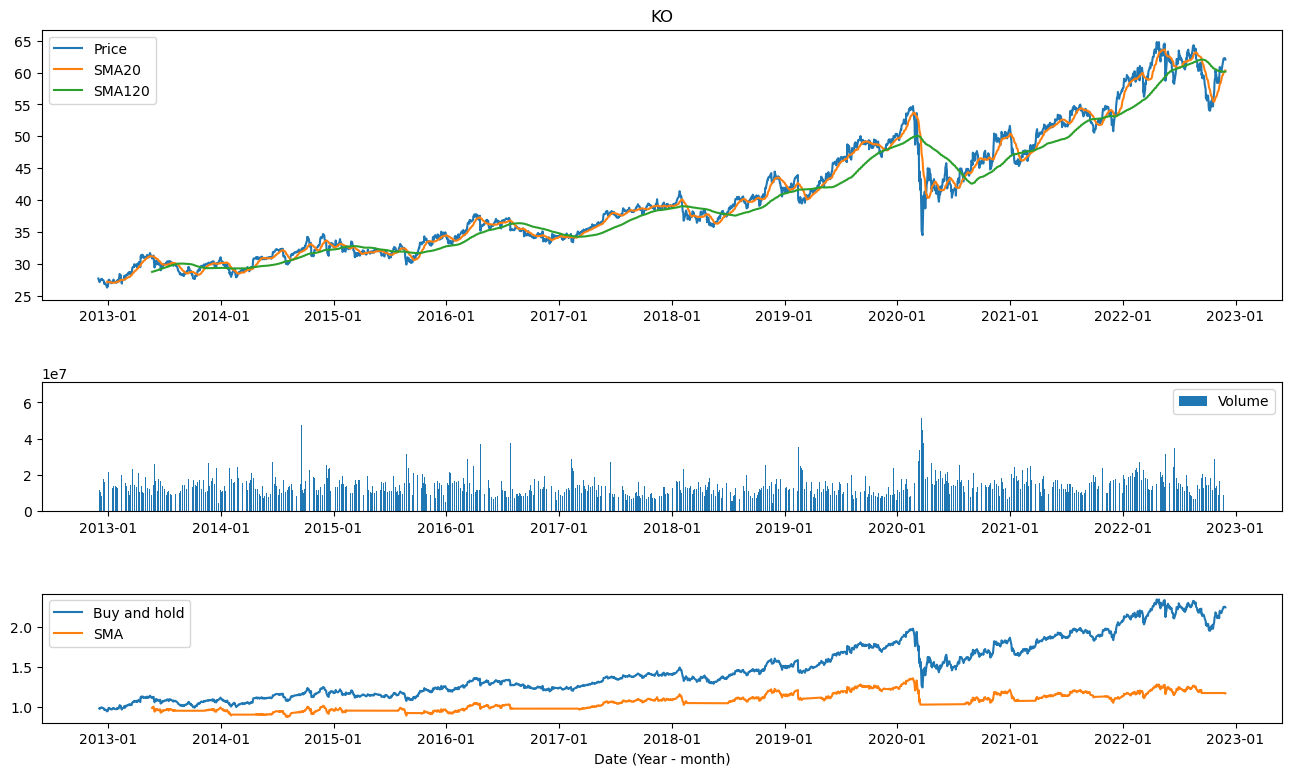

In [111]:
plt.figure(figsize=(16,9))
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1, title = ticker)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 2, colspan = 1, sharex = ax1)
ax3 = plt.subplot2grid((10,1), (8,0), rowspan = 2, colspan = 1, sharex = ax1)
ax1.plot(data['Adj Close'], label = 'Price')
ax1.plot(data['SMA20'], label = 'SMA20')
ax1.plot(data['SMA120'], label = 'SMA120')

ax2.bar(data.index, data['Volume'], label = 'Volume')
ax3.plot(data['Buy_and_hold'], label = 'Buy and hold')
ax3.plot(sma['Return'], label = 'SMA')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3.set_xlabel('Date (Year - month)')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()


Come possiamo vedere la Buy & Hold risulta essere una strategia migliore della nostra

Prendo gli ultimi valori delle due serie

In [112]:
data['Buy_and_hold'][-1]

2.2411381489452817

In [113]:
sma['Return'][-1]

1.1733005922445474

# CAPM

Anzitutto, calcoliamo il Beta ci ciascun titolo

In [114]:
# scarico S&P 500 da yfinance

sp500 = yf.download('^GSPC', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [115]:
# calcolo i rendimenti semplici mensili di S&P500

market_rtn = sp500['Adj Close'].resample('M').last().pct_change().dropna()
market_rtn.head()

Date
2012-12-31    0.007068
2013-01-31    0.050428
2013-02-28    0.011061
2013-03-31    0.035988
2013-04-30    0.018086
Freq: M, Name: Adj Close, dtype: float64

In [116]:
market_rtn

Date
2012-12-31    0.007068
2013-01-31    0.050428
2013-02-28    0.011061
2013-03-31    0.035988
2013-04-30    0.018086
                ...   
2022-07-31    0.091116
2022-08-31   -0.042440
2022-09-30   -0.093396
2022-10-31    0.079863
2022-11-30    0.022120
Freq: M, Name: Adj Close, Length: 120, dtype: float64

In [117]:
b = [0,0,0,0,0,0]
i = 0
for asset in assets:
    
    asset_m_rtn =  df_m[asset].pct_change().dropna() #I rendimenti mensili dell'asset
    
    df_CAPM = pd.DataFrame()
    df_CAPM[asset] = asset_m_rtn
    df_CAPM['S&P500'] = market_rtn
    
    covariance = df_CAPM.cov().iloc[0,1]
    
    benchmark_variance = df_CAPM['S&P500'].var()
    
    beta = covariance / benchmark_variance
    b[i] = beta
    i = i+1
    
    # calcolo di beta
    beta = covariance / benchmark_variance
    print("Il Beta di ",asset," e': ", beta)

Il Beta di  TSLA  e':  1.746592679168223
Il Beta di  F  e':  1.383107480798881
Il Beta di  KO  e':  0.6044749968925404
Il Beta di  PEP  e':  0.6024602548732506
Il Beta di  MSFT  e':  0.9398504892680656
Il Beta di  ADBE  e':  1.215195308725083


In [118]:
#Il sequente file si può scaricare da: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [119]:
factor_df = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=3) #skiprows per pulire il dataframe

In [120]:
stringa = ' Annual Factors: January-December '
indices = factor_df.iloc[:,0] == stringa
start_of_annual = factor_df[indices].index[0]
factor_df = factor_df[factor_df.index < factor_df[indices].index[0]]

In [121]:
factor_df.columns = ['data', 'mkt', 'smb', 'hml', 'rf'] #Rinomino il nome delle colonne

In [122]:
factor_df['data'] = pd.to_datetime(factor_df['data'], format='%Y%m').dt.strftime("%Y-%m")

In [123]:
factor_df = factor_df.set_index('data')
factor_df = factor_df[start_date:end_date]

In [124]:
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)
factor_df.head()

mkt     smb     hml      rf
data                                   
2012-12  0.0118  0.0150  0.0351  0.0001
2013-01  0.0557  0.0033  0.0096  0.0000
2013-02  0.0129 -0.0028  0.0011  0.0000
2013-03  0.0403  0.0081 -0.0019  0.0000
2013-04  0.0155 -0.0236  0.0045  0.0000

Stimiamo il modello a tre fattori

In [125]:
df_m['TSLA'].pct_change().dropna()

Date
2012-12-31    0.001478
2013-01-31    0.107470
2013-02-28   -0.071448
2013-03-31    0.087855
2013-04-30    0.424914
                ...   
2022-07-31    0.323765
2022-08-31   -0.072489
2022-09-30   -0.037589
2022-10-31   -0.142168
2022-11-30   -0.205283
Freq: M, Name: TSLA, Length: 120, dtype: float64

In [126]:
asset_m_rtn = df_m['TSLA'].pct_change().dropna()

In [127]:
asset_m_rtn.index

DatetimeIndex(['2012-12-31', '2013-01-31', '2013-02-28', '2013-03-31',
               '2013-04-30', '2013-05-31', '2013-06-30', '2013-07-31',
               '2013-08-31', '2013-09-30',
               ...
               '2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31',
               '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30'],
              dtype='datetime64[ns]', name='Date', length=120, freq='M')

In [128]:
# MODELLO A TRE FATTORI per ogni titolo
# i parametri mkt, smb e hml sono mostrati nel summary del modello OLS

for asset in assets:
    print(asset)
    
    # ritorni semplici mensili dell'asset
    asset_m_rtn = df_m[asset].pct_change().dropna()
    asset_m_rtn.index = pd.to_datetime(asset_m_rtn.index).strftime('%Y-%m')
    asset_m_rtn.name = 'rtn_' + asset
    
    # concatenazione e calcolo rendimenti in eccesso rispetto al risk free
    ff_df = pd.concat([factor_df, asset_m_rtn.to_frame()], axis=1)
    ff_df['excess_rtn_' + asset] = ff_df['rtn_' + asset] - ff_df['rf']
    
    print("\nDataframe dato dall'unione tra i dati F-F e " + asset + ":\n")
    print(ff_df.head(5))
    
    ff_model = smf.ols(formula = 'excess_rtn_' + asset + ' ~ mkt + smb + hml', data = ff_df).fit()
    summary = ff_model.summary()
    print(summary)   

TSLA

Dataframe dato dall'unione tra i dati F-F e TSLA:

            mkt     smb     hml      rf  rtn_TSLA  excess_rtn_TSLA
2012-12  0.0118  0.0150  0.0351  0.0001  0.001478         0.001378
2013-01  0.0557  0.0033  0.0096  0.0000  0.107470         0.107470
2013-02  0.0129 -0.0028  0.0011  0.0000 -0.071448        -0.071448
2013-03  0.0403  0.0081 -0.0019  0.0000  0.087855         0.087855
2013-04  0.0155 -0.0236  0.0045  0.0000  0.424914         0.424914
                            OLS Regression Results                            
Dep. Variable:        excess_rtn_TSLA   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     10.31
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           4.61e-06
Time:                        09:18:21   Log-Likelihood:                 45.031
No. Observations:                 119   AIC:                       

### Utilizzare il beta per calcolare il rendimento atteso annuo del titolo

In [129]:
expected_mkt = factor_df.iloc[-12:, 0].mean() * 12 # 12 * (media ultimi 12 mesi colonna 0 = mkt)
expected_rf = factor_df.iloc[-12:, 3].mean() * 12 # 12 * (media ultimi 12 mesi colonna 3 = rf)

print("Tasso risk-free annuo: ", expected_rf)
print("Rendimento atteso annuo di mercato: ", expected_mkt, "\n\n")

i = 0
exp = [0,0,0,0,0,0]
for asset in assets:
    tmp = expected_rf + b[i] * (expected_mkt - expected_rf)
    exp[i] = tmp
    i = i + 1
    print("Rendimento atteso annuo di " + asset + ": " + str(tmp))

Tasso risk-free annuo:  0.0081
Rendimento atteso annuo di mercato:  -0.1789 


Rendimento atteso annuo di TSLA: -0.3185128310044577
Rendimento atteso annuo di F: -0.25054109890939075
Rendimento atteso annuo di KO: -0.10493682441890505
Rendimento atteso annuo di PEP: -0.10456006766129787
Rendimento atteso annuo di MSFT: -0.16765204149312826
Rendimento atteso annuo di ADBE: -0.21914152273159054


In [130]:
exp #Ci servirà per la costruzione del portfolio

[-0.3185128310044577,
 -0.25054109890939075,
 -0.10493682441890505,
 -0.10456006766129787,
 -0.16765204149312826,
 -0.21914152273159054]

# Costruzione del portafoglio

Utilizziamo dunque i primi 108 mesi

In [131]:
df_m['TSLA'][:108].pct_change().dropna().to_frame()

TSLA
Date                
2012-12-31  0.001478
2013-01-31  0.107470
2013-02-28 -0.071448
2013-03-31  0.087855
2013-04-30  0.424914
...              ...
2021-06-30  0.087137
2021-07-31  0.011034
2021-08-31  0.070605
2021-09-30  0.054042
2021-10-31  0.436530

[107 rows x 1 columns]

In [132]:
df_past = pd.DataFrame()
for asset in assets:
    df_past = pd.concat([df_past, df_m[asset][:108].pct_change().dropna().to_frame()], axis=1)
    
df_past.head()

TSLA         F        KO       PEP      MSFT      ADBE
Date                                                                  
2012-12-31  0.001478  0.131004 -0.044040 -0.017803  0.003381  0.088703
2013-01-31  0.107470  0.007364  0.027310  0.064591  0.027705  0.003981
2013-02-28 -0.071448 -0.026255  0.039742  0.047521  0.021135  0.039122
2013-03-31  0.087855  0.042823  0.051981  0.044081  0.029137  0.107097
2013-04-30  0.424914  0.042586  0.046736  0.042473  0.156938  0.035846

In [133]:
# Inizializzazione
n_portfolio = 10 ** 5
n_period = 12

n_assets = len(assets) # 6

# Matrice di covarianze
cov_mat = df_past.cov() * n_period

### Metodo Monte Carlo con rendimenti passati

In [134]:
# Rendimenti
avg_ret = df_past.mean() * n_period

In [135]:
#Simulo portafogli con pesi casuali:
np.random.seed(42)
weights = np.random.random(size=(n_portfolio, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [136]:
# Calcoliamo il rendimento del portfolio
portf_rtns = np.dot(weights, avg_ret)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

Creiamo un df con tutti i dati

In [137]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [138]:
max_rtn = portf_results_df.returns.max() #Corrisponde al ritorno massimo
min_rtn = portf_results_df.returns.min() #Corrisponde al ritorno minimo

In [139]:
#Creazione della frontiera efficiente
n_points = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                           n_points)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(n_points):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)
    

In [140]:
n_assets

6

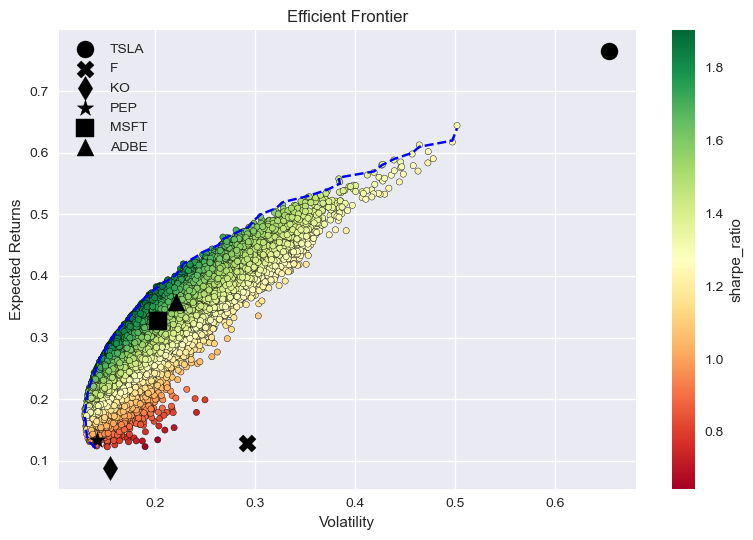

In [141]:
plt.style.use('seaborn')
sns.set_palette('cubehelix')
MARKS = ['o', 'X', 'd', '*', 's', '^']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_ret[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=assets[asset_index])
ax.legend()

plt.tight_layout()
plt.show()


In [142]:
# max sharpe ratio
print("MAX SHARPE RATIO")
max_sr = np.argmax(portf_results_df.sharpe_ratio)
max_sr_portfolio = portf_results_df.loc[max_sr]
max_sr_weights = weights[np.argmax(portf_results_df.sharpe_ratio)]

print("Rendimento atteso: ", max_sr_portfolio['returns'])
print("Volatilità: ", max_sr_portfolio['volatility'])
print("Sharpe Ratio: ", max_sr_portfolio['sharpe_ratio'])

print()

print("Pesi dei titoli")
for index in range(0, len(assets)):
    print(assets[index] + ": ", max_sr_weights[index])

# beta portfolio rispetto al mercato 
# (= somma pesata dei beta degli asset rispetto al mercato = dot product)

beta_max_sr = np.dot(max_sr_weights, list(b))

print()
print("Beta rispetto al portafoglio di mercato: ", beta_max_sr)

MAX SHARPE RATIO
Rendimento atteso:  0.35587700808676825
Volatilità:  0.18708926609273063
Sharpe Ratio:  1.9021775835625874

Pesi dei titoli
TSLA:  0.10459860313010863
F:  0.022618240224473708
KO:  0.004797614085307606
PEP:  0.12611655809496775
MSFT:  0.3117124096554427
ADBE:  0.43015657480969965

Beta rispetto al portafoglio di mercato:  1.1085421756797778


In [143]:
#Min volatility

print("MIN VOLATILITY")
min_vol = np.argmin(portf_results_df.volatility)
min_vol_portfolio = portf_results_df.loc[min_vol]
min_vol_weights = weights[np.argmin(portf_results_df.volatility)]

print("Rendimento atteso: ", min_vol_portfolio['returns'])
print("Volatilità: ", min_vol_portfolio['volatility'])
print("Sharpe Ratio: ", min_vol_portfolio['sharpe_ratio'])

print()

print("Pesi dei titoli")
for index in range(0, len(assets)):
    print(assets[index] + ": ", min_vol_weights[index])

# beta portfolio

beta_min_vol = np.dot(min_vol_weights, list(b))

print()
print("Beta rispetto al mercato: ", beta_min_vol)

MIN VOLATILITY
Rendimento atteso:  0.18374466564570446
Volatilità:  0.13030369583499615
Sharpe Ratio:  1.4101262782168567

Pesi dei titoli
TSLA:  0.002068485246998609
F:  0.0632484168741405
KO:  0.14435239992882692
PEP:  0.5180186607375418
MSFT:  0.17197176967536643
ADBE:  0.10034026753712576

Beta rispetto al mercato:  0.7739960048491561


In [144]:
#Max rendimento
print("MAX RENDIMENTO")

max_ret = np.argmax(portf_results_df.returns)
max_ret_portfolio = portf_results_df.loc[max_ret]
max_ret_weights = weights[np.argmax(portf_results_df.returns)]

print("Rendimento atteso: ", max_ret_portfolio['returns'])
print("Volatilità: ", max_ret_portfolio['volatility'])
print("Sharpe Ratio: ", max_ret_portfolio['sharpe_ratio'])

print()

print("Pesi dei titoli")
for index in range(0, len(assets)):
    print(assets[index] + ": ", max_ret_weights[index])
    
# beta portfolio

beta_max_ret = np.dot(max_ret_weights, list(b))

print()
print("Beta rispetto al mercato: ", beta_max_ret)

MAX RENDIMENTO
Rendimento atteso:  0.6446046002927549
Volatilità:  0.5019392374418823
Sharpe Ratio:  1.284228353172711

Pesi dei titoli
TSLA:  0.7421638564092765
F:  0.007693134770161766
KO:  0.010190886352708046
PEP:  0.04195782923136412
MSFT:  0.05503355060949371
ADBE:  0.14296074262699582

Beta rispetto al mercato:  1.5637849843268155


In [145]:
# portfolio effettivo

weights = np.array([1/6] * n_assets)

eff_portfolio=dict([])

eff_portfolio.update({'returns': np.dot(weights, avg_ret)})
eff_portfolio.update({'volatility': np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))})
eff_portfolio.update({'sharpe_ratio': eff_portfolio['returns'] / eff_portfolio['volatility']})

print("Rendimento atteso: ", eff_portfolio['returns'])
print("Volatilità: ", eff_portfolio['volatility'])
print("Sharpe Ratio: ", eff_portfolio['sharpe_ratio'])

beta_eff = np.dot(weights, b)

print()
print("Beta: ", beta_eff)

Rendimento atteso:  0.30011479848759104
Volatilità:  0.18646251208529543
Sharpe Ratio:  1.6095181553185687

Beta:  1.0819468682876738


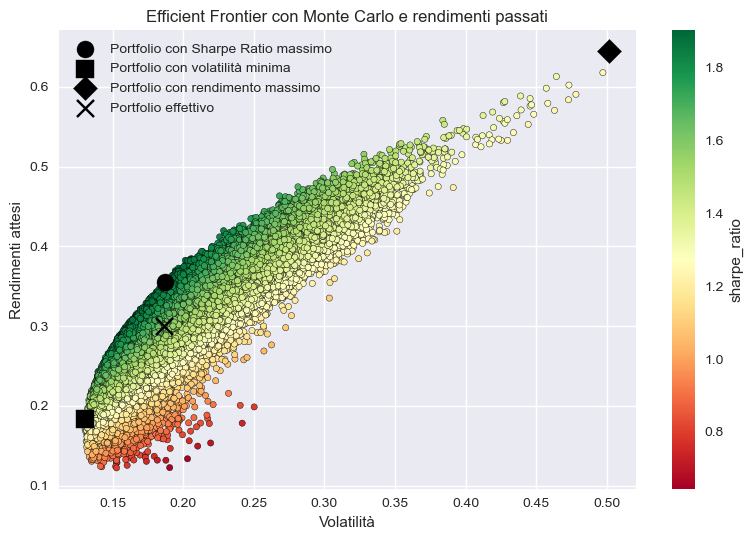

In [146]:
# mostro gli ottimi in un grafico

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)

ax.scatter(x=max_sr_portfolio.volatility, 
           y=max_sr_portfolio.returns, 
           c='black', marker='o', 
           s=150, label='Portfolio con Sharpe Ratio massimo')

ax.scatter(x=min_vol_portfolio.volatility, 
           y=min_vol_portfolio.returns, 
           c='black', marker='s', 
           s=150, label='Portfolio con volatilità minima')

ax.scatter(x=max_ret_portfolio.volatility, 
           y=max_ret_portfolio.returns, 
           c='black', marker='D', 
           s=150, label='Portfolio con rendimento massimo')

ax.scatter(x=eff_portfolio['volatility'], 
           y=eff_portfolio['returns'], 
           c='black', marker='x', 
           s=150, label='Portfolio effettivo')


ax.set(xlabel='Volatilità', ylabel='Rendimenti attesi', 
       title='Efficient Frontier con Monte Carlo e rendimenti passati')
ax.legend()

plt.tight_layout()

plt.show()

### Metodo Monte Carlo con rendimenti costruiti (nel punto 5)

In [147]:
# rendimenti
avg_ret = np.array(exp)

In [148]:
avg_ret

array([-0.31851283, -0.2505411 , -0.10493682, -0.10456007, -0.16765204,
       -0.21914152])

Adesso devo sostanzialmente applicare le medesime operazioni di prima

In [149]:
#Simulo portafogli con pesi casuali:
np.random.seed(42)
weights = np.random.random(size=(n_portfolio, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [150]:
# Calcoliamo il rendimento del portfolio
portf_rtns = np.dot(weights, avg_ret)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

Creiamo un df con tutti i dati

In [151]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [152]:
#Ci serviranno per l'utilizzo della libreia SciPy
rtn_max = portf_results_df.returns.max()
rtn_min = portf_results_df.returns.min()

In [153]:
#Creazione della frontiera efficiente
n_points = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                           n_points)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(n_points):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)
    

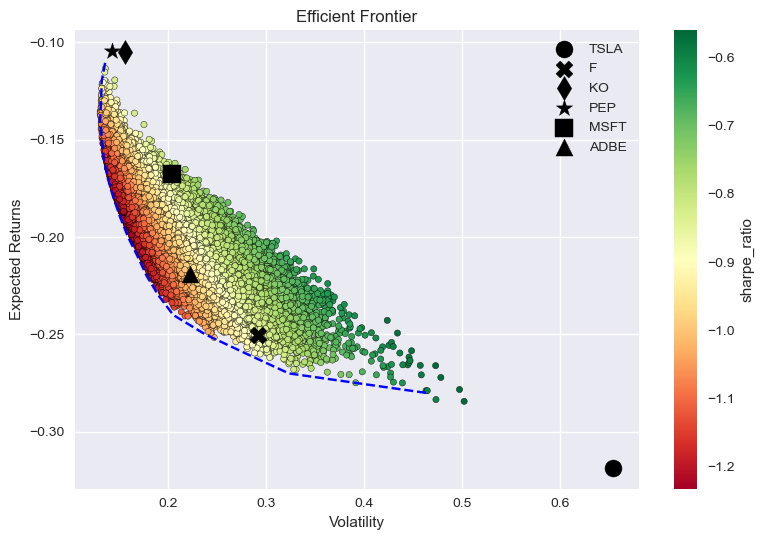

In [154]:
plt.style.use('seaborn')
sns.set_palette('cubehelix')
MARKS = ['o', 'X', 'd', '*', 's', '^']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_ret[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=assets[asset_index])
ax.legend()

plt.tight_layout()
plt.show()


In [155]:
# max sharpe ratio
print("MAX SHARPE RATIO")

max_sr = np.argmax(portf_results_df.sharpe_ratio)
max_sr_portfolio = portf_results_df.loc[max_sr]
max_sr_weights = weights[np.argmax(portf_results_df.sharpe_ratio)]

print()

print("Rendimento atteso: ", max_sr_portfolio['returns'])
print("Volatilità: ", max_sr_portfolio['volatility'])
print("Sharpe Ratio: ", max_sr_portfolio['sharpe_ratio'])

print("Pesi dei titoli")
for index in range(0, len(assets)):
    print(assets[index] + ": ", max_sr_weights[index])

print()
    
# beta portfolio

beta_max_sr = np.dot(max_sr_weights, b)
    
print("Beta rispetto al mercato: ", beta_max_sr)


MAX SHARPE RATIO

Rendimento atteso:  -0.2782683591410395
Volatilità:  0.4972589440747964
Sharpe Ratio:  -0.5596045329235607
Pesi dei titoli
TSLA:  0.73895279742989
F:  0.0436843720952633
KO:  0.09651173921115648
PEP:  0.015363839602885747
MSFT:  0.05618692139531131
ADBE:  0.049300330265492916

Beta rispetto al mercato:  1.5313815996847027


In [156]:
# min volatility
print("MIN VOLATILITY")

min_vol = np.argmin(portf_results_df.volatility)
min_vol_portfolio = portf_results_df.loc[min_vol]
min_vol_weights = weights[np.argmin(portf_results_df.volatility)]

print("Rendimento atteso: ", min_vol_portfolio['returns'])
print("Volatilità: ", min_vol_portfolio['volatility'])
print("Sharpe Ratio: ", min_vol_portfolio['sharpe_ratio'])

print()

print("Pesi dei titoli")
for index in range(0, len(assets)):
    print(assets[index] + ": ", min_vol_weights[index])

# beta portfolio

print()

beta_min_vol = np.dot(min_vol_weights, b)

print("Beta rispetto al mercato: ", beta_min_vol)

MIN VOLATILITY
Rendimento atteso:  -0.13663725290679218
Volatilità:  0.13030369583499615
Sharpe Ratio:  -1.0486061199662076

Pesi dei titoli
TSLA:  0.002068485246998609
F:  0.0632484168741405
KO:  0.14435239992882692
PEP:  0.5180186607375418
MSFT:  0.17197176967536643
ADBE:  0.10034026753712576

Beta rispetto al mercato:  0.7739960048491561


In [157]:
print("MAX RENDIMENTO")

max_ret = np.argmax(portf_results_df.returns)
max_ret_portfolio = portf_results_df.loc[max_ret]
max_ret_weights = weights[np.argmax(portf_results_df.returns)]

print("Rendimento atteso: ", max_ret_portfolio['returns'])
print("Volatilità: ", max_ret_portfolio['volatility'])
print("Sharpe Ratio: ", max_ret_portfolio['sharpe_ratio'])

print()

print("Pesi dei titoli")
for index in range(0, len(assets)):
    print(assets[index] + ": ", max_ret_weights[index])
    
# beta portfolio

beta_max_ret = np.dot(max_ret_weights, b)

print()
print("Beta portfolio rispetto al mercato: ", beta_max_ret)

MAX RENDIMENTO
Rendimento atteso:  -0.11344289245274644
Volatilità:  0.13554441983875537
Sharpe Ratio:  -0.8369425505505792

Pesi dei titoli
TSLA:  0.011826001983128422
F:  0.018166667145732254
KO:  0.3925005857494132
PEP:  0.5258439729862019
MSFT:  0.045967498832547894
ADBE:  0.005695273302976425

Beta portfolio rispetto al mercato:  0.6499619917259168


In [158]:
# portfolio effettivo

weights = np.array([1/6] * n_assets)

eff_portfolio=dict([])

eff_portfolio.update({'returns': np.dot(weights, avg_ret)})
eff_portfolio.update({'volatility': np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))})
eff_portfolio.update({'sharpe_ratio': eff_portfolio['returns'] / eff_portfolio['volatility']})


print("Rendimento atteso: ", eff_portfolio['returns'])
print("Volatilità: ", eff_portfolio['volatility'])
print("Sharpe Ratio: ", eff_portfolio['sharpe_ratio'])

beta_eff = np.dot(weights, b)

print()
print("Beta: ", beta_eff)

Rendimento atteso:  -0.19422406436979503
Volatilità:  0.18646251208529543
Sharpe Ratio:  -1.0416252693246413

Beta:  1.0819468682876738


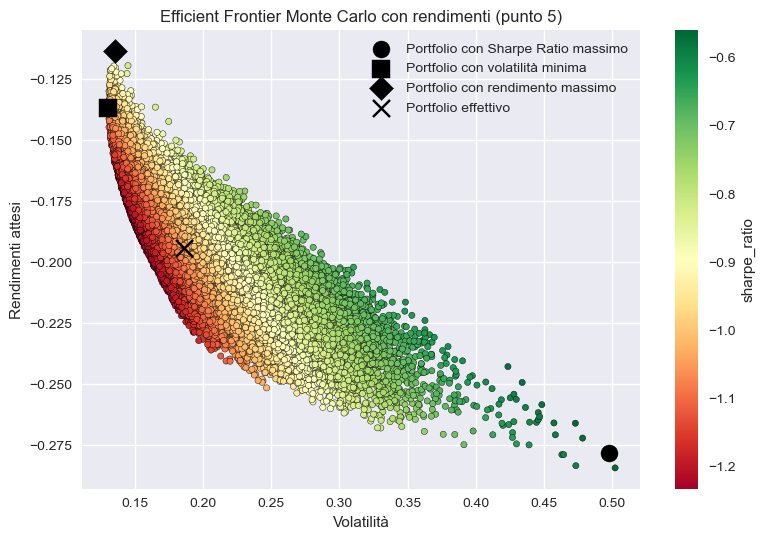

In [159]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)

ax.scatter(x=max_sr_portfolio.volatility, 
           y=max_sr_portfolio.returns, 
           c='black', marker='o', 
           s=150, label='Portfolio con Sharpe Ratio massimo')

ax.scatter(x=min_vol_portfolio.volatility, 
           y=min_vol_portfolio.returns, 
           c='black', marker='s', 
           s=150, label='Portfolio con volatilità minima')

ax.scatter(x=max_ret_portfolio.volatility, 
           y=max_ret_portfolio.returns, 
           c='black', marker='D', 
           s=150, label='Portfolio con rendimento massimo')

ax.scatter(x=eff_portfolio['volatility'], 
           y=eff_portfolio['returns'], 
           c='black', marker='x', 
           s=150, label='Portfolio effettivo')


ax.set(xlabel='Volatilità', ylabel='Rendimenti attesi', 
       title='Efficient Frontier Monte Carlo con rendimenti (punto 5)')
ax.legend()

plt.tight_layout()

plt.show()

### Metodo analitico con rendimenti passati utilizzando SciPy

In [160]:
# rendimenti
avg_ret = df_past.mean() * n_period

rtns_range = np.linspace(min_rtn, # riutilizzo le variabili definite prima
                         max_rtn,
                         200)

#Utilizziamo la matrice di covarianze calcolata precedentemente

In [161]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [162]:
def get_efficient_frontier():
    
    efficient_portfolios = []
    
    n_assets = len(avg_ret)
    args = (avg_ret, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_ret) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [163]:
efficient_portfolios = get_efficient_frontier()

vols_range = [x['fun'] for x in efficient_portfolios]

In [164]:
# preparazione dataframe

all_portfolio_df = pd.DataFrame()

all_portfolio_df.index = [i for i in range(0,len(vols_range))]

all_portfolio_df['returns'] = np.nan
all_portfolio_df['volatility'] = np.nan
all_portfolio_df['sharpe_ratio'] = np.nan

for vol in range(0,len(vols_range)):
    all_portfolio_df.iloc[vol, 0] = rtns_range[vol] # returns
    all_portfolio_df.iloc[vol, 1] = efficient_portfolios[vol]['fun'] # volatility
    all_portfolio_df.iloc[vol, 2] = rtns_range[vol] / efficient_portfolios[vol]['fun'] # sharpe_ratio
    

all_portfolio_df.tail()

returns  volatility  sharpe_ratio
195  0.634105    0.470153      1.348722
196  0.636730    0.473699      1.344165
197  0.639355    0.477254      1.339655
198  0.641980    0.480815      1.335191
199  0.644605    0.484384      1.330773

In [165]:
# max sharpe ratio
print("MAX SHARPE RATIO")

max_sr = np.argmax(all_portfolio_df.sharpe_ratio)
max_sr_portfolio = all_portfolio_df.loc[max_sr]
max_sr_weights = efficient_portfolios[max_sr]['x']

print("Rendimento atteso: ", max_sr_portfolio['returns'])
print("Volatilità: ", max_sr_portfolio['volatility'])
print("Sharpe Ratio: ", max_sr_portfolio['sharpe_ratio'])

print()

print("Pesi dei titoli")
for index in range(0, len(assets)):
    print(assets[index] + ": ", max_sr_weights[index])

# beta portfolio

beta_max_sr = np.dot(max_sr_weights, b)
    
print()
print("Beta rispetto al mercato: ", beta_max_sr)

MAX SHARPE RATIO
Rendimento atteso:  0.34800191934642
Volatilità:  0.18152245100820089
Sharpe Ratio:  1.9171288037020713

Pesi dei titoli
TSLA:  0.08869665311368034
F:  1.0116114489058109e-17
KO:  0.0
PEP:  0.1519263065750751
MSFT:  0.3798098062320091
ADBE:  0.3795672340792354

Beta rispetto al mercato:  1.0646592407910542


In [166]:
# min volatility
print("MIN VOLATILITY")


min_vol = np.argmin(all_portfolio_df.volatility)
min_vol_portfolio = all_portfolio_df.loc[min_vol]
min_vol_weights = efficient_portfolios[min_vol]['x']

print("Rendimento atteso: ", min_vol_portfolio['returns'])
print("Volatilità: ", min_vol_portfolio['volatility'])
print("Sharpe Ratio: ", min_vol_portfolio['sharpe_ratio'])

print()

print("Pesi dei titoli")
for index in range(0, len(assets)):
    print(assets[index] + ": ", min_vol_weights[index])

# beta portfolio

beta_min_vol = np.dot(min_vol_weights, b)

print()
print("Beta rispetto al mercato: ", beta_min_vol)

MIN VOLATILITY
Rendimento atteso:  0.1695153502813689
Volatilità:  0.12985550631452722
Sharpe Ratio:  1.3054151887158354

Pesi dei titoli
TSLA:  4.669084476285798e-19
F:  0.07098334008695242
KO:  0.1899699791931013
PEP:  0.5207404614630471
MSFT:  0.13009331547664554
ADBE:  0.0882129037802536

Beta rispetto al mercato:  0.7561992954486338


In [167]:
# max returns
print("MAX RENDIMENTO")

max_ret = np.argmax(all_portfolio_df.returns)
max_ret_portfolio = all_portfolio_df.loc[max_ret]
max_ret_weights = efficient_portfolios[max_ret]['x']

print("Rendimento atteso: ", max_ret_portfolio['returns'])
print("Volatilità: ", max_ret_portfolio['volatility'])
print("Sharpe Ratio: ", max_ret_portfolio['sharpe_ratio'])

print()

print("Pesi dei titoli")
for index in range(0, len(assets)):
    print(assets[index] + ": ", max_ret_weights[index])
    
# beta portfolio

beta_max_ret = np.dot(max_ret_weights, b)
    
print()
print("Beta rispetto al mercato: ", beta_max_ret)

MAX RENDIMENTO
Rendimento atteso:  0.6446046002927549
Volatilità:  0.48438364883032237
Sharpe Ratio:  1.3307728323392627

Pesi dei titoli
TSLA:  0.7040679903104843
F:  0.0
KO:  0.0
PEP:  7.594836218260959e-17
MSFT:  1.1796119636642288e-16
ADBE:  0.2959320096895157

Beta rispetto al mercato:  1.5893351873892605


### Metodo analitico con rendimenti del punto 5 utilizzando SciPy

In [168]:
# rendimenti
avg_ret = np.array(exp)

rtns_range = np.linspace(rtn_min, # diverse dalle variabili per rendimenti passati
                         rtn_max,
                         200)

# Qui usiamo la matrice delle covarianze generata precedentemente

In [169]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [170]:
def get_efficient_frontier():
    
    efficient_portfolios = []
    
    n_assets = len(avg_ret)
    args = (avg_ret, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_ret) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [171]:
efficient_portfolios = get_efficient_frontier()

vols_range = [x['fun'] for x in efficient_portfolios]

In [172]:
# preparazione dataframe

all_portfolio_df = pd.DataFrame()

all_portfolio_df.index = [i for i in range(0,len(vols_range))]

all_portfolio_df['returns'] = np.nan
all_portfolio_df['volatility'] = np.nan
all_portfolio_df['sharpe_ratio'] = np.nan

for vol in range(0,len(vols_range)):
    all_portfolio_df.iloc[vol, 0] = rtns_range[vol] # returns
    all_portfolio_df.iloc[vol, 1] = efficient_portfolios[vol]['fun'] # volatility
    all_portfolio_df.iloc[vol, 2] = rtns_range[vol] / efficient_portfolios[vol]['fun'] # sharpe_ratio

In [173]:
# max sharpe ratio
print("MAX SHARPE RATIO")

max_sr = np.argmax(all_portfolio_df.sharpe_ratio)
max_sr_portfolio = all_portfolio_df.loc[max_sr]
max_sr_weights = efficient_portfolios[max_sr]['x']

print("Rendimento atteso: ", max_sr_portfolio['returns'])
print("Volatilità: ", max_sr_portfolio['volatility'])
print("Sharpe Ratio: ", max_sr_portfolio['sharpe_ratio'])

print()

print("Pesi dei titoli")
for index in range(0, len(assets)):
    print(assets[index] + ": ", max_sr_weights[index])

# beta portfolio

beta_max_sr = np.dot(max_sr_weights, b)
    
print()
print("Beta rispetto al mercato: ", beta_max_sr)

MAX SHARPE RATIO
Rendimento atteso:  -0.2843277920691145
Volatilità:  0.38619430611756134
Sharpe Ratio:  -0.7362298914437189

Pesi dei titoli
TSLA:  0.4970697676556093
F:  0.5029302323443906
KO:  1.947227101783966e-16
PEP:  0.0
MSFT:  0.0
ADBE:  2.7755575615628914e-17

Beta rispetto al mercato:  1.563784983898583


In [174]:
# min volatility
print("MIN VOLATILITY")

min_vol = np.argmin(all_portfolio_df.volatility)
min_vol_portfolio = all_portfolio_df.loc[min_vol]
min_vol_weights = efficient_portfolios[min_vol]['x']

print("Rendimento atteso: ", min_vol_portfolio['returns'])
print("Volatilità: ", min_vol_portfolio['volatility'])
print("Sharpe Ratio: ", min_vol_portfolio['sharpe_ratio'])

print()

print("Pesi dei titoli")
for index in range(0, len(assets)):
    print(assets[index] + ": ", min_vol_weights[index])

# beta portfolio

beta_min_vol = np.dot(min_vol_weights, b)

print()
print("Beta rispetto al mercato: ", beta_min_vol)

MIN VOLATILITY
Rendimento atteso:  -0.13405212657733354
Volatilità:  0.12985344388597223
Sharpe Ratio:  -1.0323340110644141

Pesi dei titoli
TSLA:  0.0
F:  0.07117473048120339
KO:  0.1833895606825767
PEP:  0.5197708317062751
MSFT:  0.13253590269162158
ADBE:  0.09312897443832327

Beta rispetto al mercato:  0.7601717998756993


In [176]:
# max returns
print("MAX RENDIMENTO")

max_ret = np.argmax(all_portfolio_df.returns)
max_ret_portfolio = all_portfolio_df.loc[max_ret]
max_ret_weights = efficient_portfolios[max_ret]['x']

print("Rendimento atteso: ", max_ret_portfolio['returns'])
print("Volatilità: ", max_ret_portfolio['volatility'])
print("Sharpe Ratio: ", max_ret_portfolio['sharpe_ratio'])

print()

print("Pesi dei titoli")
for index in range(0, len(assets)):
    print(assets[index] + ": ", max_ret_weights[index])
    
# beta portfolio

beta_max_ret = np.dot(max_ret_weights, b)
    
print()
print("Beta rispetto al mercato", beta_max_ret)

MAX RENDIMENTO
Rendimento atteso:  -0.11344289245274644
Volatilità:  0.13322266608111646
Sharpe Ratio:  -0.8515284657617755

Pesi dei titoli
TSLA:  0.0
F:  0.003382906740310986
KO:  0.2758272363716704
PEP:  0.5894726021492998
MSFT:  0.13131725473871897
ADBE:  4.356970328017524e-18

Beta rispetto al mercato 0.6499619917152022
